In [1]:
# import necessary libraries
import requests
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen

import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import time
import os
import sys
import csv
import string

import statsmodels.formula.api as sm
from statistics import mode

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

# pd.set_option("display.max_rows", 1000, "display.max_columns", 1000)

## Start
We'll web scrape from this page since it has all current and former player
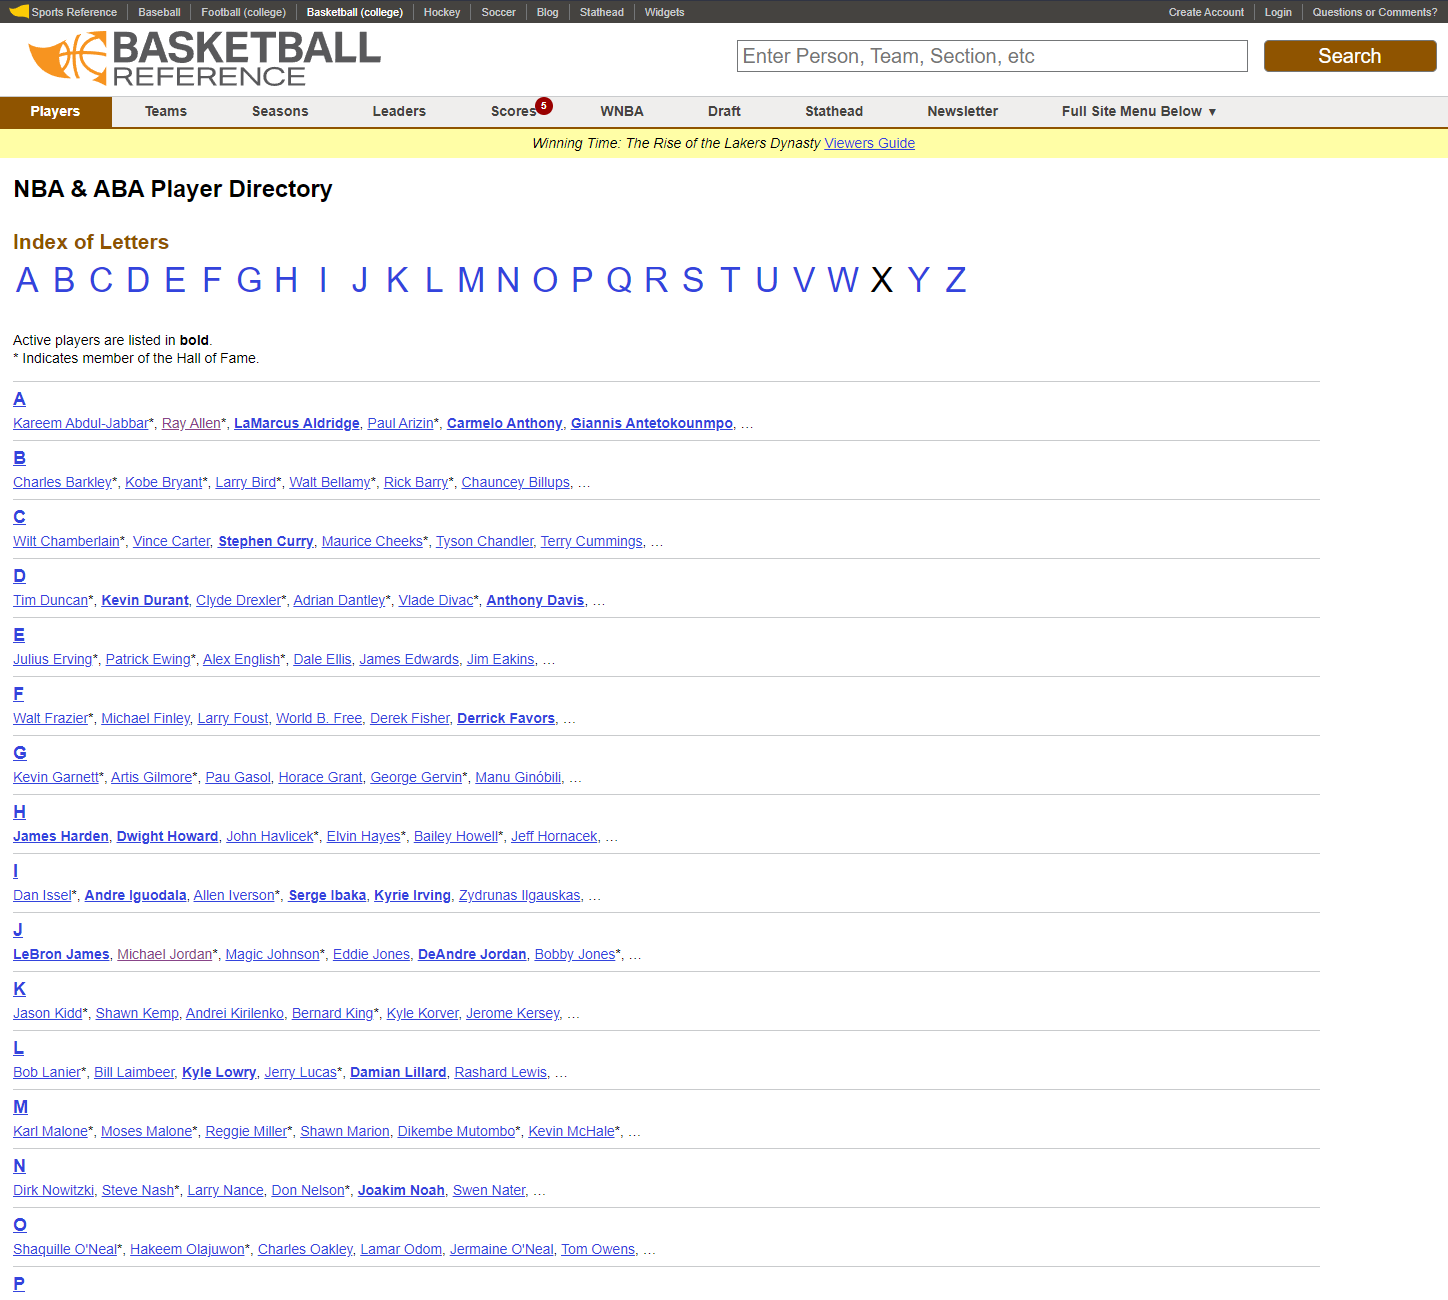

In [2]:
alphabet = list(string.ascii_lowercase)

In [3]:
# create new directories to store downloaded html pages
for letter in alphabet:
    if not os.path.exists('Webpages/Players Directory/{}-players'.format(letter)):
        os.makedirs('Webpages/Players Directory/{}-players'.format(letter))

if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

In [4]:
# download the basketball-reference homepage
urllib.request.urlretrieve('https://www.basketball-reference.com/', 'Webpages/homepage.html')

# download the current players of 2022 page
urllib.request.urlretrieve('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html', 'Webpages/2022-Players.html')

# download the pages corresponding to each players first letter of their last name
for letter in alphabet:
    urllib.request.urlretrieve('https://www.basketball-reference.com/players/{}/'.format(letter), 
                               'Webpages/Players Directory/{}-players-page.html'.format(letter))

In [5]:
players_list, players_names, players_urls, active, duplicate_names = [], [], [], {}, set()

In [6]:
for letter in alphabet:
    players_soup = BeautifulSoup(open('Webpages/Players Directory/{}-players-page.html'.format(letter), encoding="utf8"), 'html.parser')
    li = players_soup.select('div#div_players table#players tbody th[data-stat=player]')
    for link in li:
        players_list.append(link.a.get('href'))
        try:
            player_name = link.strong.get_text()
            players_names.append(player_name)
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # based on site data, bold players are active (even if injured)
            active['{}0{}'.format(player_name, count)] = 1
        except AttributeError:
            player_name = link.get_text().replace('*', '')
            players_names.append(player_name)
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # retired players/unactive players are not bolded
            active['{}0{}'.format(player_name, count)] = 0

duplicate_names.clear()            

# create reference links for each player
for player in players_list:
    players_urls.append('https://www.basketball-reference.com{}'.format(player))

In [7]:
print(len(players_list))
print(len(players_names))
print(len(players_urls))

5020
5020
5020


In [8]:
translate_eng = {'Č':'c', 'Ć': 'c', 'İ':'i', 'Š':'s', 'Ş':'s', 'Ž':'z'}
suffix = ['Jr.', 'Sr.', 'I', 'II', 'III', 'IV', 'V']

def get_last_initial(player_name):
    # there is an exception thrown for one player, so we'll handle with try/except block
    try:
        # handle middle names
        if len(player_name) == 3 and player_name[2] not in suffix:
            return player_name[2][0].lower()
        # handle last names that aren't in english alphabet
        elif player_name[1][0] in translate_eng: 
            return translate_eng.get(player_name[1][0])
        else: return player_name[1][0].lower()
    # Nenê's 'last name' isn't included in web scrape
    except IndexError: 
        if player_name[0] == 'Nenê': return 'h'

In [ ]:
# download all the players pages
i = 0

for player_link in players_urls:
    player_name = players_names[i].split(); print(player_name)
    last_initial = get_last_initial(player_name)
    
    # handle players with same names
    if players_names[i] in duplicate_names: count+=1
    else: count=1; duplicate_names.add(players_names[i])
        
    urllib.request.urlretrieve(player_link, 
                'Webpages/Players Directory/{}-players/{}0{}.html'.format(last_initial, players_names[i], count))
    i+=1
    
duplicate_names.clear()

In [10]:
# extract the stats and place into dataframe
# inits
stats_df_rows = []
awards_dict = {'hof':0, 'all_stars':0, 'score_champs':0, 'rbs_champs':0, 'ast_champs':0, 'stl_champs':0, 'blk_champs':0, 
               'nba_champs':0, 'all_nbas':0, 'most_improved':0, 'sixth_man':0, 'all_rookie':0, 'roy':0, 'all_defs':0, 'as_mvps':0, 
               'dpoys':0, 'mvps':0, 'finals_mvps':0, 'anniv_team':0}
convert_old_teams = {'TOT':'NA', 'NJN':'BRK', 'CHA':'CHO', 'NOK':'NOP', 'CHH':'CHO',
                    'NOH':'NOP', 'PHX':'PHO', 'SEA':'OKC', 'VAN':'MEM', 'WSB':'WAS', 'PHW':'GSW',
                    'SFW':'GSW', 'MNL':'LAL', 'CIN':'SAC', 'KCO':'SAC', 'DNR':'DEN', 'FTW':'DET', 
                     'SDR':'HOU', 'SYR':'PHI'}
stats_dict = {'G':0.0,'PTS':0.0,'TRB':0.0,'AST':0.0,'FG%':0.0,'FG3%':0.0,'FT%':0.0,'eFG%':0.0,
             'PER':0.0,'WS':0.0}

# extract the number or value if award is present within player
def choose_award(awards_list):
    for award in awards_list:
        if 'Hall of Fame' in award: awards_dict['hof'] = 1
        elif 'x All Star' in award: awards_dict['all_stars'] = int(''.join(i for i in award if i.isdigit()))
        elif 'Scoring Champ' in award:
            awards_dict['score_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'TRB Champ' in award:
            awards_dict['rbs_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'AST Champ' in award:
            awards_dict['ast_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'STL Champ' in award:
            awards_dict['stl_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'BLK Champ' in award:
            awards_dict['blk_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA Champ' in award:
            awards_dict['nba_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-NBA' in award or 'All-BAA/NBA' in award:
            awards_dict['all_nbas'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-Rookie' in award: awards_dict['all_rookie'] = 1
        elif 'ROY' in award: awards_dict['roy'] = 1
        elif 'All-Defensive' in award:
            awards_dict['all_defs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Most Improved' in award:
            awards_dict['most_improved'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Sixth Man' in award:
            awards_dict['sixth_man'] = int(''.join(i for i in award if i.isdigit())) if 'x Sixth Man' in award else 1
        elif 'AS MVP' in award:
            awards_dict['as_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Def. POY' in award:
            awards_dict['dpoys'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'MVP' in award:
            if 'Finals' in award: awards_dict['finals_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
            else: awards_dict['mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA 75th Anniv. Team' in award: awards_dict['anniv_team'] = 1
        else: continue # skip all-aba, aba champ, bba, etc (irrelevant to current players)

# get all the list of achivements and awards for player
def get_achivements(link):
    li = link.select("ul[id=bling] > li > a")
    for link in li:
        awards.append(link.get_text())

def get_info(link):
    info = link.find(id='info')
    for line in info.find_all('p'):
        try:
            # use regex to extract hof induction year
            hof_year = re.search('Hall of Fame: Inducted as Player in (\d{4})', line.get_text()).group(1); break
        except AttributeError: hof_year = 0; continue
    return int(hof_year)
    
# extract all years for each player -- note some 
# players get traded during the same season so there are duplicate years
# we'll handle that with a set
def extract_table(link, years, position, teams):
    table = link.find('table')
    if table:
        table_body = table.find('tbody')
        # loop over list of players
        for row in table_body.findAll('tr'):
            try:
                # get some player's pos and team for each year
                year = row.find('a').get_text();
                pos = row.find('td', {'data-stat':'pos'}).get_text();
                team = row.find('td', {'data-stat':'team_id'}).get_text();
                lg = row.find('td', {'data-stat':'lg_id'}).get_text();
                # add year
                if (len(year) <= 7): years.add(int(year[:4]))
                # add positions
                if pos != '': position.append(pos)
                # add main team
                get_team = convert_old_teams.get(team) if team in convert_old_teams else team; print(get_team)
                if get_team == 'NA': 
                    find_teams = row.find('tr', {'class':'light_text partial_table'})
                    multi_team = find_teams.find('td', {'data-stat':'team_id'}).get_text();
                    for team in multi_team: 
                        get_team = convert_old_teams.get(team) if team in convert_old_teams else team
                        teams.append(get_team); print(get_team)
                else:
                    teams.append(get_team)
                if lg != '': league.append(lg)
            except (AttributeError, IndexError):
                continue

# get stats of player
def get_stats(stats):
    for stat in stats.find_all('div'):
        try:
            get_stat = stat.select('p')[1].get_text()
            stats_dict[stat.find('span').strong.get_text()] = get_stat
        # handle out of index error for some players
        except IndexError: return 0
                
# extract each available stat for current player
def extract_player_info(player_link, player_name, awards, years, get_player_map, position, teams, league):
    with open(player_link, 'rb') as html:
        player_link_soup = BeautifulSoup(html)
    
    # extract player awards and accomplishments and place into list
    get_achivements(player_link_soup)
    averages = player_link_soup.find('div', {'class': 'stats_pullout'})
    extract_table(player_link_soup, years, position, teams);
    # sort set and convert to list so we can access first and last years
    years_list = sorted(list(years))
    
    # extract stats and set awards
    name = player_name
    main_pos = mode(position) if len(position) != 0 else 'NA'
    '''
    the team a player is mainly associated with -- this technically isn't correct,
    but we'll infer a player's main team is the team they played the most seasons with
    '''
    asso_team = mode(teams) if len(teams) != 0 else 'NA'
    main_lg = mode(league) if len(league) != 0 else 'NA'
    yoe = len(years)
    debut = years_list[0] if len(years_list) > 0 else 0
    last_active = (years_list[-1] + 1) if yoe >= 1 else 0
    # based on site data, bold players are active (even injured players)
    retired = 1 if active.get(get_player_map) == 0 else 0
    year_inducted = get_info(player_link_soup)
    
    # extract main stats
    get_stats(averages)
    stats_dict.pop('SUMMARY');
    
    # check if players have alteast one award
    if len(awards) != 0:
        choose_award(awards)

    player_stats = {'Player':name, 'Debut':debut, 'Last Active':last_active, 'YOE':yoe, 'Retired':retired, 'Position':main_pos, 
                        'Team':asso_team,'League':main_lg,'Total Games':stats_dict.get('G', 0.0), 'Career PPG':stats_dict.get('PTS', 0.0), 
                        'Career RPG':stats_dict.get('TRB', 0.0), 'Career APG':stats_dict.get('AST', 0.0), 'Career FG%':stats_dict.get('FG%', 0.0), 
                    'Career FG3%':stats_dict.get('FG3%', 0.0), 'Career FT%':stats_dict.get('FT%', 0.0), 'Career eFG%':stats_dict.get('eFG%', 0.0), 
                          'PER':stats_dict.get('PER', 0.0), 'Total WS':stats_dict.get('WS', 0.0),
                          'Hall of Fame':awards_dict.get('hof', 0), 'Year Inducted':year_inducted, 
                          'All-Stars':awards_dict.get('all_stars', 0), 'Scoring Champs':awards_dict.get('score_champs', 0), 
                          'Rebound Champs':awards_dict.get('rbs_champs', 0),
                       'Assist Champs':awards_dict.get('ast_champs', 0), 'Steal Champs':awards_dict.get('stl_champs', 0), 
                          'Block Champs':awards_dict.get('blk_champs', 0), 
                        'NBA Champs':awards_dict.get('nba_champs', 0), 'All-NBA':awards_dict.get('all_nbas', 0), 
                          'All-Rookie':awards_dict.get('all_rookie', 0), 'ROY':awards_dict.get('roy', 0), 
                        'All-Defensive':awards_dict.get('all_defs', 0), 'Most Improved':awards_dict.get('most_improved', 0), 
                          'Sixth Man':awards_dict.get('sixth_man', 0), 'AS MVPs':awards_dict.get('as_mvps', 0), 
                        'DPOYs':awards_dict.get('dpoys', 0), 'MVPs': awards_dict.get('mvps', 0),'Finals MVPs':awards_dict.get('finals_mvps', 0), 
                        'NBA 75th Anniv. Team':awards_dict.get('anniv_team', 0)}
    # add stats awards to list
    stats_df_rows.append(player_stats); print(player_stats)

In [11]:
start = time.process_time()
# go through each player
for player in players_names:
    # years may have duplicates
    awards, years, position, teams, league = [], set(), [], [], []
    global awards_dict; awards_dict = awards_dict.fromkeys(awards_dict, 0); print(player)
    global stats_dict; stats_dict = stats_dict.fromkeys(stats_dict, 0);
    player_name = player.split()
    last_initial = get_last_initial(player_name)
    
    # check for duplicate names
    if player in duplicate_names: count+=1
    else: count=1; duplicate_names.add(player)
    
    # get player identify number
    get_player_map = '{}0{}'.format(player, count)
    extract_player_info('Webpages/Players Directory/{}-players/{}.html'.format(last_initial, get_player_map), 
                        player, awards, years, get_player_map, position, teams, league)

end = time.process_time()
duplicate_names.clear()

Alaa Abdelnaby
POR
POR
NA
MIL
BOS
BOS
NA
SAC
PHI
{'Player': 'Alaa Abdelnaby', 'Debut': 1990, 'Last Active': 1995, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '256', 'Career PPG': '5.7', 'Career RPG': '3.3', 'Career APG': '0.3', 'Career FG%': '50.2', 'Career FG3%': '0.0', 'Career FT%': '70.1', 'Career eFG%': '50.2', 'PER': '13.0', 'Total WS': '4.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zaid Abdul-Aziz
NA
SAC
MIL
MIL
OKC
OKC
HOU
HOU
HOU
OKC
BUF
NA
BOS
HOU
{'Player': 'Zaid Abdul-Aziz', 'Debut': 1968, 'Last Active': 1978, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '505', 'Career PPG': '9.0', 

NYK
{'Player': 'Don Ackerman', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '28', 'Career PPG': '1.5', 'Career RPG': '0.5', 'Career APG': '0.8', 'Career FG%': '22.2', 'Career FG3%': 0, 'Career FT%': '53.6', 'Career eFG%': 0, 'PER': '1.0', 'Total WS': '-0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mark Acres
BOS
BOS
ORL
ORL
ORL
NA
HOU
WAS
{'Player': 'Mark Acres', 'Debut': 1987, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '375', 'Career PPG': '3.6', 'Career RPG': '4.1', 'Career APG': '0.5', 'Career FG%': '50.6', 'Career FG3%': '53.8', 'Car

{'Player': 'Steven Adams', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '664', 'Career PPG': '9.3', 'Career RPG': '8.0', 'Career APG': '1.5', 'Career FG%': '58.7', 'Career FG3%': '7.1', 'Career FT%': '54.7', 'Career eFG%': '58.7', 'PER': '17.0', 'Total WS': '56.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rafael Addison
PHO
BRK
BRK
DET
CHO
CHO
{'Player': 'Rafael Addison', 'Debut': 1986, 'Last Active': 1997, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '379', 'Career PPG': '5.8', 'Career RPG': '2.1', 'Career APG': '0.9', 'Career FG%': '44.9', 'Career FG3%': '28.

CHO
CHO
NA
DAL
TOR
NOP
NOP
NOP
NOP
{'Player': 'Alexis Ajinça', 'Debut': 2008, 'Last Active': 2017, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '293', 'Career PPG': '5.3', 'Career RPG': '3.9', 'Career APG': '0.5', 'Career FG%': '50.3', 'Career FG3%': '28.6', 'Career FT%': '79.7', 'Career eFG%': '50.7', 'PER': '14.9', 'Total WS': '7.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Henry Akin
NYK
OKC
KEN
{'Player': 'Henry Akin', 'Debut': 1966, 'Last Active': 1969, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '88', 'Career PPG': '3.5', 'Career RPG': '2.1', 'Career APG': '0.5', 'Career FG%': '35.0', 'Car

{'Player': 'Cliff Alexander', 'Debut': 2015, 'Last Active': 2016, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.3', 'Career RPG': '0.8', 'Career APG': '0.0', 'Career FG%': '50.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '50.0', 'PER': '11.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cory Alexander
SAS
SAS
NA
SAS
DEN
DEN
DEN
ORL
CHO
{'Player': 'Cory Alexander', 'Debut': 1995, 'Last Active': 2005, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '307', 'Career PPG': '5.5', 'Career RPG': '1.6', 'Career APG': '2.7', 'Career FG%': '38.9', 'Career FG3%

{'Player': 'Bill Allen', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'ANA', 'League': 'ABA', 'Total Games': '38', 'Career PPG': '7.9', 'Career RPG': '7.1', 'Career APG': '0.6', 'Career FG%': '42.9', 'Career FG3%': '100.0', 'Career FT%': '58.6', 'Career eFG%': '43.2', 'PER': '11.9', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Allen
GSW
{'Player': 'Bob Allen', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '27', 'Career PPG': '1.8', 'Career RPG': '2.1', 'Career APG': '0.4', 'Career FG%': '32.6', 'Career FG3%': 0, 'Career FT%': '55.6', 'Career eFG%

{'Player': 'Odis Allison', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '36', 'Career PPG': '1.9', 'Career RPG': '1.3', 'Career APG': '0.3', 'Career FG%': '21.8', 'Career FG3%': 0, 'Career FT%': '54.1', 'Career eFG%': 0, 'PER': '4.7', 'Total WS': '-0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lance Allred
CLE
{'Player': 'Lance Allred', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '1.0', 'Career RPG': '0.3', 'Career APG': '0.0', 'Career FG%': '25.0', 'Career FG3%': '-', 'Career FT%': '50.0', 'Career eFG%':

DEN
DEN
DEN
NOP
NOP
NOP
DEN
DEN
DEN
DEN
MIA
MIA
MIA
NA
MIA
MEM
CLE
{'Player': 'Chris Andersen', 'Debut': 2001, 'Last Active': 2017, 'YOE': 15, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '695', 'Career PPG': '5.4', 'Career RPG': '5.0', 'Career APG': '0.5', 'Career FG%': '53.2', 'Career FG3%': '22.1', 'Career FT%': '65.4', 'Career eFG%': '53.5', 'PER': '16.7', 'Total WS': '39.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
David Andersen
HOU
NA
TOR
NOP
{'Player': 'David Andersen', 'Debut': 2009, 'Last Active': 2011, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '103', 'Career PPG': '4.9', 'Career RPG': '2.8', 

SAS
SAS
NA
SAS
HOU
PHI
SAC
{'Player': 'James Anderson', 'Debut': 2010, 'Last Active': 2016, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '247', 'Career PPG': '5.8', 'Career RPG': '2.3', 'Career APG': '1.2', 'Career FG%': '41.1', 'Career FG3%': '32.1', 'Career FT%': '75.5', 'Career eFG%': '48.8', 'PER': '9.9', 'Total WS': '3.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jerome Anderson
BOS
IND
{'Player': 'Jerome Anderson', 'Debut': 1975, 'Last Active': 1977, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '2.6', 'Career RPG': '0.5', 'Career APG': '0.3', 'Career FG%': '49.0', 'Care

UTA
UTA
UTA
HOU
HOU
NYK
NYK
NYK
NA
NYK
MIA
MIA
{'Player': 'Shandon Anderson', 'Debut': 1996, 'Last Active': 2006, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '719', 'Career PPG': '7.4', 'Career RPG': '3.1', 'Career APG': '1.4', 'Career FG%': '45.7', 'Career FG3%': '31.6', 'Career FT%': '73.9', 'Career eFG%': '49.2', 'PER': '11.7', 'Total WS': '23.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Anderson
SAS
SAS
SAS
SAS
SAS
SAS
SAS
NA
TOR
NYK
MIA
{'Player': 'Willie Anderson', 'Debut': 1988, 'Last Active': 1997, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '555', 'Career PPG': '12.2', 'Career

NYK
NYK
NYK
NYK
MEM
MEM
OKC
POR
POR
POR
NA
CHI
MIL
{'Player': 'Greg Anthony', 'Debut': 1991, 'Last Active': 2002, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '757', 'Career PPG': '7.3', 'Career RPG': '1.9', 'Career APG': '4.0', 'Career FG%': '40.3', 'Career FG3%': '34.9', 'Career FT%': '73.3', 'Career eFG%': '46.7', 'PER': '14.5', 'Total WS': '35.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joel Anthony
MIA
MIA
MIA
MIA
MIA
MIA
NA
MIA
BOS
DET
DET
SAS
{'Player': 'Joel Anthony', 'Debut': 2007, 'Last Active': 2017, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '490', 'Career PPG': '2.2', 'Career RP

NYK
NA
NYK
ORL
ORL
NA
ORL
LAL
LAL
HOU
NOP
NOP
WAS
WAS
HOU
HOU
HOU
HOU
NA
PHO
WAS
NA
SAC
POR
MIA
LAL
{'Player': 'Trevor Ariza', 'Debut': 2004, 'Last Active': 2022, 'YOE': 18, 'Retired': 0, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '1118', 'Career PPG': '10.4', 'Career RPG': '4.8', 'Career APG': '2.1', 'Career FG%': '42.2', 'Career FG3%': '35.1', 'Career FT%': '73.1', 'Career eFG%': '50.4', 'PER': '13.1', 'Total WS': '64.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Paul Arizin
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
{'Player': 'Paul Arizin', 'Debut': 1950, 'Last Active': 1962, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Gam

NYA
SAC
INA
INA
{'Player': 'Bob Arnzen', 'Debut': 1969, 'Last Active': 1974, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'INA', 'League': 'ABA', 'Total Games': '111', 'Career PPG': '4.0', 'Career RPG': '2.0', 'Career APG': '0.3', 'Career FG%': '46.5', 'Career FG3%': '20.0', 'Career FT%': '80.0', 'Career eFG%': '46.6', 'PER': '13.6', 'Total WS': '1.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carlos Arroyo
NA
TOR
DEN
UTA
UTA
NA
UTA
DET
NA
DET
ORL
ORL
ORL
MIA
NA
MIA
BOS
{'Player': 'Carlos Arroyo', 'Debut': 2001, 'Last Active': 2011, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '569', 'Career PPG': '6.6', 'Career RPG': '1.7', 'Career A

DTF
{'Player': 'Chet Aubuchon', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DTF', 'League': 'BAA', 'Total Games': '30', 'Career PPG': '2.2', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '25.3', 'Career FG3%': 0, 'Career FT%': '54.3', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stacey Augmon
ATL
ATL
ATL
ATL
ATL
NA
DET
POR
POR
POR
POR
POR
CHO
NOP
NOP
ORL
ORL
{'Player': 'Stacey Augmon', 'Debut': 1991, 'Last Active': 2006, 'YOE': 15, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '1001', 'Career PPG': '8.0', 'Career RPG': '3.2', 'Career APG': '1.6', 'Career 

NOP
NA
ORL
MIL
ATL
{'Player': 'Gustavo Ayón', 'Debut': 2011, 'Last Active': 2014, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '135', 'Career PPG': '4.7', 'Career RPG': '4.4', 'Career APG': '1.3', 'Career FG%': '53.6', 'Career FG3%': '0.0', 'Career FT%': '50.4', 'Career eFG%': '53.6', 'PER': '14.7', 'Total WS': '5.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff Ayres
POR
IND
IND
SAS
SAS
LAC
{'Player': 'Jeff Ayres', 'Debut': 2009, 'Last Active': 2016, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'IND', 'League': 'NBA', 'Total Games': '237', 'Career PPG': '2.9', 'Career RPG': '2.7', 'Career APG': '0.4', 'Career FG%': '55.3', 'Career FG

CLE
CLE
CLE
CLE
CLE
BRK
BRK
BOS
BOS
BOS
ATL
{'Player': 'John Bagley', 'Debut': 1982, 'Last Active': 1994, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '665', 'Career PPG': '8.7', 'Career RPG': '2.6', 'Career APG': '6.0', 'Career FG%': '43.7', 'Career FG3%': '24.1', 'Career FT%': '77.9', 'Career eFG%': '44.8', 'PER': '13.0', 'Total WS': '16.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marvin Bagley III
SAC
SAC
SAC
NA
SAC
DET
{'Player': 'Marvin Bagley III', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '166', 'Career PPG': '13.6', 'Career RPG': '7.4', 'Career AP

NYK
NYK
NA
NYK
WAS
{'Player': 'Ron Baker', 'Debut': 2016, 'Last Active': 2019, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '96', 'Career PPG': '3.1', 'Career RPG': '1.4', 'Career APG': '1.8', 'Career FG%': '35.8', 'Career FG3%': '26.5', 'Career FT%': '70.7', 'Career eFG%': '41.7', 'PER': '7.4', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vin Baker
MIL
MIL
MIL
MIL
OKC
OKC
OKC
OKC
OKC
BOS
NA
BOS
NYK
NA
NYK
HOU
LAC
{'Player': 'Vin Baker', 'Debut': 1993, 'Last Active': 2006, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '791', 'Career PPG': '15.0', 'Career RPG': '7.4', 'Career APG':

{'Player': 'Gene Banks', 'Debut': 1981, 'Last Active': 1987, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '468', 'Career PPG': '11.3', 'Career RPG': '5.8', 'Career APG': '2.9', 'Career FG%': '53.9', 'Career FG3%': '4.3', 'Career FT%': '73.0', 'Career eFG%': '53.9', 'PER': '15.1', 'Total WS': '31.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marcus Banks
BOS
BOS
NA
BOS
MIN
PHO
NA
PHO
MIA
NA
MIA
TOR
TOR
TOR
{'Player': 'Marcus Banks', 'Debut': 2003, 'Last Active': 2011, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '348', 'Career PPG': '5.9', 'Career RPG': '1.5', 'Career APG': '2.1', 'Career FG%': '4

INO
INO
INO
{'Player': 'Cliff Barker', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'INO', 'League': 'NBA', 'Total Games': '149', 'Career PPG': '3.7', 'Career RPG': '1.8', 'Career APG': '2.0', 'Career FG%': '31.6', 'Career FG3%': 0, 'Career FT%': '66.2', 'Career eFG%': 0, 'PER': '10.8', 'Total WS': '2.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Barker
ATL
NA
HOU
BOS
NYK
{'Player': 'Tom Barker', 'Debut': 1976, 'Last Active': 1979, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '98', 'Career PPG': '6.5', 'Career RPG': '5.3', 'Career APG': '0.8', 'Career FG%': '42.2', 'Career FG3%': 0, 'Career FT%':

INA
{'Player': 'Nathaniel Barnett', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'INA', 'League': 'ABA', 'Total Games': '12', 'Career PPG': '2.3', 'Career RPG': '0.7', 'Career APG': '0.7', 'Career FG%': '46.2', 'Career FG3%': '0.0', 'Career FT%': '37.5', 'Career eFG%': '46.2', 'PER': '4.9', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Barnhill
STL
STL
STL
NA
STL
DET
BAL
HOU
BAL
INA
NA
INA
DEN
INA
{'Player': 'John Barnhill', 'Debut': 1962, 'Last Active': 1972, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'STL', 'League': 'NBA', 'Total Games': '589', 'Career PPG': '8.6', 'Career RPG': '2.5', 'Career APG': '2.9', 'Care

OKC
OKC
OKC
OKC
PHI
PHI
BOS
BOS
BOS
BOS
BOS
DET
DET
BOS
{'Player': 'Dana Barros', 'Debut': 1989, 'Last Active': 2004, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '850', 'Career PPG': '10.5', 'Career RPG': '1.9', 'Career APG': '3.3', 'Career FG%': '46.0', 'Career FG3%': '41.1', 'Career FT%': '85.8', 'Career eFG%': '53.6', 'PER': '16.4', 'Total WS': '49.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brent Barry
LAC
LAC
NA
LAC
MIA
CHI
OKC
OKC
OKC
OKC
OKC
SAS
SAS
SAS
SAS
HOU
{'Player': 'Brent Barry', 'Debut': 1995, 'Last Active': 2009, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '912', 'Career PPG

SDA
SDA
NYA
NYN
BRK
BRK
NA
BRK
SAS
{'Player': 'Tim Bassett', 'Debut': 1973, 'Last Active': 1980, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '473', 'Career PPG': '6.2', 'Career RPG': '6.7', 'Career APG': '1.2', 'Career FG%': '42.3', 'Career FG3%': '28.6', 'Career FT%': '58.8', 'Career eFG%': '42.4', 'PER': '10.2', 'Total WS': '12.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Charles Bassey
PHI
{'Player': 'Charles Bassey', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '3.0', 'Career RPG': '2.7', 'Career APG': '0.3', 'Career FG%': '63.8', 'Car

VIR
{'Player': 'Lloyd Batts', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'VIR', 'League': 'ABA', 'Total Games': '58', 'Career PPG': '10.3', 'Career RPG': '3.4', 'Career APG': '1.8', 'Career FG%': '36.6', 'Career FG3%': '28.6', 'Career FT%': '61.7', 'Career eFG%': '39.7', 'PER': '11.3', 'Total WS': '-0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nicolas Batum
POR
POR
POR
POR
POR
POR
POR
CHO
CHO
CHO
CHO
CHO
LAC
LAC
{'Player': 'Nicolas Batum', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '915', 'Career PPG': '11.1', 'Career RPG': '5.1', 'Career APG': '3.5', 'Car

NA
LAL
TRI
{'Player': 'Ed Beach', 'Debut': 1950, 'Last Active': 1951, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '12', 'Career PPG': '1.8', 'Career RPG': '2.1', 'Career APG': '0.3', 'Career FG%': '21.1', 'Career FG3%': 0, 'Career FT%': '66.7', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bradley Beal
WAS
WAS
WAS
WAS
WAS
WAS
WAS
WAS
WAS
WAS
{'Player': 'Bradley Beal', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '645', 'Career PPG': '22.1', 'Career RPG': '4.1', 'Career APG': '4.2', 'Career FG%': '45.6', 'Career FG

DEN
DEN
DEN
DEN
DEN
DEN
DEN
DNA
DNA
DEN
{'Player': 'Byron Beck', 'Debut': 1967, 'Last Active': 1977, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '747', 'Career PPG': '11.5', 'Career RPG': '7.0', 'Career APG': '1.3', 'Career FG%': '50.5', 'Career FG3%': '29.5', 'Career FT%': '81.1', 'Career eFG%': '50.5', 'PER': '16.3', 'Total WS': '55.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Corey Beck
CHO
CHO
NA
DET
CHO
{'Player': 'Corey Beck', 'Debut': 1995, 'Last Active': 1999, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '88', 'Career PPG': '2.7', 'Career RPG': '1.4', 'Career APG': '1.4', 'Career FG%': 

GSW
GSW
NA
MIN
MEM
NA
WAS
GSW
CHI
{'Player': 'Jordan Bell', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '161', 'Career PPG': '3.7', 'Career RPG': '3.1', 'Career APG': '1.2', 'Career FG%': '55.2', 'Career FG3%': '20.0', 'Career FT%': '63.6', 'Career eFG%': '55.6', 'PER': '15.0', 'Total WS': '4.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Raja Bell
PHI
PHI
DAL
UTA
UTA
PHO
PHO
PHO
NA
PHO
CHO
NA
CHO
GSW
UTA
UTA
{'Player': 'Raja Bell', 'Debut': 2000, 'Last Active': 2012, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '706', 'Career PPG': '9.9', 'Career RPG': '2.8', 

CLE
MIN
TOR
BRK
{'Player': 'Anthony Bennett', 'Debut': 2013, 'Last Active': 2017, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '151', 'Career PPG': '4.4', 'Career RPG': '3.1', 'Career APG': '0.5', 'Career FG%': '39.2', 'Career FG3%': '26.1', 'Career FT%': '67.0', 'Career eFG%': '42.0', 'PER': '10.2', 'Total WS': '0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Elmer Bennett
CLE
PHI
NA
HOU
DEN
{'Player': 'Elmer Bennett', 'Debut': 1994, 'Last Active': 1997, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '21', 'Career PPG': '2.3', 'Career RPG': '0.5', 'Career APG': '1.0', 'Career FG%': '34.0', 'Career

{'Player': 'Gene Berce', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '3.3', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '31.3', 'Career FG3%': 0, 'Career FT%': '0.0', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Bergen
NYK
{'Player': 'Gary Bergen', 'Debut': 1956, 'Last Active': 1957, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '6', 'Career PPG': '1.3', 'Career RPG': '1.3', 'Career APG': '0.2', 'Career FG%': '27.3', 'Career FG3%': 0, 'Career FT%': '100.0', 'Career eFG%': 0, 'PER':

{'Player': 'Wesley Bialosuknia', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'OAK', 'League': 'ABA', 'Total Games': '70', 'Career PPG': '8.7', 'Career RPG': '1.3', 'Career APG': '0.8', 'Career FG%': '41.8', 'Career FG3%': '39.7', 'Career FT%': '78.0', 'Career eFG%': '44.3', 'PER': '12.9', 'Total WS': '1.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Bianchi
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
{'Player': 'Al Bianchi', 'Debut': 1956, 'Last Active': 1966, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '687', 'Career PPG': '8.1', 'Career RPG': '2.5', 'Career APG': '2.2', 'Career FG%': '37.4', 'Car

POR
{'Player': 'Joe Binion', 'Debut': 1986, 'Last Active': 1987, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '1.3', 'Career RPG': '1.6', 'Career APG': '0.1', 'Career FG%': '40.0', 'Career FG3%': '-', 'Career FT%': '60.0', 'Career eFG%': '40.0', 'PER': '12.0', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Khem Birch
ORL
ORL
ORL
NA
ORL
TOR
TOR
{'Player': 'Khem Birch', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '261', 'Career PPG': '5.2', 'Career RPG': '4.6', 'Career APG': '1.0', 'Career FG%': '51.8', 'Career FG3%': '19.1', 'Ca

DET
{'Player': 'Norman Black', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '2.7', 'Career RPG': '0.7', 'Career APG': '0.7', 'Career FG%': '30.0', 'Career FG3%': '-', 'Career FT%': '25.0', 'Career eFG%': '30.0', 'PER': '1.9', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tarik Black
NA
HOU
LAL
LAL
LAL
HOU
{'Player': 'Tarik Black', 'Debut': 2014, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '220', 'Career PPG': '4.9', 'Career RPG': '4.7', 'Career APG': '0.5', 'Career FG%': '55.0', 'Career FG3%': '14.3', 'Car

DET
DET
MIN
{'Player': 'Lance Blanks', 'Debut': 1990, 'Last Active': 1993, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '142', 'Career PPG': '2.0', 'Career RPG': '0.8', 'Career APG': '0.8', 'Career FG%': '43.6', 'Career FG3%': '25.3', 'Career FT%': '66.7', 'Career eFG%': '47.2', 'PER': '8.8', 'Total WS': '0.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ricky Blanton
CHI
{'Player': 'Ricky Blanton', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '3.0', 'Career RPG': '1.5', 'Career APG': '0.5', 'Career FG%': '42.9', 'Career FG3%': '-', 'Career FT%

CHI
{'Player': 'Ray Blume', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '4.6', 'Career RPG': '0.8', 'Career APG': '1.4', 'Career FG%': '45.9', 'Career FG3%': '22.2', 'Career FT%': '64.3', 'Career eFG%': '46.8', 'PER': '9.7', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nelson Bobb
GSW
GSW
GSW
GSW
{'Player': 'Nelson Bobb', 'Debut': 1949, 'Last Active': 1953, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '227', 'Career PPG': '4.6', 'Career RPG': '2.4', 'Career APG': '2.1', 'Career FG%': '35.0', 'Career FG3%': 0, 'Career FT%': 

WAS
WAS
WAS
GSW
GSW
PHI
PHI
PHI
NA
MIA
WAS
PHI
GSW
{'Player': 'Manute Bol', 'Debut': 1985, 'Last Active': 1995, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '624', 'Career PPG': '2.6', 'Career RPG': '4.2', 'Career APG': '0.3', 'Career FG%': '40.7', 'Career FG3%': '21.0', 'Career FT%': '56.1', 'Career eFG%': '42.0', 'PER': '9.4', 'Total WS': '12.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 2, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jonah Bolden
PHI
NA
PHI
PHO
{'Player': 'Jonah Bolden', 'Debut': 2018, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '4.3', 'Career RPG': '3.4', 'Career APG': '0.8', 'Caree

LAL
WAS
WAS
TOR
{'Player': 'Isaac Bonga', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '143', 'Career PPG': '3.1', 'Career RPG': '2.2', 'Career APG': '0.8', 'Career FG%': '43.2', 'Career FG3%': '30.0', 'Career FT%': '75.9', 'Career eFG%': '48.6', 'PER': '8.4', 'Total WS': '1.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ron Bonham
BOS
BOS
INA
{'Player': 'Ron Bonham', 'Debut': 1964, 'Last Active': 1968, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '118', 'Career PPG': '6.1', 'Career RPG': '1.4', 'Career APG': '0.4', 'Career FG%': '38.8', 'Career FG3%': '0.0', 'C

SAC
SAC
SAC
NA
SAC
NYK
NYK
LAL
CHI
CHI
CHI
OKC
MIL
{'Player': 'Bob Boozer', 'Debut': 1960, 'Last Active': 1971, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '874', 'Career PPG': '14.8', 'Career RPG': '8.1', 'Career APG': '1.4', 'Career FG%': '46.2', 'Career FG3%': 0, 'Career FT%': '76.1', 'Career eFG%': 0, 'PER': '16.1', 'Total WS': '64.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carlos Boozer
CLE
CLE
UTA
UTA
UTA
UTA
UTA
UTA
CHI
CHI
CHI
CHI
LAL
{'Player': 'Carlos Boozer', 'Debut': 2002, 'Last Active': 2015, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '861', 'Career PPG': '16.2', 'Career RPG'

{'Player': 'Chris Boucher', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PF', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '230', 'Career PPG': '8.9', 'Career RPG': '5.3', 'Career APG': '0.5', 'Career FG%': '48.4', 'Career FG3%': '33.4', 'Career FT%': '78.4', 'Career eFG%': '55.2', 'PER': '20.0', 'Total WS': '16.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Bouknight
CHO
{'Player': 'James Bouknight', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '30', 'Career PPG': '4.7', 'Career RPG': '1.7', 'Career APG': '0.9', 'Career FG%': '34.5', 'Career FG3%': '34.7', 'Career FT%'

GSW
{'Player': 'Ky Bowman', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '45', 'Career PPG': '7.4', 'Career RPG': '2.7', 'Career APG': '2.9', 'Career FG%': '41.7', 'Career FG3%': '30.8', 'Career FT%': '82.9', 'Career eFG%': '46.9', 'PER': '9.1', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nate Bowman
CHI
NYK
NYK
NYK
BUF
PTC
{'Player': 'Nate Bowman', 'Debut': 1966, 'Last Active': 1972, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '261', 'Career PPG': '2.9', 'Career RPG': '3.4', 'Career APG': '0.7', 'Career FG%': '38.8', 'Career FG3%': '0.0', 'Ca

BAL
BAL
OAK
OAK
WSA
NA
CAR
TEX
{'Player': 'Gary Bradds', 'Debut': 1964, 'Last Active': 1971, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'BAL', 'League': 'ABA', 'Total Games': '254', 'Career PPG': '12.2', 'Career RPG': '5.5', 'Career APG': '0.9', 'Career FG%': '47.5', 'Career FG3%': '5.6', 'Career FT%': '79.8', 'Career eFG%': '47.5', 'PER': '18.8', 'Total WS': '15.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alex Bradley
NYK
{'Player': 'Alex Bradley', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '39', 'Career PPG': '3.5', 'Career RPG': '1.7', 'Career APG': '0.3', 'Career FG%': '52.4', 'Career FG3%

PHI
{'Player': 'Mark Bradtke', 'Debut': 1996, 'Last Active': 1997, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '36', 'Career PPG': '1.6', 'Career RPG': '1.9', 'Career APG': '0.2', 'Career FG%': '43.1', 'Career FG3%': '-', 'Career FT%': '69.2', 'Career eFG%': '43.1', 'PER': '9.6', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marques Bragg
MIN
{'Player': 'Marques Bragg', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '53', 'Career PPG': '2.5', 'Career RPG': '1.5', 'Career APG': '0.2', 'Career FG%': '45.0', 'Career FG3%': '-', 'Career FT%': '56.1', '

PHO
PHO
PHO
CLE
SAS
CHI
GSW
GSW
SAC
{'Player': 'Mike Bratz', 'Debut': 1977, 'Last Active': 1986, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '586', 'Career PPG': '7.0', 'Career RPG': '1.8', 'Career APG': '3.2', 'Career FG%': '40.7', 'Career FG3%': '30.5', 'Career FT%': '83.0', 'Career eFG%': '42.6', 'PER': '12.0', 'Total WS': '11.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carl Braun
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
BOS
{'Player': 'Carl Braun', 'Debut': 1947, 'Last Active': 1962, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '788', 'Career PPG': '13.5', 'Career RPG': '3.4', 'Car

UTA
UTA
UTA
NA
UTA
MEM
CHI
CHI
NA
NYK
OKC
NA
HOU
CHI
{'Player': 'Ronnie Brewer', 'Debut': 2006, 'Last Active': 2014, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '502', 'Career PPG': '7.8', 'Career RPG': '2.8', 'Career APG': '1.6', 'Career FG%': '49.0', 'Career FG3%': '25.4', 'Career FT%': '67.5', 'Career eFG%': '50.5', 'PER': '14.4', 'Total WS': '30.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Primož Brezec
IND
IND
IND
CHO
CHO
CHO
NA
CHO
DET
TOR
NA
PHI
MIL
{'Player': 'Primož Brezec', 'Debut': 2001, 'Last Active': 2010, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '342', 'Career PPG': '7.2', 'Car

{'Player': 'John Brisker', 'Debut': 1969, 'Last Active': 1975, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'ABA', 'Total Games': '331', 'Career PPG': '20.7', 'Career RPG': '6.5', 'Career APG': '2.4', 'Career FG%': '45.3', 'Career FG3%': '32.1', 'Career FT%': '83.4', 'Career eFG%': '46.7', 'PER': '20.1', 'Total WS': '22.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Oshae Brissett
TOR
IND
IND
{'Player': 'Oshae Brissett', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '106', 'Career PPG': '8.0', 'Career RPG': '4.6', 'Career APG': '0.9', 'Career FG%': '42.2', 'Career FG3%': '35.6', 'Care

INJ
ROC
{'Player': 'Price Brookfield', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'INJ', 'League': 'BAA', 'Total Games': '61', 'Career PPG': '7.8', 'Career RPG': '-', 'Career APG': '2.2', 'Career FG%': '28.3', 'Career FG3%': 0, 'Career FT%': '73.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Clarence Brookins
FLO
{'Player': 'Clarence Brookins', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'FLO', 'League': 'ABA', 'Total Games': '8', 'Career PPG': '2.6', 'Career RPG': '1.5', 'Career APG': '0.1', 'Career FG%': '30.8', 'Career FG3%': '0.0', 'Career FT%': '4

NA
SAC
MIN
NA
NOP
LAC
HOU
HOU
{'Player': 'Bobby Brown', 'Debut': 2008, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '158', 'Career PPG': '4.4', 'Career RPG': '0.7', 'Career APG': '1.5', 'Career FG%': '37.9', 'Career FG3%': '31.7', 'Career FT%': '80.6', 'Career eFG%': '44.6', 'PER': '8.9', 'Total WS': '-1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bruce Brown
DET
DET
BRK
BRK
{'Player': 'Bruce Brown', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '268', 'Career PPG': '7.6', 'Career RPG': '4.3', 'Career APG': '2.1', 'Career FG%': '48.1', 'Ca

OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
{'Player': 'Fred Brown', 'Debut': 1971, 'Last Active': 1984, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '963', 'Career PPG': '14.6', 'Career RPG': '2.7', 'Career APG': '3.3', 'Career FG%': '47.8', 'Career FG3%': '37.3', 'Career FT%': '85.8', 'Career eFG%': '48.2', 'PER': '17.7', 'Total WS': '63.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Brown
LAL
{'Player': 'George Brown', 'Debut': 1957, 'Last Active': 1958, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%':

{'Player': 'Lewis Brown', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': '-', 'Career FT%': '40.0', 'Career eFG%': '0.0', 'PER': '-18.6', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lorenzo Brown
PHI
MIN
PHO
TOR
TOR
{'Player': 'Lorenzo Brown', 'Debut': 2013, 'Last Active': 2019, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '103', 'Career PPG': '2.8', 'Career RPG': '1.5', 'Career APG': '1.8', 'Career FG%': '36.4', 'Career FG3%': '17.0', 'Career 

LAL
CAR
NA
SAA
VIR
DNA
DET
DET
CHI
{'Player': 'Roger Brown', 'Debut': 1972, 'Last Active': 1980, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '239', 'Career PPG': '2.4', 'Career RPG': '3.5', 'Career APG': '0.5', 'Career FG%': '40.6', 'Career FG3%': '100.0', 'Career FT%': '62.4', 'Career eFG%': '40.8', 'PER': '8.7', 'Total WS': '2.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Shannon Brown
CLE
NA
CLE
CHI
NA
CHO
LAL
LAL
LAL
PHO
PHO
NA
SAS
NYK
MIA
{'Player': 'Shannon Brown', 'Debut': 2006, 'Last Active': 2015, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '408', 'Career PPG': '7.6', 'Career RPG': '1.9

TOR
CHI
LAC
NA
OKC
HOU
{'Player': 'Rick Brunson', 'Debut': 1997, 'Last Active': 2006, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '337', 'Career PPG': '3.2', 'Career RPG': '1.3', 'Career APG': '2.6', 'Career FG%': '37.8', 'Career FG3%': '36.2', 'Career FT%': '69.3', 'Career eFG%': '42.6', 'PER': '10.7', 'Total WS': '3.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nicolás Brussino
DAL
ATL
{'Player': 'Nicolás Brussino', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '58', 'Career PPG': '2.6', 'Career RPG': '1.7', 'Career APG': '0.8', 'Career FG%': '36.4', 'Career 

{'Player': 'Joe Buckhalter', 'Debut': 1961, 'Last Active': 1963, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '65', 'Career PPG': '5.8', 'Career RPG': '4.1', 'Career APG': '0.7', 'Career FG%': '45.1', 'Career FG3%': 0, 'Career FT%': '62.7', 'Career eFG%': 0, 'PER': '14.3', 'Total WS': '1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Bucknall
LAL
{'Player': 'Steve Bucknall', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '18', 'Career PPG': '1.3', 'Career RPG': '0.4', 'Career APG': '0.6', 'Career FG%': '27.3', 'Career FG3%': '0.0', 'Career FT%': '83.3', 'Car

{'Player': 'Greg Bunch', 'Debut': 1978, 'Last Active': 1979, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '12', 'Career PPG': '2.3', 'Career RPG': '1.4', 'Career APG': '0.3', 'Career FG%': '34.6', 'Career FG3%': 0, 'Career FT%': '83.3', 'Career eFG%': 0, 'PER': '9.2', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Bunt
NA
NYK
BLB
{'Player': 'Dick Bunt', 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '26', 'Career PPG': '3.5', 'Career RPG': '1.1', 'Career APG': '0.7', 'Career FG%': '27.6', 'Career FG3%': 0, 'Career FT%': '70.8', 'Career eFG%': 0

{'Player': 'David Burns', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '2.6', 'Career RPG': '0.6', 'Career APG': '1.7', 'Career FG%': '43.8', 'Career FG3%': '-', 'Career FT%': '60.0', 'Career eFG%': '43.8', 'PER': '3.6', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Evers Burns
SAC
{'Player': 'Evers Burns', 'Debut': 1993, 'Last Active': 1994, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '2.4', 'Career RPG': '1.3', 'Career APG': '0.4', 'Career FG%': '40.0', 'Career FG3%': '-', 'Career FT%': '52.2', 'Career e

NYK
NYK
NA
NYK
DET
DET
DET
{'Player': 'Donnie Butcher', 'Debut': 1961, 'Last Active': 1966, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '279', 'Career PPG': '6.1', 'Career RPG': '2.9', 'Career APG': '2.1', 'Career FG%': '39.7', 'Career FG3%': 0, 'Career FT%': '62.9', 'Career eFG%': 0, 'PER': '10.3', 'Total WS': '4.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Butler
NA
BOS
NYK
NYK
NYK
BAL
{'Player': 'Al Butler', 'Debut': 1961, 'Last Active': 1965, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '234', 'Career PPG': '9.8', 'Career RPG': '3.0', 'Career APG': '2.3', 'Career FG%': '43.9', 'Career FG

GSW
DET
DET
DET
DET
DET
DET
WAS
{'Player': 'Will Bynum', 'Debut': 2005, 'Last Active': 2015, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '360', 'Career PPG': '8.1', 'Career RPG': '1.6', 'Career APG': '3.3', 'Career FG%': '44.2', 'Career FG3%': '27.2', 'Career FT%': '79.9', 'Career eFG%': '45.8', 'PER': '14.6', 'Total WS': '7.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Walter Byrd
MMF
{'Player': 'Walter Byrd', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MMF', 'League': 'ABA', 'Total Games': '22', 'Career PPG': '1.5', 'Career RPG': '1.1', 'Career APG': '0.3', 'Career FG%': '32.6', 'Career FG3%': 

{'Player': 'Nick Calathes', 'Debut': 2013, 'Last Active': 2015, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '129', 'Career PPG': '4.6', 'Career RPG': '1.9', 'Career APG': '2.7', 'Career FG%': '44.1', 'Career FG3%': '28.8', 'Career FT%': '58.1', 'Career eFG%': '46.8', 'PER': '12.3', 'Total WS': '2.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
José Calderón
TOR
TOR
TOR
TOR
TOR
TOR
TOR
NA
TOR
DET
DAL
NYK
NYK
NA
LAL
ATL
CLE
DET
{'Player': 'José Calderón', 'Debut': 2005, 'Last Active': 2019, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '895', 'Career PPG': '8.9', 'Career RPG': '2.4', 'Career APG': '

SAS
DEN
DEN
UTA
CLE
{'Player': 'Mack Calvin', 'Debut': 1969, 'Last Active': 1981, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'FLO', 'League': 'ABA', 'Total Games': '755', 'Career PPG': '16.1', 'Career RPG': '2.5', 'Career APG': '4.8', 'Career FG%': '44.7', 'Career FG3%': '24.5', 'Career FT%': '86.3', 'Career eFG%': '45.1', 'PER': '17.4', 'Total WS': '60.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dexter Cambridge
DAL
{'Player': 'Dexter Cambridge', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '53', 'Career PPG': '7.0', 'Career RPG': '3.2', 'Career APG': '1.1', 'Career FG%': '48.4', 'Career FG3%'

MNP
WSA
NA
VIR
CAR
NA
CAR
DEN
DEN
{'Player': 'Frank Card', 'Debut': 1968, 'Last Active': 1973, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'CAR', 'League': 'ABA', 'Total Games': '306', 'Career PPG': '9.5', 'Career RPG': '5.6', 'Career APG': '1.2', 'Career FG%': '46.1', 'Career FG3%': '17.6', 'Career FT%': '63.2', 'Career eFG%': '46.1', 'PER': '12.3', 'Total WS': '11.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Cardinal
DET
DET
WAS
GSW
MEM
MEM
MEM
MEM
MIN
MIN
DAL
DAL
{'Player': 'Brian Cardinal', 'Debut': 2000, 'Last Active': 2012, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '456', 'Career PPG': '4.6', 'Career RPG': '2.3', 'Ca

ATL
ATL
ATL
ATL
ATL
NA
ATL
SAC
SAC
SAS
SAS
SAS
UTA
UTA
UTA
UTA
HOU
MEM
{'Player': 'Antoine Carr', 'Debut': 1984, 'Last Active': 2000, 'YOE': 16, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '987', 'Career PPG': '9.3', 'Career RPG': '3.4', 'Career APG': '1.1', 'Career FG%': '50.3', 'Career FG3%': '13.0', 'Career FT%': '78.0', 'Career eFG%': '50.3', 'PER': '14.2', 'Total WS': '42.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Austin Carr
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
NA
DAL
WAS
{'Player': 'Austin Carr', 'Debut': 1971, 'Last Active': 1981, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '682', 'Career PPG'

MIL
{'Player': 'Jimmy Carruth', 'Debut': 1996, 'Last Active': 1997, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.3', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '66.7', 'Career FG3%': '-', 'Career FT%': '100.0', 'Career eFG%': '66.7', 'PER': '9.7', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Anthony Carter
MIA
MIA
MIA
MIA
SAS
MIN
MIN
DEN
DEN
DEN
DEN
NA
DEN
NYK
TOR
{'Player': 'Anthony Carter', 'Debut': 1999, 'Last Active': 2012, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '623', 'Career PPG': '4.8', 'Career RPG': '2.1', 'Career APG': '3.8', 'Car

PHI
NA
PHI
MIL
MIL
CHI
CHO
NA
HOU
ORL
ORL
ORL
{'Player': 'Michael Carter-Williams', 'Debut': 2013, 'Last Active': 2021, 'YOE': 8, 'Retired': 0, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '391', 'Career PPG': '10.3', 'Career RPG': '4.4', 'Career APG': '4.4', 'Career FG%': '40.2', 'Career FG3%': '25.5', 'Career FT%': '70.6', 'Career eFG%': '42.6', 'PER': '13.5', 'Total WS': '6.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Cartwright
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
CHI
CHI
CHI
CHI
CHI
CHI
OKC
{'Player': 'Bill Cartwright', 'Debut': 1979, 'Last Active': 1995, 'YOE': 15, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '963', 'Career

UTA
BRK
{'Player': 'Bobby Cattage', 'Debut': 1981, 'Last Active': 1986, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '78', 'Career PPG': '3.1', 'Career RPG': '1.4', 'Career APG': '0.1', 'Career FG%': '40.4', 'Career FG3%': '14.3', 'Career FT%': '76.5', 'Career eFG%': '40.6', 'PER': '10.2', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Cauley-Stein
SAC
SAC
SAC
SAC
NA
GSW
DAL
DAL
NA
DAL
PHI
{'Player': 'Willie Cauley-Stein', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '422', 'Career PPG': '8.7', 'Career RPG': '5.9', 'Career APG': '1.4', 'Care

GSW
GSW
GSW
GSW
GSW
NA
GSW
PHI
PHI
PHI
PHI
LAL
LAL
LAL
LAL
LAL
{'Player': 'Wilt Chamberlain', 'Debut': 1959, 'Last Active': 1973, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '1045', 'Career PPG': '30.1', 'Career RPG': '22.9', 'Career APG': '4.4', 'Career FG%': '54.0', 'Career FG3%': 0, 'Career FT%': '51.1', 'Career eFG%': 0, 'PER': '26.2', 'Total WS': '247.3', 'Hall of Fame': 1, 'Year Inducted': 1979, 'All-Stars': 13, 'Scoring Champs': 7, 'Rebound Champs': 11, 'Assist Champs': 1, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 10, 'All-Rookie': 0, 'ROY': 1, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 4, 'Finals MVPs': 1, 'NBA 75th Anniv. Team': 1}
Jerry Chambers
LAL
PHO
ATL
BUF
SDA
SAA
{'Player': 'Jerry Chambers', 'Debut': 1966, 'Last Active': 1974, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '320', 'Career PPG': '8.3', 'Career RPG': 

PHI
NA
PHI
NYK
NYK
NYK
NA
CHI
SAC
NA
SAC
DET
MIL
MIL
NA
CLE
ATL
DLC
{'Player': 'Len Chappell', 'Debut': 1962, 'Last Active': 1972, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '670', 'Career PPG': '9.3', 'Career RPG': '5.1', 'Career APG': '0.8', 'Career FG%': '45.2', 'Career FG3%': '-', 'Career FT%': '69.7', 'Career eFG%': '45.2', 'PER': '15.6', 'Total WS': '21.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ken Charles
BUF
BUF
BUF
ATL
ATL
{'Player': 'Ken Charles', 'Debut': 1973, 'Last Active': 1978, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '322', 'Career PPG': '8.5', 'Career RPG': '2.0', 'Car

POR
NA
POR
DET
{'Player': 'Randolph Childress', 'Debut': 1995, 'Last Active': 1997, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '2.4', 'Career RPG': '0.5', 'Career APG': '1.0', 'Career FG%': '32.8', 'Career FG3%': '27.3', 'Career FT%': '80.0', 'Career eFG%': '40.3', 'PER': '5.9', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Childs
BRK
BRK
NYK
NYK
NYK
NYK
NA
NYK
TOR
TOR
BRK
{'Player': 'Chris Childs', 'Debut': 1994, 'Last Active': 2003, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '541', 'Career PPG': '6.9', 'Career RPG': '2.4', 'Career APG': '4.9', 'Care

{'Player': 'Josh Christopher', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '73', 'Career PPG': '8.0', 'Career RPG': '2.5', 'Career APG': '2.0', 'Career FG%': '44.9', 'Career FG3%': '30.1', 'Career FT%': '74.3', 'Career eFG%': '50.6', 'PER': '12.3', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Patrick Christopher
UTA
{'Player': 'Patrick Christopher', 'Debut': 2014, 'Last Active': 2015, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.5', 'Career RPG': '1.5', 'Career APG': '0.0', 'Career FG%': '25.0', 'Career FG3%': '0.0', 'Care

LAL
LAL
LAL
NA
LAL
CLE
CLE
NA
CLE
UTA
UTA
UTA
{'Player': 'Jordan Clarkson', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '599', 'Career PPG': '15.4', 'Career RPG': '3.3', 'Career APG': '2.5', 'Career FG%': '44.0', 'Career FG3%': '33.9', 'Career FT%': '82.7', 'Career eFG%': '50.7', 'PER': '15.7', 'Total WS': '21.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gian Clavell
DAL
{'Player': 'Gian Clavell', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '2.9', 'Career RPG': '1.0', 'Career APG': '0.4', 'Career FG%': '

AND
GSW
DET
{'Player': 'Bill Closs', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'AND', 'League': 'NBA', 'Total Games': '186', 'Career PPG': '9.0', 'Career RPG': '5.0', 'Career APG': '1.9', 'Career FG%': '31.5', 'Career FG3%': 0, 'Career FT%': '71.8', 'Career eFG%': 0, 'PER': '10.5', 'Total WS': '7.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keith Closs
LAC
LAC
LAC
{'Player': 'Keith Closs', 'Debut': 1997, 'Last Active': 2000, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '130', 'Career PPG': '3.9', 'Career RPG': '2.9', 'Career APG': '0.3', 'Career FG%': '47.1', 'Career FG3%': '0.0', 'Career FT%': '

ROC
ROC
ROC
ROC
ROC
ROC
NA
ROC
STL
STL
STL
{'Player': 'Jack Coleman', 'Debut': 1949, 'Last Active': 1958, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': '633', 'Career PPG': '10.6', 'Career RPG': '9.2', 'Career APG': '2.8', 'Career FG%': '41.6', 'Career FG3%': 0, 'Career FT%': '69.5', 'Career eFG%': 0, 'PER': '15.8', 'Total WS': '47.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Norris Coleman
LAC
{'Player': 'Norris Coleman', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '29', 'Career PPG': '5.3', 'Career RPG': '2.8', 'Career APG': '0.4', 'Career FG%': '34.6', 'Car

CHO
{'Player': 'Sherron Collins', 'Debut': 2010, 'Last Active': 2011, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '20', 'Career PPG': '0.9', 'Career RPG': '0.3', 'Career APG': '0.4', 'Career FG%': '28.0', 'Career FG3%': '20.0', 'Career FT%': '100.0', 'Career eFG%': '32.0', 'PER': '3.6', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zach Collins
POR
POR
POR
SAS
{'Player': 'Zach Collins', 'Debut': 2017, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': '181', 'Career PPG': '6.0', 'Career RPG': '4.2', 'Career APG': '1.1', 'Career FG%': '45.0', 'Career FG3%': '32.7', '

{'Player': 'Larry Comley', 'Debut': 1963, 'Last Active': 1964, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '12', 'Career PPG': '2.1', 'Career RPG': '1.6', 'Career APG': '1.0', 'Career FG%': '21.6', 'Career FG3%': 0, 'Career FT%': '56.3', 'Career eFG%': 0, 'PER': '5.6', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeffrey Congdon
NA
ANA
DEN
DEN
DEN
NA
UTS
NYA
DLC
{'Player': 'Jeffrey Congdon', 'Debut': 1967, 'Last Active': 1972, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '306', 'Career PPG': '6.5', 'Career RPG': '2.0', 'Career APG': '3.3', 'Career FG%': '37.7', 'Career FG3%': '2

NYK
{'Player': 'Bert Cook', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '37', 'Career PPG': '3.2', 'Career RPG': '1.9', 'Career APG': '0.9', 'Career FG%': '31.6', 'Career FG3%': 0, 'Career FT%': '68.0', 'Career eFG%': 0, 'PER': '8.7', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Cook
SHE
{'Player': 'Bobby Cook', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '11.5', 'Career RPG': '-', 'Career APG': '3.1', 'Career FG%': '35.8', 'Career FG3%': 0, 'Career FT%': '79.0', 'Career eFG%': 0, '

{'Player': 'Joe Cooke', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '73', 'Career PPG': '4.3', 'Career RPG': '1.6', 'Career APG': '1.3', 'Career FG%': '39.3', 'Career FG3%': 0, 'Career FT%': '81.4', 'Career eFG%': 0, 'PER': '10.4', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jack Cooley
UTA
SAC
{'Player': 'Jack Cooley', 'Debut': 2014, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '2.9', 'Career RPG': '2.4', 'Career APG': '0.3', 'Career FG%': '44.9', 'Career FG3%': '-', 'Career FT%': '57.5', 'Career eFG%'

{'Player': 'Lanard Copeland', 'Debut': 1989, 'Last Active': 1992, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '33', 'Career PPG': '2.7', 'Career RPG': '0.5', 'Career APG': '0.4', 'Career FG%': '41.8', 'Career FG3%': '14.3', 'Career FT%': '81.3', 'Career eFG%': '42.3', 'PER': '8.2', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tyrone Corbin
SAS
NA
SAS
CLE
NA
CLE
PHO
PHO
MIN
MIN
NA
MIN
UTA
UTA
UTA
ATL
NA
SAC
MIA
ATL
ATL
ATL
SAC
TOR
{'Player': 'Tyrone Corbin', 'Debut': 1985, 'Last Active': 2001, 'YOE': 16, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '1065', 'Career PPG': '9.2', 'Career RPG'

GSW
{'Player': 'John Coughran', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '2.8', 'Career RPG': '0.8', 'Career APG': '0.5', 'Career FG%': '35.8', 'Career FG3%': '22.2', 'Career FT%': '57.1', 'Career eFG%': '37.0', 'PER': '6.0', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mel Counts
BOS
BOS
NA
BAL
LAL
LAL
LAL
LAL
PHO
PHO
NA
PHI
LAL
LAL
NOJ
NOJ
{'Player': 'Mel Counts', 'Debut': 1964, 'Last Active': 1976, 'YOE': 12, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '789', 'Career PPG': '8.3', 'Career RPG': '6.0', 'Career APG': '1.4', 'Caree

DEN
DEN
DEN
NA
MIL
PHO
NA
IND
PHO
{'Player': 'Torrey Craig', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '299', 'Career PPG': '5.7', 'Career RPG': '3.6', 'Career APG': '0.9', 'Career FG%': '45.7', 'Career FG3%': '33.1', 'Career FT%': '69.3', 'Career eFG%': '54.0', 'PER': '11.1', 'Total WS': '10.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Crawford
ATL
ATL
ATL
ATL
ATL
ATL
ATL
{'Player': 'Chris Crawford', 'Debut': 1997, 'Last Active': 2004, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '252', 'Career PPG': '6.6', 'Career RPG': '2.2', 'Career APG': '0.6', '

{'Player': 'Winston Crite', 'Debut': 1987, 'Last Active': 1989, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '31', 'Career PPG': '2.8', 'Career RPG': '2.1', 'Career APG': '0.5', 'Career FG%': '47.9', 'Career FG3%': '-', 'Career FT%': '76.0', 'Career eFG%': '47.9', 'PER': '9.1', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Javaris Crittenton
NA
LAL
MEM
NA
MEM
WAS
{'Player': 'Javaris Crittenton', 'Debut': 2007, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '113', 'Career PPG': '5.3', 'Career RPG': '2.4', 'Career APG': '1.8', 'Career FG%': '44.2', 'Career FG3%': '

{'Player': 'Mark Crow', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '15', 'Career PPG': '5.6', 'Career RPG': '1.8', 'Career APG': '0.5', 'Career FG%': '43.8', 'Career FG3%': 0, 'Career FT%': '70.0', 'Career eFG%': 0, 'PER': '12.7', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Corey Crowder
UTA
SAS
{'Player': 'Corey Crowder', 'Debut': 1991, 'Last Active': 1995, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '58', 'Career PPG': '2.1', 'Career RPG': '0.8', 'Career APG': '0.3', 'Career FG%': '36.9', 'Career FG3%': '38.2', 'Career FT%': '70.8', 'Caree

DAL
NA
ATL
SAC
LAC
NA
CLE
MIL
{'Player': 'Jared Cunningham', 'Debut': 2012, 'Last Active': 2016, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '84', 'Career PPG': '2.3', 'Career RPG': '0.7', 'Career APG': '0.5', 'Career FG%': '34.7', 'Career FG3%': '30.6', 'Career FT%': '67.4', 'Career eFG%': '40.2', 'PER': '6.8', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
William Cunningham
NA
UTA
PHI
NA
TOR
BRK
{'Player': 'William Cunningham', 'Debut': 1997, 'Last Active': 1999, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '0.6', 'Career RPG': '1.7', 'Career APG': '0.1', 'Car

GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
{'Player': 'Stephen Curry', 'Debut': 2009, 'Last Active': 2022, 'YOE': 13, 'Retired': 0, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '826', 'Career PPG': '24.3', 'Career RPG': '4.6', 'Career APG': '6.5', 'Career FG%': '47.3', 'Career FG3%': '42.8', 'Career FT%': '90.8', 'Career eFG%': '58.1', 'PER': '23.8', 'Total WS': '120.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 8, 'Scoring Champs': 2, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 1, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 7, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 2, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Rastko Cvetković
DEN
{'Player': 'Rastko Cvetković', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '14', 'Career PPG': '0.7', 'Career RPG': '0.8', 'Career APG': '0.2', '

SAS
SAS
NA
PHI
LAL
NA
SAC
BRK
TOR
{'Player': 'Lloyd Daniels', 'Debut': 1992, 'Last Active': 1998, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '200', 'Career PPG': '7.1', 'Career RPG': '2.2', 'Career APG': '1.6', 'Career FG%': '40.3', 'Career FG3%': '31.6', 'Career FT%': '74.3', 'Career eFG%': '45.8', 'PER': '11.5', 'Total WS': '3.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marquis Daniels
DAL
DAL
DAL
IND
IND
IND
BOS
BOS
BOS
MIL
{'Player': 'Marquis Daniels', 'Debut': 2003, 'Last Active': 2013, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '548', 'Career PPG': '7.9', 'Career RPG': '2.8', 'Career

{'Player': 'Nate Darling', 'Debut': 2020, 'Last Active': 2021, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '1.3', 'Career RPG': '0.1', 'Career APG': '0.1', 'Career FG%': '28.6', 'Career FG3%': '28.6', 'Career FT%': '100.0', 'Career eFG%': '42.9', 'PER': '8.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rick Darnell
VIR
{'Player': 'Rick Darnell', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'VIR', 'League': 'ABA', 'Total Games': '11', 'Career PPG': '2.4', 'Career RPG': '3.3', 'Career APG': '0.8', 'Career FG%': '36.7', 'Career FG3%': '-', 'Career FT%': '57.1', 'Car

CHO
CHO
CHO
NOP
NOP
NA
NOP
GSW
GSW
GSW
GSW
LAC
LAC
NA
LAC
CLE
NYK
{'Player': 'Baron Davis', 'Debut': 1999, 'Last Active': 2012, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '835', 'Career PPG': '16.1', 'Career RPG': '3.8', 'Career APG': '7.2', 'Career FG%': '40.9', 'Career FG3%': '32.0', 'Career FT%': '71.1', 'Career eFG%': '46.5', 'PER': '17.8', 'Total WS': '63.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 2, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ben Davis
PHO
NYK
NYK
PHO
{'Player': 'Ben Davis', 'Debut': 1996, 'Last Active': 2000, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '40', 'Career PPG': '1.4', 'Career RPG': '1.3', 'Career APG'

BOS
BOS
BOS
BOS
ORL
ORL
NA
ORL
LAC
LAC
{'Player': 'Glen Davis', 'Debut': 2007, 'Last Active': 2015, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '514', 'Career PPG': '8.0', 'Career RPG': '4.4', 'Career APG': '0.9', 'Career FG%': '44.7', 'Career FG3%': '18.2', 'Career FT%': '70.0', 'Career eFG%': '44.8', 'PER': '12.4', 'Total WS': '18.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Harry Davis
CLE
SAS
{'Player': 'Harry Davis', 'Debut': 1978, 'Last Active': 1980, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '44', 'Career PPG': '4.0', 'Career RPG': '1.6', 'Career APG': '0.4', 'Career FG%': '43.6', 'Ca

NYK
{'Player': 'Mike Davis', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.8', 'Career RPG': '1.3', 'Career APG': '0.0', 'Career FG%': '40.0', 'Career FG3%': '-', 'Career FT%': '60.0', 'Career eFG%': '40.0', 'PER': '21.1', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Monti Davis
NA
PHI
DAL
{'Player': 'Monti Davis', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.5', 'Career RPG': '2.0', 'Career APG': '0.0', 'Career FG%': '20.0', 'Career FG3%': '-', 'Career FT%': '20.0', 

TEX
{'Player': 'Willie Davis', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'TEX', 'League': 'ABA', 'Total Games': '8', 'Career PPG': '2.3', 'Career RPG': '1.6', 'Career APG': '0.3', 'Career FG%': '46.7', 'Career FG3%': '-', 'Career FT%': '50.0', 'Career eFG%': '46.7', 'PER': '16.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andre Dawkins
MIA
{'Player': 'Andre Dawkins', 'Debut': 2014, 'Last Active': 2015, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '0.8', 'Career RPG': '0.5', 'Career APG': '0.3', 'Career FG%': '16.7', 'Career FG3%': '16.7', 'Career FT%': '-', '

{'Player': 'Darren Daye', 'Debut': 1983, 'Last Active': 1988, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '328', 'Career PPG': '6.8', 'Career RPG': '2.6', 'Career APG': '2.0', 'Career FG%': '49.1', 'Career FG3%': '11.8', 'Career FT%': '68.1', 'Career eFG%': '49.1', 'PER': '13.9', 'Total WS': '9.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nando De Colo
SAS
NA
SAS
TOR
{'Player': 'Nando De Colo', 'Debut': 2012, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '119', 'Career PPG': '3.8', 'Career RPG': '1.8', 'Career APG': '1.7', 'Career FG%': '42.9', 'Career FG3%': '36.3', 'Career

NA
SAC
ATL
MIA
MIA
{'Player': 'Dewayne Dedmon', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '477', 'Career PPG': '6.4', 'Career RPG': '5.9', 'Career APG': '0.7', 'Career FG%': '52.7', 'Career FG3%': '33.8', 'Career FT%': '73.5', 'Career eFG%': '56.6', 'PER': '15.1', 'Total WS': '22.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Dee
INA
{'Player': 'Don Dee', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'INA', 'League': 'ABA', 'Total Games': '58', 'Career PPG': '5.7', 'Career RPG': '5.0', 'Career APG': '0.6', 'Career FG%': '35.7', 'Career FG3%': '0.0', 'Career FT

CHO
NA
CHO
GSW
GSW
SAC
PHO
NA
PHO
BOS
BOS
DAL
ATL
NA
ATL
DET
{'Player': 'Tony Delk', 'Debut': 1996, 'Last Active': 2006, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '545', 'Career PPG': '9.1', 'Career RPG': '2.5', 'Career APG': '1.9', 'Career FG%': '40.8', 'Career FG3%': '34.3', 'Career FT%': '76.9', 'Career eFG%': '45.9', 'PER': '13.7', 'Total WS': '19.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matthew Dellavedova
CLE
CLE
CLE
MIL
MIL
NA
MIL
CLE
CLE
CLE
{'Player': 'Matthew Dellavedova', 'Debut': 2013, 'Last Active': 2021, 'YOE': 8, 'Retired': 0, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '447', 'Career PPG': '5.5

{'Player': 'Marcus Derrickson', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '4.2', 'Career RPG': '1.2', 'Career APG': '0.1', 'Career FG%': '48.5', 'Career FG3%': '50.0', 'Career FT%': '80.0', 'Career eFG%': '63.6', 'PER': '19.4', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dave Deutsch
NYK
{'Player': 'Dave Deutsch', 'Debut': 1966, 'Last Active': 1967, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '1.1', 'Career RPG': '1.1', 'Career APG': '0.8', 'Career FG%': '16.7', 'Career FG3%': 0, 'Career FT%': '45.0',

POR
BRK
CLE
{'Player': 'Kaniel Dickens', 'Debut': 2003, 'Last Active': 2008, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '1.2', 'Career RPG': '0.6', 'Career APG': '0.1', 'Career FG%': '40.0', 'Career FG3%': '33.3', 'Career FT%': '75.0', 'Career eFG%': '47.5', 'PER': '9.0', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Henry Dickerson
DET
ATL
{'Player': 'Henry Dickerson', 'Debut': 1975, 'Last Active': 1977, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '2.0', 'Career RPG': '0.2', 'Career APG': '0.8', 'Career FG%': '36.6', 'Career FG3%': 0, 'Ca

{'Player': 'Dwaine Dillard', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'UTS', 'League': 'ABA', 'Total Games': '3', 'Career PPG': '1.3', 'Career RPG': '3.0', 'Career APG': '0.7', 'Career FG%': '33.3', 'Career FG3%': '-', 'Career FT%': '100.0', 'Career eFG%': '33.3', 'PER': '7.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mickey Dillard
CLE
{'Player': 'Mickey Dillard', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '33', 'Career PPG': '2.2', 'Career RPG': '0.5', 'Career APG': '1.0', 'Career FG%': '36.7', 'Career FG3%': '0.0', 'Career FT%': '65.2'

MLH
{'Player': 'Fred Diute', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MLH', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '1.6', 'Career RPG': '1.9', 'Career APG': '0.6', 'Career FG%': '9.5', 'Career FG3%': 0, 'Career FT%': '58.3', 'Career eFG%': 0, 'PER': '-2.3', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vlade Divac
LAL
LAL
LAL
LAL
LAL
LAL
LAL
CHO
CHO
SAC
SAC
SAC
SAC
SAC
SAC
LAL
{'Player': 'Vlade Divac', 'Debut': 1989, 'Last Active': 2005, 'YOE': 16, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '1134', 'Career PPG': '11.8', 'Career RPG': '8.2', 'Career APG': '3.1', 'Career FG%': 

{'Player': 'Harry Donovan', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '45', 'Career PPG': '5.6', 'Career RPG': '-', 'Career APG': '0.8', 'Career FG%': '32.7', 'Career FG3%': 0, 'Career FT%': '68.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keyon Dooling
LAC
LAC
LAC
LAC
MIA
ORL
ORL
ORL
BRK
BRK
MIL
BOS
MEM
{'Player': 'Keyon Dooling', 'Debut': 2000, 'Last Active': 2013, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '728', 'Career PPG': '7.0', 'Career RPG': '1.3', 'Career APG': '2.2', 'Career FG%': '41.6', 'Caree

SDC
SDC
{'Player': 'John Douglas', 'Debut': 1981, 'Last Active': 1983, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'SDC', 'League': 'NBA', 'Total Games': '67', 'Career PPG': '6.7', 'Career RPG': '1.4', 'Career APG': '2.2', 'Career FG%': '46.1', 'Career FG3%': '31.1', 'Career FT%': '66.3', 'Career eFG%': '48.5', 'PER': '12.0', 'Total WS': '0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Leon Douglas
DET
DET
DET
DET
KCK
KCK
KCK
{'Player': 'Leon Douglas', 'Debut': 1976, 'Last Active': 1983, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '456', 'Career PPG': '7.9', 'Career RPG': '6.5', 'Career APG': '1.1', 'Career FG%': '49.5', 'Career FG3%

{'Player': 'Danny Doyle', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '4.0', 'Career RPG': '2.0', 'Career APG': '0.8', 'Career FG%': '50.0', 'Career FG3%': 0, 'Career FT%': '80.0', 'Career eFG%': 0, 'PER': '22.2', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Milton Doyle
BRK
{'Player': 'Milton Doyle', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '10', 'Career PPG': '3.4', 'Career RPG': '1.8', 'Career APG': '1.0', 'Career FG%': '27.7', 'Career FG3%': '17.4', 'Career FT%': '50.0', 'Career eFG

DET
BAL
NA
BAL
MIL
MIL
MIL
SSL
{'Player': 'Terry Driscoll', 'Debut': 1970, 'Last Active': 1975, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '274', 'Career PPG': '4.1', 'Career RPG': '4.1', 'Career APG': '0.8', 'Career FG%': '41.9', 'Career FG3%': '-', 'Career FT%': '69.4', 'Career eFG%': '41.9', 'PER': '10.9', 'Total WS': '5.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Predrag Drobnjak
OKC
OKC
LAC
ATL
{'Player': 'Predrag Drobnjak', 'Debut': 2001, 'Last Active': 2005, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '278', 'Career PPG': '7.9', 'Career RPG': '3.5', 'Career APG': '0.8', 'Career FG%': '

{'Player': 'Terry Duerod', 'Debut': 1979, 'Last Active': 1983, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '143', 'Career PPG': '6.7', 'Career RPG': '1.1', 'Career APG': '1.2', 'Career FG%': '46.2', 'Career FG3%': '32.9', 'Career FT%': '67.2', 'Career eFG%': '47.5', 'PER': '12.1', 'Total WS': '1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Duffy
NA
CHS
BOS
{'Player': 'Bob Duffy', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': '17', 'Career PPG': '1.1', 'Career RPG': '-', 'Career APG': '0.0', 'Career FG%': '21.9', 'Career FG3%': 0, 'Career FT%': '71.4', 'Car

SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
{'Player': 'Tim Duncan', 'Debut': 1997, 'Last Active': 2016, 'YOE': 19, 'Retired': 1, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '1392', 'Career PPG': '19.0', 'Career RPG': '10.8', 'Career APG': '3.0', 'Career FG%': '50.6', 'Career FG3%': '17.9', 'Career FT%': '69.6', 'Career eFG%': '50.7', 'PER': '24.2', 'Total WS': '206.4', 'Hall of Fame': 1, 'Year Inducted': 2020, 'All-Stars': 15, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 5, 'All-NBA': 15, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 15, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 2, 'Finals MVPs': 3, 'NBA 75th Anniv. Team': 1}
Mike Dunleavy
PHI
NA
PHI
HOU
HOU
HOU
HOU
HOU
SAS
MIL
MIL
MIL
MIL
{'Player': 'Mike Dunleavy', 'Debut': 1976, 'Last Active': 1990, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games':

{'Player': 'Devin Durrant', 'Debut': 1984, 'Last Active': 1986, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '63', 'Career PPG': '5.0', 'Career RPG': '2.1', 'Career APG': '1.3', 'Career FG%': '41.4', 'Career FG3%': '0.0', 'Career FT%': '68.9', 'Career eFG%': '41.4', 'PER': '8.6', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ken Durrett
SAC
SAC
SAC
NA
SAC
PHI
{'Player': 'Ken Durrett', 'Debut': 1971, 'Last Active': 1975, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '120', 'Career PPG': '4.0', 'Career RPG': '1.9', 'Career APG': '0.5', 'Career FG%': '43.4', 'Career FG3%': 0, 'Career 

KEN
{'Player': 'Penny Early', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '-', 'PER': '-', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mark Eaton
UTA
UTA
UTA
UTA
UTA
UTA
UTA
UTA
UTA
UTA
UTA
{'Player': 'Mark Eaton', 'Debut': 1982, 'Last Active': 1993, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '875', 'Career PPG': '6.0', 'Career RPG': '7.9', 'Career APG': '1.0', 'Career FG%': '45.8', 'Career FG3%': '0.0'

{'Player': 'Charles Edge', 'Debut': 1973, 'Last Active': 1975, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'MMT', 'League': 'ABA', 'Total Games': '155', 'Career PPG': '7.7', 'Career RPG': '6.3', 'Career APG': '0.7', 'Career FG%': '50.2', 'Career FG3%': '0.0', 'Career FT%': '63.2', 'Career eFG%': '50.2', 'PER': '16.3', 'Total WS': '6.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Edmonds
INA
INA
{'Player': 'Bobby Edmonds', 'Debut': 1967, 'Last Active': 1970, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'INA', 'League': 'ABA', 'Total Games': '75', 'Career PPG': '7.7', 'Career RPG': '5.0', 'Career APG': '0.4', 'Career FG%': '43.4', 'Career FG3%': '16.7', 'Career FT%': '

IND
ATL
{'Player': 'John Edwards', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'IND', 'League': 'NBA', 'Total Games': '65', 'Career PPG': '1.5', 'Career RPG': '1.0', 'Career APG': '0.1', 'Career FG%': '44.7', 'Career FG3%': '-', 'Career FT%': '60.0', 'Career eFG%': '44.7', 'PER': '6.0', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kessler Edwards
BRK
{'Player': 'Kessler Edwards', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '47', 'Career PPG': '5.8', 'Career RPG': '3.6', 'Career APG': '0.7', 'Career FG%': '40.8', 'Career FG3%': '35.6', 'Career FT%'

CHI
{'Player': 'Khalid El-Amin', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '50', 'Career PPG': '6.3', 'Career RPG': '1.6', 'Career APG': '2.9', 'Career FG%': '37.0', 'Career FG3%': '33.3', 'Career FT%': '77.8', 'Career eFG%': '41.5', 'PER': '12.2', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Eliason
BOS
{'Player': 'Don Eliason', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '-', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': 0, 'Career FT%': '-', 'Career

GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
{'Player': 'Joe Ellis', 'Debut': 1966, 'Last Active': 1974, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '524', 'Career PPG': '8.8', 'Career RPG': '5.1', 'Career APG': '1.4', 'Career FG%': '39.8', 'Career FG3%': 0, 'Career FT%': '72.7', 'Career eFG%': 0, 'PER': '12.1', 'Total WS': '5.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
LaPhonso Ellis
DEN
DEN
DEN
DEN
DEN
DEN
ATL
ATL
MIN
MIA
MIA
{'Player': 'LaPhonso Ellis', 'Debut': 1992, 'Last Active': 2003, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '624', 'Career PPG': '11.9', 'Career RPG': '6.5', 'Career APG': '1.6',

SAC
SAC
SAC
SAC
SAC
SAC
SAC
SAC
BOS
BOS
MIL
{'Player': 'Wayne Embry', 'Debut': 1958, 'Last Active': 1969, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '831', 'Career PPG': '12.5', 'Career RPG': '9.1', 'Career APG': '1.4', 'Career FG%': '44.0', 'Career FG3%': 0, 'Career FT%': '64.0', 'Career eFG%': 0, 'PER': '15.1', 'Total WS': '37.8', 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andre Emmett
MEM
BRK
{'Player': 'Andre Emmett', 'Debut': 2004, 'Last Active': 2012, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '14', 'Career PPG': '1.4', 'Career RPG': '0.6', 'Career APG': '0.1', 'Career FG%': '46.2', 'Car

MIA
NA
MIA
MEM
NOP
MEM
NA
MEM
DET
NA
HOU
PHI
NA
PHI
ORL
ORL
NA
BRK
LAC
DEN
{'Player': 'James Ennis III', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '395', 'Career PPG': '6.7', 'Career RPG': '3.3', 'Career APG': '0.9', 'Career FG%': '45.7', 'Career FG3%': '36.0', 'Career FT%': '79.7', 'Career eFG%': '53.7', 'PER': '11.7', 'Total WS': '16.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tyler Ennis
NA
PHO
MIL
MIL
NA
HOU
LAL
LAL
{'Player': 'Tyler Ennis', 'Debut': 2014, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '186', 'Career PPG': '4.2', 'Ca

{'Player': 'Bob Evans', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'NBA', 'Total Games': '47', 'Career PPG': '3.0', 'Career RPG': '-', 'Career APG': '1.2', 'Career FG%': '28.0', 'Career FG3%': 0, 'Career FT%': '68.2', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Evans
ORL
NA
ORL
BRK
NA
BRK
MIN
{'Player': 'Brian Evans', 'Debut': 1996, 'Last Active': 1999, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '102', 'Career PPG': '3.7', 'Career RPG': '1.6', 'Career APG': '0.8', 'Career FG%': '38.1', 'Career FG3%': '34.3', 'Career FT%': '82

UTA
UTA
UTA
UTA
NA
UTA
CLE
CLE
{'Player': 'Dante Exum', 'Debut': 2014, 'Last Active': 2021, 'YOE': 6, 'Retired': 0, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '245', 'Career PPG': '5.7', 'Career RPG': '1.8', 'Career APG': '2.1', 'Career FG%': '40.7', 'Career FG3%': '30.5', 'Career FT%': '76.4', 'Career eFG%': '47.3', 'PER': '8.3', 'Total WS': '3.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Christian Eyenga
CLE
NA
CLE
LAL
{'Player': 'Christian Eyenga', 'Debut': 2010, 'Last Active': 2012, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '6.3', 'Career RPG': '2.7', 'Career APG': '0.8', 'Career FG%': '41.

NYK
NYK
NA
NYK
SAC
STL
STL
STL
STL
{'Player': 'Mike Farmer', 'Debut': 1958, 'Last Active': 1966, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'STL', 'League': 'NBA', 'Total Games': '423', 'Career PPG': '6.7', 'Career RPG': '4.6', 'Career APG': '1.3', 'Career FG%': '39.3', 'Career FG3%': 0, 'Career FT%': '81.4', 'Career eFG%': 0, 'PER': '9.9', 'Total WS': '6.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Farmer
CHO
GSW
{'Player': 'Tony Farmer', 'Debut': 1997, 'Last Active': 2000, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '101', 'Career PPG': '5.3', 'Career RPG': '3.2', 'Career APG': '0.8', 'Career FG%': '39.5', 'Career FG3%': '18

HOU
GSW
WAS
HOU
BRK
{'Player': 'Dave Feitl', 'Debut': 1986, 'Last Active': 1992, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '275', 'Career PPG': '4.3', 'Career RPG': '3.0', 'Career APG': '0.5', 'Career FG%': '43.3', 'Career FG3%': '0.0', 'Career FT%': '75.1', 'Career eFG%': '43.3', 'PER': '9.8', 'Total WS': '1.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kay Felder
CLE
NA
CHI
DET
{'Player': 'Kay Felder', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '58', 'Career PPG': '3.8', 'Career RPG': '1.0', 'Career APG': '1.3', 'Career FG%': '36.4', 'Career FG3%': '26.8'

ATL
ATL
NA
BOS
HOU
{'Player': 'Bruno Fernando', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '119', 'Career PPG': '3.2', 'Career RPG': '2.8', 'Career APG': '0.6', 'Career FG%': '52.7', 'Career FG3%': '14.6', 'Career FT%': '60.8', 'Career eFG%': '53.7', 'PER': '12.0', 'Total WS': '1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eric Fernsten
NA
CLE
CHI
CHI
BOS
BOS
BOS
NYK
{'Player': 'Eric Fernsten', 'Debut': 1975, 'Last Active': 1984, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '218', 'Career PPG': '2.4', 'Career RPG': '1.7', 'Career APG': '0.4', 'Career FG%': '4

PHI
{'Player': 'Ron Filipek', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '2.3', 'Career RPG': '1.3', 'Career APG': '0.4', 'Career FG%': '38.3', 'Career FG3%': 0, 'Career FT%': '50.0', 'Career eFG%': 0, 'PER': '13.5', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Greg Fillmore
NYK
NYK
{'Player': 'Greg Fillmore', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '2.4', 'Career RPG': '2.2', 'Career APG': '0.4', 'Career FG%': '40.3', 'Career FG3%': 0, 'Career FT%': '46.7', 'Caree

NA
TRH
NYK
ROC
{'Player': 'Bob Fitzgerald', 'Debut': 1946, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRH', 'League': 'BAA', 'Total Games': '78', 'Career PPG': '3.1', 'Career RPG': '-', 'Career APG': '0.6', 'Career FG%': '19.4', 'Career FG3%': 0, 'Career FT%': '62.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Fitzgerald
TRH
PRO
{'Player': 'Dick Fitzgerald', 'Debut': 1946, 'Last Active': 1948, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRH', 'League': 'BAA', 'Total Games': '61', 'Career PPG': '4.5', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '23.7', 'Career FG3%': 0, 'Career FT%': '

{'Player': 'Larry Fogle', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.5', 'Career APG': '0.0', 'Career FG%': '20.0', 'Career FG3%': 0, 'Career FT%': '-', 'Career eFG%': 0, 'PER': '-0.5', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jack Foley
NA
BOS
NYK
{'Player': 'Jack Foley', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '4.8', 'Career RPG': '1.5', 'Career APG': '0.5', 'Career FG%': '39.2', 'Career FG3%': 0, 'Career FT%': '86.7', 'Career eFG%': 0

LAL
LAL
LAL
LAL
NA
LAL
CLE
CLE
CLE
{'Player': 'Don Ford', 'Debut': 1975, 'Last Active': 1982, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '474', 'Career PPG': '6.4', 'Career RPG': '3.6', 'Career APG': '1.4', 'Career FG%': '46.4', 'Career FG3%': '14.3', 'Career FT%': '77.3', 'Career eFG%': '46.4', 'PER': '10.8', 'Total WS': '12.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jake Ford
OKC
OKC
{'Player': 'Jake Ford', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '31', 'Career PPG': '4.1', 'Career RPG': '0.6', 'Career APG': '1.1', 'Career FG%': '46.2', 'Career FG3%'

SAC
SAC
NA
SAC
PHI
PHI
DET
CLE
CLE
BUF
{'Player': 'Fred Foster', 'Debut': 1968, 'Last Active': 1977, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '524', 'Career PPG': '7.8', 'Career RPG': '2.4', 'Career APG': '1.1', 'Career FG%': '41.4', 'Career FG3%': 0, 'Career FT%': '72.7', 'Career eFG%': 0, 'PER': '10.7', 'Total WS': '2.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Greg Foster
WAS
WAS
NA
WAS
ATL
MIL
NA
CHI
MIN
UTA
UTA
UTA
UTA
OKC
LAL
MIL
TOR
{'Player': 'Greg Foster', 'Debut': 1990, 'Last Active': 2003, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '656', 'Career PPG': '3.9', 'Career RPG': '2.

BUF
{'Player': 'Harold Fox', 'Debut': 1972, 'Last Active': 1973, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '10', 'Career PPG': '3.1', 'Career RPG': '0.8', 'Career APG': '1.0', 'Career FG%': '37.5', 'Career FG3%': 0, 'Career FT%': '87.5', 'Career eFG%': 0, 'PER': '10.0', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Fox
NA
SAC
DET
NA
DET
PHO
PHO
CHI
NA
CHI
SAC
OKC
OKC
OKC
MIL
NYN
{'Player': 'Jim Fox', 'Debut': 1967, 'Last Active': 1977, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '743', 'Career PPG': '9.3', 'Career RPG': '7.4', 'Career APG': '1.6', 'Career FG%': '47.9', 'Car

OAK
NOB
NOB
FLO
FLO
NA
MMT
DLC
{'Player': 'Ronald Franz', 'Debut': 1967, 'Last Active': 1973, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'NOB', 'League': 'ABA', 'Total Games': '403', 'Career PPG': '11.7', 'Career RPG': '5.3', 'Career APG': '1.7', 'Career FG%': '44.7', 'Career FG3%': '27.9', 'Career FT%': '70.3', 'Career eFG%': '45.4', 'PER': '14.2', 'Total WS': '18.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Melvin Frazier
ORL
ORL
OKC
{'Player': 'Melvin Frazier', 'Debut': 2018, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '31', 'Career PPG': '2.5', 'Career RPG': '0.8', 'Career APG': '0.1', 'Career FG%': '35.6'

MNM
MMF
MMF
NA
UTS
TEX
DLC
INA
INA
SAA
LAL
{'Player': 'Donnie Freeman', 'Debut': 1967, 'Last Active': 1976, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'MMF', 'League': 'ABA', 'Total Games': '648', 'Career PPG': '18.9', 'Career RPG': '3.5', 'Career APG': '3.5', 'Career FG%': '45.6', 'Career FG3%': '15.1', 'Career FT%': '80.0', 'Career eFG%': '45.7', 'PER': '18.2', 'Total WS': '58.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Freeman
NA
MIL
CLE
{'Player': 'Gary Freeman', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '52', 'Career PPG': '3.2', 'Career RPG': '2.0', 'Career APG': '0.7', 'Career FG%

GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
{'Player': 'Joe Fulks', 'Debut': 1946, 'Last Active': 1954, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '489', 'Career PPG': '16.4', 'Career RPG': '5.3', 'Career APG': '1.2', 'Career FG%': '30.2', 'Career FG3%': 0, 'Career FT%': '76.6', 'Career eFG%': 0, 'PER': '10.9', 'Total WS': '29.2', 'Hall of Fame': 1, 'Year Inducted': 1978, 'All-Stars': 2, 'Scoring Champs': 1, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carl Fuller
FLO
FLO
{'Player': 'Carl Fuller', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'FLO', 'League': 'ABA', 'Total Games': '76', 'Career PPG': '5.7', 'Career RPG': '4.7', 'Career APG': '0.8', 'Career FG%': '45.6', 'Career FG3%': '0.

{'Player': 'Elmer Gainer', 'Debut': 1947, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': '20', 'Career PPG': '1.5', 'Career RPG': '-', 'Career APG': '0.5', 'Career FG%': '22.7', 'Career FG3%': 0, 'Career FT%': '64.3', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Gaines
HSM
{'Player': 'Bill Gaines', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'HSM', 'League': 'ABA', 'Total Games': '1', 'Career PPG': '2.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '50.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '50.0',

STL
NA
STL
SAC
PHI
PHI
PHI
PHI
PHI
PHI
PHI
HOU
NA
MIL
DET
GSW
{'Player': 'Dave Gambee', 'Debut': 1958, 'Last Active': 1970, 'YOE': 12, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '750', 'Career PPG': '10.6', 'Career RPG': '5.2', 'Career APG': '1.0', 'Career FG%': '42.0', 'Career FG3%': 0, 'Career FT%': '82.2', 'Career eFG%': 0, 'PER': '15.2', 'Total WS': '35.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Gamble
POR
BOS
BOS
BOS
BOS
BOS
BOS
MIA
NA
MIA
SAC
SAC
{'Player': 'Kevin Gamble', 'Debut': 1987, 'Last Active': 1997, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '649', 'Career PPG': '9.5', 'Career 

ORL
{'Player': 'Patricio Garino', 'Debut': 2016, 'Last Active': 2017, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '0.0', 'Career RPG': '1.4', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': '0.0', 'Career FT%': '-', 'Career eFG%': '0.0', 'PER': '-9.2', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Garland
CLE
CLE
CLE
{'Player': 'Darius Garland', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '180', 'Career PPG': '17.4', 'Career RPG': '2.6', 'Career APG': '6.3', 'Career FG%': '44.2', 'Career FG3%': '37.7', 'Caree

MIN
DEN
MIN
MIN
MIN
NA
MIN
GSW
{'Player': 'Dean Garrett', 'Debut': 1996, 'Last Active': 2002, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '359', 'Career PPG': '4.8', 'Career RPG': '5.0', 'Career APG': '0.6', 'Career FG%': '48.0', 'Career FG3%': '-', 'Career FT%': '67.7', 'Career eFG%': '48.0', 'PER': '13.3', 'Total WS': '14.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Diante Garrett
PHO
UTA
{'Player': 'Diante Garrett', 'Debut': 2012, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '90', 'Career PPG': '3.2', 'Career RPG': '1.2', 'Career APG': '1.7', 'Career FG%': '37.3', 'Career

MEM
MEM
MEM
MEM
MEM
MEM
MEM
MEM
MEM
MEM
NA
MEM
TOR
TOR
LAL
{'Player': 'Marc Gasol', 'Debut': 2008, 'Last Active': 2021, 'YOE': 13, 'Retired': 0, 'Position': 'C', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '891', 'Career PPG': '14.0', 'Career RPG': '7.4', 'Career APG': '3.4', 'Career FG%': '48.1', 'Career FG3%': '36.0', 'Career FT%': '77.6', 'Career eFG%': '50.3', 'PER': '18.0', 'Total WS': '85.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 1, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Pau Gasol
MEM
MEM
MEM
MEM
MEM
MEM
NA
MEM
LAL
LAL
LAL
LAL
LAL
LAL
LAL
CHI
CHI
SAS
SAS
NA
SAS
MIL
{'Player': 'Pau Gasol', 'Debut': 2001, 'Last Active': 2019, 'YOE': 18, 'Retired': 1, 'Position': 'C', 'Team': 'MEM', 'League': 'NBA', 'Total Games':

OKC
OKC
MIN
{'Player': 'Mickaël Gelabale', 'Debut': 2006, 'Last Active': 2013, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '145', 'Career PPG': '4.6', 'Career RPG': '2.3', 'Career APG': '0.8', 'Career FG%': '47.0', 'Career FG3%': '31.6', 'Career FT%': '81.5', 'Career eFG%': '50.8', 'PER': '10.5', 'Total WS': '3.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Devean George
LAL
LAL
LAL
LAL
LAL
LAL
LAL
DAL
DAL
DAL
GSW
{'Player': 'Devean George', 'Debut': 1999, 'Last Active': 2010, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '630', 'Career PPG': '5.6', 'Career RPG': '3.1', 'Career APG': '0.9', 'Care

CLE
CLE
CLE
CLE
CLE
CLE
CLE
{'Player': 'Daniel Gibson', 'Debut': 2006, 'Last Active': 2013, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '397', 'Career PPG': '7.8', 'Career RPG': '2.0', 'Career APG': '2.0', 'Career FG%': '40.2', 'Career FG3%': '40.7', 'Career FT%': '78.0', 'Career eFG%': '51.2', 'PER': '10.8', 'Total WS': '16.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dee Gibson
TRI
{'Player': 'Dee Gibson', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': '44', 'Career PPG': '6.4', 'Career RPG': '-', 'Career APG': '2.9', 'Career FG%': '31.4', 'Career FG3%': 0, '

WAS
WAS
{'Player': 'Anthony Gill', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '69', 'Career PPG': '3.6', 'Career RPG': '1.9', 'Career APG': '0.5', 'Career FG%': '56.0', 'Career FG3%': '41.7', 'Career FT%': '80.3', 'Career eFG%': '62.3', 'PER': '14.4', 'Total WS': '1.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eddie Gill
BRK
MEM
POR
IND
IND
NA
BRK
OKC
MIL
{'Player': 'Eddie Gill', 'Debut': 2000, 'Last Active': 2009, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '187', 'Career PPG': '3.1', 'Career RPG': '1.1', 'Career APG': '1.2', 'Career FG%': '36.1', 'Career 

ATL
ATL
{'Player': 'Jack Givens', 'Debut': 1978, 'Last Active': 1980, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '156', 'Career PPG': '6.7', 'Career RPG': '2.9', 'Career APG': '0.9', 'Career FG%': '40.1', 'Career FG3%': '0.0', 'Career FT%': '79.1', 'Career eFG%': '40.1', 'PER': '12.3', 'Total WS': '4.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mickell Gladness
NA
MIA
GSW
{'Player': 'Mickell Gladness', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '26', 'Career PPG': '2.2', 'Career RPG': '2.2', 'Career APG': '0.2', 'Career FG%': '42.4', 'Career FG3%': '-', 'C

{'Player': 'Rudy Gobert', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '610', 'Career PPG': '12.4', 'Career RPG': '11.6', 'Career APG': '1.3', 'Career FG%': '65.3', 'Career FG3%': '0.0', 'Career FT%': '63.8', 'Career eFG%': '65.3', 'PER': '22.1', 'Total WS': '86.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 1, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 3, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dan Godfread
MIN
HOU
{'Player': 'Dan Godfread', 'Debut': 1990, 'Last Active': 1992, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '1.2', 'Career RPG': '0.2', 'Career APG': '0.0', 'Career FG%': '41.7', 'Career FG3%': '0.0', 'Career FT%': '75.

WAS
{'Player': 'Jordan Goodwin', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '0.0', 'Career RPG': '0.5', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': '0.0', 'Career FT%': '-', 'Career eFG%': '0.0', 'PER': '-20.5', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Pop Goodwin
PRO
PRO
{'Player': 'Pop Goodwin', 'Debut': 1946, 'Last Active': 1948, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'PRO', 'League': 'BAA', 'Total Games': '79', 'Career PPG': '4.4', 'Career RPG': '-', 'Career APG': '0.3', 'Career FG%': '26.6', 'Career FG3%': 0, 'Career FT%': '77.5', 'Ca

PHI
{'Player': 'Bato Govedarica', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '3.3', 'Career RPG': '0.8', 'Career APG': '1.0', 'Career FG%': '31.6', 'Career FG3%': 0, 'Career FT%': '67.6', 'Career eFG%': 0, 'PER': '7.2', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Graboski
CHS
CHS
INO
INO
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
NA
STL
CHP
PHI
{'Player': 'Joe Graboski', 'Debut': 1948, 'Last Active': 1962, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '845', 'Career PPG': '11.0', 'Career RPG': '8.1', 'Career APG': '1.8', 'Career 

DAL
{'Player': 'Jim Grandholm', 'Debut': 1990, 'Last Active': 1991, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '26', 'Career PPG': '3.0', 'Career RPG': '1.9', 'Career APG': '0.3', 'Career FG%': '51.7', 'Career FG3%': '52.9', 'Career FT%': '47.6', 'Career eFG%': '59.5', 'PER': '16.5', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ron Grandison
BOS
CHO
NYK
NA
MIA
ATL
NYK
{'Player': 'Ron Grandison', 'Debut': 1988, 'Last Active': 1996, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '105', 'Career PPG': '2.4', 'Career RPG': '1.6', 'Career APG': '0.6', 'Career FG%': '40.4', 'Career FG3%'

NYK
CHI
CHI
ORL
WAS
{'Player': 'Jerian Grant', 'Debut': 2015, 'Last Active': 2020, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '279', 'Career PPG': '6.1', 'Career RPG': '1.9', 'Career APG': '2.9', 'Career FG%': '41.1', 'Career FG3%': '32.3', 'Career FT%': '77.0', 'Career eFG%': '47.2', 'PER': '12.5', 'Total WS': '8.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Grant
GSW
{'Player': 'Josh Grant', 'Debut': 1993, 'Last Active': 1994, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '53', 'Career PPG': '3.0', 'Career RPG': '1.7', 'Career APG': '0.5', 'Career FG%': '40.4', 'Career FG3%': '27.9', 'Car

{'Player': 'Gary Gray', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '44', 'Career PPG': '2.4', 'Career RPG': '0.5', 'Career APG': '0.6', 'Career FG%': '36.6', 'Career FG3%': 0, 'Career FT%': '70.0', 'Career eFG%': 0, 'PER': '5.4', 'Total WS': '-0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Gray
PHO
NOP
{'Player': 'Josh Gray', 'Debut': 2017, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '4.9', 'Career RPG': '1.7', 'Career APG': '2.0', 'Career FG%': '27.9', 'Career FG3%': '23.1', 'Career FT%': '63.6', 'Career eFG%': 

BOS
BOS
NA
MIN
HOU
DAL
BRK
IND
PHO
PHO
MIA
BOS
HOU
HOU
{'Player': 'Gerald Green', 'Debut': 2005, 'Last Active': 2019, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '658', 'Career PPG': '9.7', 'Career RPG': '2.5', 'Career APG': '0.9', 'Career FG%': '41.7', 'Career FG3%': '36.1', 'Career FT%': '81.8', 'Career eFG%': '50.4', 'PER': '13.0', 'Total WS': '18.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jalen Green
HOU
{'Player': 'Jalen Green', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '66', 'Career PPG': '16.9', 'Career RPG': '3.4', 'Career APG': '2.6', 'Career F

DEN
DNA
VIR
OKC
NA
OKC
SAS
SAS
KCK
{'Player': 'Mike Green', 'Debut': 1973, 'Last Active': 1980, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '459', 'Career PPG': '11.5', 'Career RPG': '6.9', 'Career APG': '1.3', 'Career FG%': '48.0', 'Career FG3%': '8.3', 'Career FT%': '73.2', 'Career eFG%': '48.0', 'PER': '16.3', 'Total WS': '27.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rickey Green
GSW
DET
UTA
UTA
UTA
UTA
UTA
UTA
UTA
UTA
NA
CHO
MIL
IND
PHI
BOS
{'Player': 'Rickey Green', 'Debut': 1977, 'Last Active': 1992, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '946', 'Career PPG': '9.4', 'Career RPG':

CHI
CHI
CHI
CHI
CHI
CHI
SAS
SAS
SAS
NA
SAS
DEN
DET
SAS
{'Player': 'Dave Greenwood', 'Debut': 1979, 'Last Active': 1991, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '823', 'Career PPG': '10.2', 'Career RPG': '7.9', 'Career APG': '2.0', 'Career FG%': '47.7', 'Career FG3%': '13.8', 'Career FT%': '76.5', 'Career eFG%': '47.8', 'PER': '13.6', 'Total WS': '46.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hal Greer
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
{'Player': 'Hal Greer', 'Debut': 1958, 'Last Active': 1973, 'YOE': 15, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '1122', 'Career PPG': '

PHO
{'Player': 'Greg Griffin', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '36', 'Career PPG': '4.0', 'Career RPG': '2.9', 'Career APG': '0.7', 'Career FG%': '36.1', 'Career FG3%': 0, 'Career FT%': '63.9', 'Career eFG%': 0, 'PER': '6.8', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Paul Griffin
NOJ
NOJ
NOJ
SAS
SAS
SAS
SAS
{'Player': 'Paul Griffin', 'Debut': 1976, 'Last Active': 1983, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '480', 'Career PPG': '5.1', 'Career RPG': '5.5', 'Career APG': '2.3', 'Career FG%': '50.5', 'Career FG3%': '-', 'Care

INO
INO
{'Player': 'Alex Groza', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'NBA', 'Total Games': '130', 'Career PPG': '22.5', 'Career RPG': '10.7', 'Career APG': '2.4', 'Career FG%': '47.4', 'Career FG3%': 0, 'Career FT%': '75.6', 'Career eFG%': 0, 'PER': '-', 'Total WS': '35.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 0, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Grubar
INA
{'Player': 'Dick Grubar', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INA', 'League': 'ABA', 'Total Games': '2', 'Career PPG': '2.0', 'Career RPG': '0.0', 'Career APG': '0.5', 'Career FG%': '66.7', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG

{'Player': 'Dave Gunther', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '2.0', 'Career RPG': '3.0', 'Career APG': '3.0', 'Career FG%': '50.0', 'Career FG3%': 0, 'Career FT%': '-', 'Career eFG%': 0, 'PER': '31.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Guokas
NA
DNN
GSW
{'Player': 'Al Guokas', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DNN', 'League': 'NBA', 'Total Games': '57', 'Career PPG': '3.8', 'Career RPG': '-', 'Career APG': '1.7', 'Career FG%': '31.1', 'Career FG3%': 0, 'Career FT%': '56.0', 'Career eFG%': 0, '

STL
STL
STL
STL
STL
STL
STL
STL
STL
STL
DLC
DLC
DLC
{'Player': 'Cliff Hagan', 'Debut': 1956, 'Last Active': 1970, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'STL', 'League': 'NBA', 'Total Games': '839', 'Career PPG': '17.7', 'Career RPG': '6.6', 'Career APG': '3.2', 'Career FG%': '45.4', 'Career FG3%': '0.0', 'Career FT%': '79.9', 'Career eFG%': '45.4', 'PER': '19.8', 'Total WS': '85.3', 'Hall of Fame': 1, 'Year Inducted': 1978, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 2, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Glenn Hagan
DET
{'Player': 'Glenn Hagan', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.8', 'Career RPG': '1.0', 'Career APG': '2.0', 'Career FG%'

PHI
PHI
{'Player': 'Swede Halbrook', 'Debut': 1960, 'Last Active': 1962, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '143', 'Career PPG': '5.5', 'Career RPG': '6.6', 'Career APG': '0.4', 'Career FG%': '34.7', 'Career FG3%': 0, 'Career FT%': '59.1', 'Career eFG%': 0, 'PER': '10.1', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bruce Hale
NA
INJ
DET
INO
INO
{'Player': 'Bruce Hale', 'Debut': 1948, 'Last Active': 1951, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'BAA', 'Total Games': '142', 'Career PPG': '9.1', 'Career RPG': '1.9', 'Career APG': '3.0', 'Career FG%': '33.3', 'Career FG3%': 0, 'Career FT%': 

NA
DEN
IND
WAS
MIL
MIL
MIL
ATL
DET
DET
{'Player': 'Darvin Ham', 'Debut': 1996, 'Last Active': 2005, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '417', 'Career PPG': '2.7', 'Career RPG': '2.3', 'Career APG': '0.5', 'Career FG%': '51.8', 'Career FG3%': '25.0', 'Career FT%': '49.4', 'Career eFG%': '52.0', 'PER': '9.0', 'Total WS': '5.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Hamer
BOS
{'Player': 'Steve Hamer', 'Debut': 1996, 'Last Active': 1997, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '35', 'Career PPG': '2.2', 'Career RPG': '1.7', 'Career APG': '0.2', 'Career FG%': '52.6', 'Career FG

{'Player': 'Thomas Hamilton', 'Debut': 1995, 'Last Active': 2000, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '33', 'Career PPG': '3.2', 'Career RPG': '3.4', 'Career APG': '0.5', 'Career FG%': '40.0', 'Career FG3%': '-', 'Career FT%': '46.3', 'Career eFG%': '40.0', 'PER': '9.9', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zendon Hamilton
LAC
DEN
TOR
PHI
MIL
NA
CLE
PHI
{'Player': 'Zendon Hamilton', 'Debut': 2000, 'Last Active': 2006, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '134', 'Career PPG': '4.4', 'Career RPG': '3.5', 'Career APG': '0.2', 'Career FG%': '44.0', 'Career FG3%

MEM
MEM
{'Player': 'Dusty Hannahs', 'Debut': 2018, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '5.0', 'Career RPG': '0.5', 'Career APG': '1.3', 'Career FG%': '33.3', 'Career FG3%': '25.0', 'Career FT%': '100.0', 'Career eFG%': '38.1', 'PER': '10.1', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alex Hannum
PHI
PHI
NA
BLB
ROC
ROC
ROC
MLH
STL
NA
DET
STL
{'Player': 'Alex Hannum', 'Debut': 1949, 'Last Active': 1957, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': '516', 'Career PPG': '6.0', 'Career RPG': '4.5', 'Career APG': '1.7', 'Career FG%': '3

NA
BOS
CLE
CLE
{'Player': 'Luke Harangody', 'Debut': 2010, 'Last Active': 2012, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '70', 'Career PPG': '3.6', 'Career RPG': '2.8', 'Career APG': '0.5', 'Career FG%': '37.6', 'Career FG3%': '24.1', 'Career FT%': '73.7', 'Career eFG%': '41.5', 'PER': '10.2', 'Total WS': '0.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Anfernee Hardaway
ORL
ORL
ORL
ORL
ORL
ORL
PHO
PHO
PHO
PHO
NA
PHO
NYK
NYK
NYK
MIA
{'Player': 'Anfernee Hardaway', 'Debut': 1993, 'Last Active': 2008, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '704', 'Career PPG': '15.2', 'Career RPG': '4.5'

ORL
ORL
ORL
POR
POR
POR
POR
NA
LAC
NYK
NA
MIA
SAC
SAC
{'Player': 'Maurice Harkless', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '621', 'Career PPG': '6.9', 'Career RPG': '3.5', 'Career APG': '0.9', 'Career FG%': '47.4', 'Career FG3%': '32.0', 'Career FT%': '62.4', 'Career eFG%': '52.8', 'PER': '11.7', 'Total WS': '22.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jerry Harkness
NYK
INA
INA
{'Player': 'Jerry Harkness', 'Debut': 1963, 'Last Active': 1969, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'INA', 'League': 'ABA', 'Total Games': '86', 'Career PPG': '7.2', 'Career RPG': '2.7', 'Career APG': 

NA
DAL
DEN
{'Player': 'Adam Harrington', 'Debut': 2002, 'Last Active': 2003, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '1.6', 'Career RPG': '0.4', 'Career APG': '0.6', 'Career FG%': '29.7', 'Career FG3%': '35.7', 'Career FT%': '75.0', 'Career eFG%': '36.5', 'PER': '7.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Harrington
IND
IND
IND
IND
IND
IND
ATL
ATL
NA
IND
GSW
GSW
NA
GSW
NYK
NYK
DEN
DEN
ORL
WAS
{'Player': 'Al Harrington', 'Debut': 1998, 'Last Active': 2014, 'YOE': 16, 'Retired': 1, 'Position': 'PF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '981', 'Career PPG': '13.5', 'Career RPG': '5

CLE
CLE
BRK
BRK
BRK
BRK
BRK
BRK
{'Player': 'Joe Harris', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '414', 'Career PPG': '11.1', 'Career RPG': '3.2', 'Career APG': '1.6', 'Career FG%': '48.3', 'Career FG3%': '43.9', 'Career FT%': '78.0', 'Career eFG%': '60.9', 'PER': '12.5', 'Total WS': '20.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lucious Harris
DAL
DAL
DAL
PHI
BRK
BRK
BRK
BRK
BRK
BRK
BRK
CLE
{'Player': 'Lucious Harris', 'Debut': 1993, 'Last Active': 2005, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '800', 'Career PPG': '7.2', 'Career RPG': '2.3', 'Car

PHO
CHI
CHI
NA
UTA
DEN
BRK
{'Player': 'Shaquille Harrison', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '175', 'Career PPG': '5.2', 'Career RPG': '2.4', 'Career APG': '1.5', 'Career FG%': '43.6', 'Career FG3%': '28.0', 'Career FT%': '71.7', 'Career eFG%': '46.6', 'PER': '13.1', 'Total WS': '3.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jason Hart
MIL
SAS
SAS
CHO
SAC
NA
SAC
LAC
UTA
NA
LAC
DEN
NA
MIN
NOP
{'Player': 'Jason Hart', 'Debut': 2000, 'Last Active': 2010, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '341', 'Career PPG': '4.8', 'Career RPG': '1.7', 'Ca

{'Player': 'Joe Hassett', 'Debut': 1977, 'Last Active': 1983, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '292', 'Career PPG': '5.9', 'Career RPG': '1.1', 'Career APG': '1.3', 'Career FG%': '42.1', 'Career FG3%': '33.6', 'Career FT%': '86.1', 'Career eFG%': '47.8', 'PER': '12.9', 'Total WS': '6.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Scott Hastings
NA
NYK
ATL
ATL
ATL
ATL
ATL
ATL
MIA
DET
DET
DEN
DEN
{'Player': 'Scott Hastings', 'Debut': 1982, 'Last Active': 1993, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '578', 'Career PPG': '2.8', 'Career RPG': '2.2', 'Career APG': '0.5', 'Career FG%':

{'Player': 'Marshall Hawkins', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'NBA', 'Total Games': '39', 'Career PPG': '3.9', 'Career RPG': '-', 'Career APG': '1.3', 'Career FG%': '28.2', 'Career FG3%': 0, 'Career FT%': '68.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael Hawkins
BOS
SAC
CHO
CLE
{'Player': 'Michael Hawkins', 'Debut': 1996, 'Last Active': 2001, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '75', 'Career PPG': '1.8', 'Career RPG': '0.9', 'Career APG': '1.6', 'Career FG%': '37.7', 'Career FG3%': '30.5', 'Career FT%':

MIN
OKC
MIN
{'Player': 'Lazar Hayward', 'Debut': 2010, 'Last Active': 2013, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '72', 'Career PPG': '2.9', 'Career RPG': '1.3', 'Career APG': '0.5', 'Career FG%': '34.7', 'Career FG3%': '26.9', 'Career FT%': '76.7', 'Career eFG%': '39.9', 'PER': '9.0', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brendan Haywood
WAS
WAS
WAS
WAS
WAS
WAS
WAS
WAS
NA
WAS
DAL
DAL
DAL
CHO
CLE
{'Player': 'Brendan Haywood', 'Debut': 2001, 'Last Active': 2015, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '816', 'Career PPG': '6.8', 'Career RPG': '6.0', 'Career APG':

BOS
BOS
BOS
BOS
BOS
BOS
BOS
BOS
BOS
{'Player': 'Tom Heinsohn', 'Debut': 1956, 'Last Active': 1965, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '654', 'Career PPG': '18.6', 'Career RPG': '8.8', 'Career APG': '2.0', 'Career FG%': '40.5', 'Career FG3%': 0, 'Career FT%': '79.0', 'Career eFG%': 0, 'PER': '17.9', 'Total WS': '60.0', 'Hall of Fame': 1, 'Year Inducted': 1986, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 8, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Hemric
BOS
BOS
{'Player': 'Dick Hemric', 'Debut': 1955, 'Last Active': 1957, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '138', 'Career PPG': '6.3', 'Career RPG': '5.1', 'Career APG': '0.7', 'Career FG%': '37.7', 'Career F

GSW
NA
GSW
PHI
{'Player': 'Larry Hennessy', 'Debut': 1955, 'Last Active': 1957, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '74', 'Career PPG': '4.5', 'Career RPG': '1.3', 'Career APG': '1.0', 'Career FG%': '33.4', 'Career FG3%': 0, 'Career FT%': '76.6', 'Career eFG%': 0, 'PER': '8.8', 'Total WS': '-0.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Henriksen
BLB
NA
BLB
ROC
{'Player': 'Don Henriksen', 'Debut': 1952, 'Last Active': 1955, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BLB', 'League': 'NBA', 'Total Games': '138', 'Career PPG': '7.2', 'Career RPG': '7.2', 'Career APG': '1.7', 'Career FG%': '38.4', 'Career FG3%': 0, 'Care

{'Player': 'Steve Henson', 'Debut': 1990, 'Last Active': 1999, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '238', 'Career PPG': '3.1', 'Career RPG': '0.7', 'Career APG': '2.0', 'Career FG%': '40.3', 'Career FG3%': '43.2', 'Career FT%': '86.9', 'Career eFG%': '48.6', 'PER': '11.5', 'Total WS': '3.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Charles Hentz
PTC
{'Player': 'Charles Hentz', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PTC', 'League': 'ABA', 'Total Games': '57', 'Career PPG': '6.0', 'Career RPG': '6.8', 'Career APG': '0.5', 'Career FG%': '46.9', 'Career FG3%': '0.0', 'Career FT%': '58.2

NYK
NA
NYK
WSC
WSC
BOS
BOS
{'Player': 'Sonny Hertzberg', 'Debut': 1946, 'Last Active': 1951, 'YOE': 5, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': '293', 'Career PPG': '8.7', 'Career RPG': '4.0', 'Career APG': '2.1', 'Career FG%': '29.9', 'Career FG3%': 0, 'Career FT%': '79.2', 'Career eFG%': 0, 'PER': '-', 'Total WS': '10.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Hervey
OKC
{'Player': 'Kevin Hervey', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '10', 'Career PPG': '1.7', 'Career RPG': '1.2', 'Career APG': '0.5', 'Career FG%': '25.9', 'Career FG3%': '15.0', 'C

CLE
CLE
CLE
NA
SAC
POR
POR
DEN
DEN
NA
DEN
WAS
{'Player': 'J.J. Hickson', 'Debut': 2008, 'Last Active': 2016, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '534', 'Career PPG': '9.5', 'Career RPG': '6.8', 'Career APG': '0.8', 'Career FG%': '50.5', 'Career FG3%': '0.0', 'Career FT%': '61.7', 'Career eFG%': '50.5', 'PER': '16.1', 'Total WS': '21.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Buddy Hield
NA
NOP
SAC
SAC
SAC
SAC
SAC
NA
SAC
IND
{'Player': 'Buddy Hield', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '467', 'Career PPG': '15.9', 'Career RPG': '4.3', 'Career

DEN
DEN
DEN
DEN
DEN
DEN
DEN
DEN
DEN
NA
DEN
WAS
WAS
WAS
WAS
WAS
HOU
HOU
HOU
{'Player': 'Nenê', 'Debut': 2002, 'Last Active': 2019, 'YOE': 17, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '965', 'Career PPG': '11.3', 'Career RPG': '6.0', 'Career APG': '1.8', 'Career FG%': '54.8', 'Career FG3%': '13.2', 'Career FT%': '66.0', 'Career eFG%': '54.8', 'PER': '17.1', 'Total WS': '73.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Armond Hill
ATL
ATL
ATL
ATL
NA
ATL
OKC
NA
OKC
SDC
MIL
ATL
{'Player': 'Armond Hill', 'Debut': 1976, 'Last Active': 1984, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '468', 'Career PPG': '6.9

DET
DET
SAS
{'Player': 'Darrun Hilliard', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '91', 'Career PPG': '3.2', 'Career RPG': '0.9', 'Career APG': '0.8', 'Career FG%': '37.7', 'Career FG3%': '30.4', 'Career FT%': '74.7', 'Career eFG%': '43.3', 'PER': '7.7', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darnell Hillman
INA
INA
INA
INA
INA
IND
NA
BRK
DEN
KCK
GSW
{'Player': 'Darnell Hillman', 'Debut': 1971, 'Last Active': 1980, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'INA', 'League': 'ABA', 'Total Games': '682', 'Career PPG': '9.8', 'Career RPG': '7.6', 'Career APG': '1.4', 'Caree

SDC
SDC
MIL
MIL
MIL
NA
MIL
PHO
NA
PHO
CHI
CHI
CHI
CHI
{'Player': 'Craig Hodges', 'Debut': 1982, 'Last Active': 1992, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '695', 'Career PPG': '8.5', 'Career RPG': '1.3', 'Career APG': '2.5', 'Career FG%': '46.1', 'Career FG3%': '40.0', 'Career FT%': '82.8', 'Career eFG%': '51.6', 'PER': '11.8', 'Total WS': '27.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Charlie Hoefer
NA
TRH
BOS
BOS
{'Player': 'Charlie Hoefer', 'Debut': 1946, 'Last Active': 1948, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': '65', 'Career PPG': '5.6', 'Career RPG': '-', 'Career APG': '0.

INO
INO
INO
{'Player': 'Joe Holland', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'INO', 'League': 'NBA', 'Total Games': '186', 'Career PPG': '5.8', 'Career RPG': '4.2', 'Career APG': '1.8', 'Career FG%': '33.1', 'Career FG3%': 0, 'Career FT%': '62.1', 'Career eFG%': 0, 'PER': '11.6', 'Total WS': '1.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Holland
CLE
CLE
{'Player': 'John Holland', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '25', 'Career PPG': '2.2', 'Career RPG': '1.0', 'Career APG': '0.2', 'Career FG%': '28.8', 'Career FG3%': '30.6', 'Career FT%': '

NYK
{'Player': 'Dick Holub', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': '48', 'Career PPG': '10.5', 'Career RPG': '-', 'Career APG': '0.8', 'Career FG%': '29.5', 'Career FG3%': 0, 'Career FT%': '63.3', 'Career eFG%': 0, 'PER': '-', 'Total WS': '4.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Holup
PHI
NA
PHI
DET
DET
{'Player': 'Joe Holup', 'Debut': 1956, 'Last Active': 1959, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '192', 'Career PPG': '7.0', 'Career RPG': '4.4', 'Career APG': '1.0', 'Career FG%': '34.2', 'Career FG3%': 0, 'Career FT%': '78.1', 'Caree

CLE
DAL
OKC
{'Player': 'Scotty Hopson', 'Debut': 2013, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.5', 'Career RPG': '0.3', 'Career APG': '0.8', 'Career FG%': '22.2', 'Career FG3%': '0.0', 'Career FT%': '50.0', 'Career eFG%': '22.2', 'PER': '-2.5', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny Horan
NA
DET
LAL
{'Player': 'Johnny Horan', 'Debut': 1955, 'Last Active': 1956, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '1.8', 'Career RPG': '0.5', 'Career APG': '0.1', 'Career FG%': '28.6', 'Career FG3%': 0, 'Career

NA
MLH
BLB
NA
BLB
BOS
DET
DET
DET
DET
{'Player': 'Bob Houbregs', 'Debut': 1953, 'Last Active': 1958, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '281', 'Career PPG': '9.3', 'Career RPG': '5.5', 'Career APG': '1.8', 'Career FG%': '40.4', 'Career FG3%': 0, 'Career FT%': '72.1', 'Career eFG%': 0, 'PER': '15.6', 'Total WS': '16.5', 'Hall of Fame': 1, 'Year Inducted': 1987, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Danuel House Jr.
WAS
PHO
HOU
HOU
HOU
NA
HOU
NYK
UTA
{'Player': 'Danuel House Jr.', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '203', 'Career PPG': '8.6', 'Career RPG': '3.6', 'Career APG': '

{'Player': 'Mo Howard', 'Debut': 1976, 'Last Active': 1977, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '4.8', 'Career RPG': '1.2', 'Career APG': '1.3', 'Career FG%': '48.5', 'Career FG3%': 0, 'Career FT%': '68.6', 'Career eFG%': 0, 'PER': '14.5', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Otis Howard
NA
MIL
DET
{'Player': 'Otis Howard', 'Debut': 1978, 'Last Active': 1979, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '14', 'Career PPG': '4.2', 'Career RPG': '2.9', 'Career APG': '0.4', 'Career FG%': '42.9', 'Career FG3%': 0, 'Career FT%': '47.8', 'Career eFG%

OKC
OKC
OKC
{'Player': 'Josh Huestis', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '76', 'Career PPG': '2.5', 'Career RPG': '2.4', 'Career APG': '0.3', 'Career FG%': '34.6', 'Career FG3%': '31.2', 'Career FT%': '24.0', 'Career eFG%': '44.1', 'PER': '6.0', 'Total WS': '0.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jay Huff
LAL
{'Player': 'Jay Huff', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '0.0', 'Career RPG': '1.0', 'Career APG': '0.3', 'Career FG%': '0.0', 'Career FG3%': '0.0', 'Career FT%': '-', 'Ca

PHO
PHO
PHO
NA
PHO
MIL
MIL
MIL
MIL
MIL
UTA
UTA
NA
UTA
BOS
{'Player': 'Jay Humphries', 'Debut': 1984, 'Last Active': 1995, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '788', 'Career PPG': '11.1', 'Career RPG': '2.5', 'Career APG': '5.5', 'Career FG%': '47.6', 'Career FG3%': '29.7', 'Career FT%': '78.2', 'Career eFG%': '49.1', 'PER': '13.9', 'Total WS': '45.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kris Humphries
UTA
UTA
TOR
TOR
TOR
NA
DAL
BRK
BRK
BRK
BRK
BOS
WAS
NA
WAS
PHO
ATL
ATL
{'Player': 'Kris Humphries', 'Debut': 2004, 'Last Active': 2017, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '

MEM
{'Player': 'Vince Hunter', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.5', 'Career RPG': '0.8', 'Career APG': '0.0', 'Career FG%': '60.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '60.0', 'PER': '35.8', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Hurley
SAC
SAC
SAC
SAC
NA
SAC
MEM
{'Player': 'Bobby Hurley', 'Debut': 1993, 'Last Active': 1998, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '269', 'Career PPG': '3.8', 'Career RPG': '1.1', 'Career APG': '3.3', 'Career FG%': '35.3', 'Career FG3%': '27.2', 

PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
DEN
GSW
GSW
GSW
GSW
GSW
GSW
MIA
MIA
GSW
{'Player': 'Andre Iguodala', 'Debut': 2004, 'Last Active': 2022, 'YOE': 18, 'Retired': 0, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '1223', 'Career PPG': '11.4', 'Career RPG': '4.9', 'Career APG': '4.2', 'Career FG%': '46.3', 'Career FG3%': '33.0', 'Career FT%': '70.9', 'Career eFG%': '51.2', 'PER': '15.4', 'Total WS': '100.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 1, 'NBA 75th Anniv. Team': 0}
Zydrunas Ilgauskas
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
MIA
{'Player': 'Zydrunas Ilgauskas', 'Debut': 1997, 'Last Active': 2011, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Gam

{'Player': 'Ervin Inniger', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MNM', 'League': 'ABA', 'Total Games': '109', 'Career PPG': '8.8', 'Career RPG': '3.5', 'Career APG': '1.4', 'Career FG%': '43.0', 'Career FG3%': '16.7', 'Career FT%': '74.1', 'Career eFG%': '43.4', 'PER': '12.2', 'Total WS': '5.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Byron Irvin
POR
WAS
WAS
{'Player': 'Byron Irvin', 'Debut': 1989, 'Last Active': 1993, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '87', 'Career PPG': '5.2', 'Career RPG': '1.4', 'Career APG': '0.8', 'Career FG%': '47.1', 'Career FG3%': '35.0', 'Career FT%':

POR
POR
POR
IND
TOR
NA
TOR
NOP
NOP
GSW
CLE
BRK
BRK
NOP
NYK
{'Player': 'Jarrett Jack', 'Debut': 2005, 'Last Active': 2018, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Total Games': '867', 'Career PPG': '10.8', 'Career RPG': '2.9', 'Career APG': '4.6', 'Career FG%': '44.0', 'Career FG3%': '34.3', 'Career FT%': '85.5', 'Career eFG%': '48.0', 'PER': '14.1', 'Total WS': '36.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Aaron Jackson
HOU
{'Player': 'Aaron Jackson', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '8.0', 'Career RPG': '3.0', 'Career APG': '1.0', 'C

DET
TOR
NA
TOR
ATL
NYK
MIL
{'Player': 'Jermaine Jackson', 'Debut': 1999, 'Last Active': 2006, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '135', 'Career PPG': '1.9', 'Career RPG': '1.1', 'Career APG': '1.4', 'Career FG%': '40.1', 'Career FG3%': '15.8', 'Career FT%': '71.1', 'Career eFG%': '40.8', 'PER': '8.8', 'Total WS': '1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Jackson
DAL
DAL
DAL
DAL
NA
DAL
BRK
NA
PHI
GSW
POR
ATL
NA
ATL
CLE
MIA
SAC
HOU
NA
HOU
PHO
NA
PHO
LAL
{'Player': 'Jim Jackson', 'Debut': 1992, 'Last Active': 2006, 'YOE': 14, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '885', 'Career PPG

DAL
{'Player': 'Myron Jackson', 'Debut': 1986, 'Last Active': 1987, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.4', 'Career RPG': '0.4', 'Career APG': '0.8', 'Career FG%': '22.2', 'Career FG3%': '-', 'Career FT%': '87.5', 'Career eFG%': '22.2', 'PER': '10.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Phil Jackson
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
BRK
BRK
{'Player': 'Phil Jackson', 'Debut': 1967, 'Last Active': 1980, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '807', 'Career PPG': '6.7', 'Career RPG': '4.3', 'Career APG': '1.1', 'Career FG%': '45.3

PHO
PHO
NA
PHO
NOP
MEM
{'Player': 'Casey Jacobsen', 'Debut': 2002, 'Last Active': 2008, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '287', 'Career PPG': '5.2', 'Career RPG': '1.8', 'Career APG': '1.1', 'Career FG%': '39.3', 'Career FG3%': '35.2', 'Career FT%': '76.9', 'Career eFG%': '48.0', 'PER': '9.2', 'Total WS': '6.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sam Jacobson
LAL
NA
LAL
GSW
MIN
{'Player': 'Sam Jacobson', 'Debut': 1998, 'Last Active': 2001, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '68', 'Career PPG': '4.2', 'Career RPG': '1.2', 'Career APG': '0.5', 'Career FG%': '51.1', 'Car

MIA
MIA
NA
BOS
DET
NA
MIL
HOU
TOR
MIN
NA
HOU
NOP
NA
NOP
WAS
WAS
CHI
DAL
CHI
{'Player': 'Mike James', 'Debut': 2001, 'Last Active': 2014, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '595', 'Career PPG': '9.9', 'Career RPG': '2.2', 'Career APG': '3.5', 'Career FG%': '41.7', 'Career FG3%': '37.9', 'Career FT%': '80.2', 'Career eFG%': '48.4', 'PER': '14.0', 'Total WS': '22.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike James
NA
PHO
NOP
BRK
{'Player': 'Mike James', 'Debut': 2017, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '8.9', 'Career RPG': '2.5', 'Ca

BLB
BLB
BLB
{'Player': 'Buddy Jeannette', 'Debut': 1947, 'Last Active': 1950, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': '139', 'Career PPG': '7.2', 'Career RPG': '-', 'Career APG': '2.1', 'Career FG%': '34.1', 'Career FG3%': 0, 'Career FT%': '78.1', 'Career eFG%': 0, 'PER': '-', 'Total WS': '15.7', 'Hall of Fame': 1, 'Year Inducted': 1994, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Abdul Jeelani
POR
DAL
{'Player': 'Abdul Jeelani', 'Debut': 1979, 'Last Active': 1981, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '143', 'Career PPG': '9.0', 'Career RPG': '3.5', 'Career APG': '1.1', 'Career FG%': '47.3', 'Career FG3%': '0.0', 'Career FT

DET
{'Player': 'Horace Jenkins', 'Debut': 2004, 'Last Active': 2005, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '15', 'Career PPG': '2.8', 'Career RPG': '0.6', 'Career APG': '0.6', 'Career FG%': '33.3', 'Career FG3%': '0.0', 'Career FT%': '92.3', 'Career eFG%': '33.3', 'PER': '10.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Jenkins
ATL
ATL
ATL
NA
DAL
PHO
PHO
NA
WAS
NYK
{'Player': 'John Jenkins', 'Debut': 2012, 'Last Active': 2019, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '171', 'Career PPG': '5.0', 'Career RPG': '1.5', 'Career APG': '0.8', 'Career FG%': '44.1', 'Car

ORL
IND
{'Player': 'Britton Johnsen', 'Debut': 2003, 'Last Active': 2005, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '26', 'Career PPG': '2.1', 'Career RPG': '2.1', 'Career APG': '0.6', 'Career FG%': '28.4', 'Career FG3%': '6.3', 'Career FT%': '43.8', 'Career eFG%': '29.0', 'PER': '2.1', 'Total WS': '-0.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alexander Johnson
MEM
MIA
{'Player': 'Alexander Johnson', 'Debut': 2006, 'Last Active': 2008, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '102', 'Career PPG': '4.3', 'Career RPG': '2.7', 'Career APG': '0.3', 'Career FG%': '51.7', 'Career FG3%': '-', 

PHO
PHO
PHO
{'Player': 'Cameron Johnson', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '182', 'Career PPG': '10.4', 'Career RPG': '3.6', 'Career APG': '1.4', 'Career FG%': '44.0', 'Career FG3%': '39.1', 'Career FT%': '84.1', 'Career eFG%': '57.1', 'PER': '13.4', 'Total WS': '10.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carldell Johnson
NOP
{'Player': 'Carldell Johnson', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '15', 'Career PPG': '1.8', 'Career RPG': '0.6', 'Career APG': '1.5', 'Career FG%': '31.4', 'Career FG3%': '26

NYK
{'Player': 'DeMarco Johnson', 'Debut': 1999, 'Last Active': 2000, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '1.2', 'Career RPG': '1.4', 'Career APG': '0.0', 'Career FG%': '33.3', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '33.3', 'PER': '0.5', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dennis Johnson
OKC
OKC
OKC
OKC
PHO
PHO
PHO
BOS
BOS
BOS
BOS
BOS
BOS
BOS
{'Player': 'Dennis Johnson', 'Debut': 1976, 'Last Active': 1990, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '1100', 'Career PPG': '14.1', 'Career RPG': '3.9', 'Career APG': '5.0', 'Caree

BAL
BAL
BAL
BAL
BAL
BAL
BAL
BAL
BAL
PHO
INA
{'Player': 'Gus Johnson', 'Debut': 1963, 'Last Active': 1973, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '631', 'Career PPG': '16.2', 'Career RPG': '12.1', 'Career APG': '2.5', 'Career FG%': '44.0', 'Career FG3%': '19.0', 'Career FT%': '70.0', 'Career eFG%': '44.0', 'PER': '16.7', 'Total WS': '36.9', 'Hall of Fame': 1, 'Year Inducted': 2010, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Harold Johnson
DTF
{'Player': 'Harold Johnson', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DTF', 'League': 'BAA', 'Total Games': '27', 'Career PPG': '0.6', 'Career RPG': '-', 'Career APG': '0.4', 'Career FG%':

NA
CLE
PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
{'Player': 'Kevin Johnson', 'Debut': 1987, 'Last Active': 2000, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '735', 'Career PPG': '17.9', 'Career RPG': '3.3', 'Career APG': '9.1', 'Career FG%': '49.3', 'Career FG3%': '30.5', 'Career FT%': '84.1', 'Career eFG%': '50.1', 'PER': '20.7', 'Total WS': '92.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 5, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Johnson
BUF
{'Player': 'Larry Johnson', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.5', 'Career RPG': '1.3', 'Career APG': '1.8', 'Care

MEM
{'Player': 'Omari Johnson', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '5.5', 'Career RPG': '2.8', 'Career APG': '1.8', 'Career FG%': '42.9', 'Career FG3%': '33.3', 'Career FT%': '-', 'Career eFG%': '52.4', 'PER': '10.5', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Orlando Johnson
IND
NA
IND
SAC
NA
PHO
NOP
{'Player': 'Orlando Johnson', 'Debut': 2012, 'Last Active': 2016, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': '103', 'Career PPG': '3.2', 'Career RPG': '1.7', 'Career APG': '0.7', 'Career FG%': '35.8', 'Career FG3%':

DET
DET
DET
DET
DET
DET
SAS
{'Player': 'Vinnie Johnson', 'Debut': 1979, 'Last Active': 1992, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '984', 'Career PPG': '12.0', 'Career RPG': '3.2', 'Career APG': '3.3', 'Career FG%': '46.4', 'Career FG3%': '25.4', 'Career FT%': '74.0', 'Career eFG%': '46.8', 'PER': '15.2', 'Total WS': '50.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wesley Johnson
MIN
MIN
PHO
LAL
LAL
LAC
LAC
LAC
NA
NOP
WAS
{'Player': 'Wesley Johnson', 'Debut': 2010, 'Last Active': 2019, 'YOE': 9, 'Retired': 0, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '609', 'Career PPG': '7.0', 'Career RPG': '3.2', 'Career A

DNA
DNA
DEN
DEN
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
{'Player': 'Bobby Jones', 'Debut': 1974, 'Last Active': 1986, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '941', 'Career PPG': '12.1', 'Career RPG': '6.1', 'Career APG': '2.7', 'Career FG%': '56.0', 'Career FG3%': '0.0', 'Career FT%': '76.6', 'Career eFG%': '56.0', 'PER': '18.2', 'Total WS': '94.1', 'Hall of Fame': 1, 'Year Inducted': 2019, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 11, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Jones
PHI
NA
DEN
MEM
HOU
MIA
SAS
{'Player': 'Bobby Jones', 'Debut': 2006, 'Last Active': 2008, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '91', 'Career PPG': '3.2', 'Career RPG': '1.6', 'Career APG'

PHO
NA
PHO
MIA
MIA
MIA
POR
CHI
{'Player': 'Derrick Jones Jr.', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '279', 'Career PPG': '6.5', 'Career RPG': '3.4', 'Career APG': '0.7', 'Career FG%': '50.9', 'Career FG3%': '29.5', 'Career FT%': '69.6', 'Career eFG%': '55.8', 'PER': '13.2', 'Total WS': '13.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dominique Jones
DAL
DAL
DAL
{'Player': 'Dominique Jones', 'Debut': 2010, 'Last Active': 2013, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '80', 'Career PPG': '3.1', 'Career RPG': '1.4', 'Career APG': '1.8', 'Career FG%': 

NA
NOP
DAL
CLE
{'Player': 'Jalen Jones', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '4.8', 'Career RPG': '2.3', 'Career APG': '0.3', 'Career FG%': '40.0', 'Career FG3%': '37.0', 'Career FT%': '67.4', 'Career eFG%': '47.7', 'PER': '11.0', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Jones
IND
IND
PHO
PHO
POR
MIA
MIA
MIA
MIA
MIA
MIA
CLE
CLE
CLE
{'Player': 'James Jones', 'Debut': 2003, 'Last Active': 2017, 'YOE': 14, 'Retired': 1, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '709', 'Career PPG': '5.2', 'Career RPG': '1.8', 'Career APG': '0.5', 

{'Player': 'Mason Jones', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '35', 'Career PPG': '5.3', 'Career RPG': '1.7', 'Career APG': '1.2', 'Career FG%': '43.0', 'Career FG3%': '36.2', 'Career FT%': '63.4', 'Career eFG%': '52.2', 'PER': '12.6', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nick Jones
HOU
NA
DLC
MMF
GSW
GSW
DLC
{'Player': 'Nick Jones', 'Debut': 1967, 'Last Active': 1973, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'DLC', 'League': 'NBA', 'Total Games': '198', 'Career PPG': '5.2', 'Career RPG': '1.1', 'Career APG': '1.3', 'Career FG%': '41.0', 'Career FG3%': '0.0', 'Ca

SAS
SAS
{'Player': 'Tre Jones', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '105', 'Career PPG': '4.7', 'Career RPG': '1.7', 'Career APG': '2.5', 'Career FG%': '48.5', 'Career FG3%': '21.2', 'Career FT%': '80.0', 'Career eFG%': '49.9', 'PER': '14.2', 'Total WS': '3.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tyus Jones
MIN
MIN
MIN
MIN
MEM
MEM
MEM
{'Player': 'Tyus Jones', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '455', 'Career PPG': '6.2', 'Career RPG': '1.8', 'Career APG': '3.7', 'Career FG%': '43.5', 'Career FG3%': '3

PHI
{'Player': 'Thomas Jordan', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '11.0', 'Career RPG': '4.8', 'Career APG': '0.8', 'Career FG%': '43.9', 'Career FG3%': '-', 'Career FT%': '47.1', 'Career eFG%': '43.9', 'PER': '6.9', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Walter Jordan
CLE
{'Player': 'Walter Jordan', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '30', 'Career PPG': '2.3', 'Career RPG': '1.4', 'Career APG': '0.4', 'Career FG%': '38.7', 'Career FG3%': '-', 'Career FT%': '58.8'

BOS
BOS
UTA
DET
POR
{'Player': 'Jeff Judkins', 'Debut': 1978, 'Last Active': 1983, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '272', 'Career PPG': '5.4', 'Career RPG': '1.6', 'Career APG': '1.0', 'Career FG%': '47.8', 'Career FG3%': '31.5', 'Career FT%': '81.2', 'Career eFG%': '48.7', 'PER': '12.9', 'Total WS': '6.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mfiondu Kabengele
LAC
NA
LAC
CLE
{'Player': 'Mfiondu Kabengele', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '2.7', 'Career RPG': '1.4', 'Career APG': '0.4', 'Career FG%': '38.8', 'C

LAL
NA
CLE
GSW
{'Player': 'Coby Karl', 'Debut': 2007, 'Last Active': 2010, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '2.4', 'Career RPG': '1.3', 'Career APG': '1.0', 'Career FG%': '34.5', 'Career FG3%': '25.0', 'Career FT%': '75.0', 'Career eFG%': '39.7', 'PER': '9.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Karl
SAA
SAA
SAA
SAS
SAS
{'Player': 'George Karl', 'Debut': 1973, 'Last Active': 1978, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'SAA', 'League': 'ABA', 'Total Games': '264', 'Career PPG': '6.5', 'Career RPG': '1.4', 'Career APG': '3.0', 'Career FG%': '46.5', 'Career FG3%': '22

INA
INA
INA
INA
INA
INA
INA
{'Player': 'Bill Keller', 'Debut': 1969, 'Last Active': 1976, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'INA', 'League': 'ABA', 'Total Games': '556', 'Career PPG': '11.8', 'Career RPG': '2.4', 'Career APG': '3.6', 'Career FG%': '42.5', 'Career FG3%': '33.8', 'Career FT%': '87.2', 'Career eFG%': '46.9', 'PER': '15.0', 'Total WS': '30.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Keller
MNM
MMF
{'Player': 'Gary Keller', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'MNM', 'League': 'ABA', 'Total Games': '122', 'Career PPG': '6.0', 'Career RPG': '4.5', 'Career APG': '0.4', 'Career FG%': '38.8', 'Career FG3

GSW
{'Player': 'Frank Kendrick', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '3.3', 'Career RPG': '1.5', 'Career APG': '0.3', 'Career FG%': '40.3', 'Career FG3%': 0, 'Career FT%': '81.8', 'Career eFG%': 0, 'PER': '20.3', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luke Kennard
DET
DET
DET
LAC
LAC
{'Player': 'Luke Kennard', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '296', 'Career PPG': '10.0', 'Career RPG': '2.9', 'Career APG': '2.0', 'Career FG%': '44.9', 'Career FG3%': '42.5', 'Career

POR
POR
POR
POR
POR
POR
POR
POR
POR
POR
POR
GSW
LAL
OKC
SAS
SAS
MIL
{'Player': 'Jerome Kersey', 'Debut': 1984, 'Last Active': 2001, 'YOE': 17, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '1153', 'Career PPG': '10.3', 'Career RPG': '5.5', 'Career APG': '1.9', 'Career FG%': '46.5', 'Career FG3%': '20.1', 'Career FT%': '69.0', 'Career eFG%': '46.7', 'PER': '14.9', 'Total WS': '69.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Kerwin
PTP
{'Player': 'Tom Kerwin', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PTP', 'League': 'ABA', 'Total Games': '13', 'Career PPG': '1.1', 'Career RPG': '1.5', 'Career APG': '0.

{'Player': 'Jack Kiley', 'Debut': 1951, 'Last Active': 1953, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '53', 'Career PPG': '2.3', 'Career RPG': '1.0', 'Career APG': '1.2', 'Career FG%': '22.7', 'Career FG3%': 0, 'Career FT%': '57.1', 'Career eFG%': 0, 'PER': '3.5', 'Total WS': '-1.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Earnie Killum
LAL
{'Player': 'Earnie Killum', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '0.3', 'Career RPG': '0.5', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': 0, 'Career FT%': '100.0', 'Career eFG%': 

{'Player': 'Dan King', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'NBA', 'Total Games': '12', 'Career PPG': '1.6', 'Career RPG': '2.1', 'Career APG': '0.3', 'Career FG%': '31.8', 'Career FG3%': 0, 'Career FT%': '50.0', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Frankie King
LAL
PHI
{'Player': 'Frankie King', 'Debut': 1995, 'Last Active': 1997, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '13', 'Career PPG': '2.1', 'Career RPG': '1.2', 'Career APG': '0.5', 'Career FG%': '35.7', 'Career FG3%': '33.3', 'Career FT%': '75.0', 'Career eFG%':

KEN
{'Player': 'Ron King', 'Debut': 1973, 'Last Active': 1974, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '9', 'Career PPG': '7.1', 'Career RPG': '2.1', 'Career APG': '1.6', 'Career FG%': '34.3', 'Career FG3%': '33.3', 'Career FT%': '82.4', 'Career eFG%': '35.7', 'PER': '13.1', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stacey King
CHI
CHI
CHI
CHI
NA
CHI
MIN
MIN
MIA
NA
BOS
DAL
{'Player': 'Stacey King', 'Debut': 1989, 'Last Active': 1997, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '438', 'Career PPG': '6.4', 'Career RPG': '3.3', 'Career APG': '0.9', 'Career FG%': '47.8', 'Care

{'Player': 'Doug Kistler', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '1.6', 'Career RPG': '0.2', 'Career APG': '0.0', 'Career FG%': '50.0', 'Career FG3%': 0, 'Career FT%': '50.0', 'Career eFG%': 0, 'PER': '12.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Curtis Kitchen
OKC
{'Player': 'Curtis Kitchen', 'Debut': 1986, 'Last Active': 1987, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '6', 'Career PPG': '1.5', 'Career RPG': '1.5', 'Career APG': '0.2', 'Career FG%': '50.0', 'Career FG3%': '0.0', 'Career FT%': '75.0', 'Career 

HOU
{'Player': 'Brandin Knight', 'Debut': 2004, 'Last Active': 2005, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '0.0', 'Career APG': '1.0', 'Career FG%': '0.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '0.0', 'PER': '-1.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brandon Knight
DET
DET
MIL
NA
MIL
PHO
PHO
PHO
NA
HOU
CLE
NA
CLE
DET
DAL
{'Player': 'Brandon Knight', 'Debut': 2011, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '451', 'Career PPG': '14.0', 'Career RPG': '3.1', 'Career APG': '3.9', 'Career FG

UTA
UTA
GSW
OKC
BOS
{'Player': 'Bart Kofoed', 'Debut': 1987, 'Last Active': 1993, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '111', 'Career PPG': '1.5', 'Career RPG': '0.5', 'Career APG': '1.0', 'Career FG%': '38.7', 'Career FG3%': '18.8', 'Career FT%': '61.4', 'Career eFG%': '39.7', 'PER': '5.8', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Kojis
BAL
DET
DET
CHI
HOU
HOU
HOU
OKC
OKC
SAC
SAC
SAC
{'Player': 'Don Kojis', 'Debut': 1963, 'Last Active': 1975, 'YOE': 12, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '814', 'Career PPG': '12.2', 'Career RPG': '5.6', 'Career APG': '1.4', 'Caree

PHI
PHI
PHI
PHI
NA
PHI
UTA
UTA
UTA
CHI
CHI
ATL
ATL
ATL
ATL
NA
ATL
CLE
CLE
NA
CLE
UTA
MIL
{'Player': 'Kyle Korver', 'Debut': 2003, 'Last Active': 2020, 'YOE': 17, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '1232', 'Career PPG': '9.7', 'Career RPG': '3.0', 'Career APG': '1.7', 'Career FG%': '44.2', 'Career FG3%': '42.9', 'Career FT%': '87.7', 'Career eFG%': '57.4', 'PER': '12.8', 'Total WS': '73.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Koski
NYA
{'Player': 'Tony Koski', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYA', 'League': 'ABA', 'Total Games': '5', 'Career PPG': '1.2', 'Career RPG': '1.4', 

DET
PHO
{'Player': 'Viacheslav Kravtsov', 'Debut': 2012, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '45', 'Career PPG': '2.2', 'Career RPG': '1.4', 'Career APG': '0.2', 'Career FG%': '67.2', 'Career FG3%': '-', 'Career FT%': '33.3', 'Career eFG%': '67.2', 'PER': '13.6', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Krebs
LAL
LAL
LAL
LAL
LAL
LAL
LAL
{'Player': 'Jim Krebs', 'Debut': 1957, 'Last Active': 1964, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '515', 'Career PPG': '8.0', 'Career RPG': '6.2', 'Career APG': '0.8', 'Career FG%': '40.5', 'Career FG3%': 

KCK
DEN
IND
{'Player': 'John Kuester', 'Debut': 1977, 'Last Active': 1980, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'KCK', 'League': 'NBA', 'Total Games': '135', 'Career PPG': '3.3', 'Career RPG': '1.0', 'Career APG': '2.3', 'Career FG%': '42.7', 'Career FG3%': '0.0', 'Career FT%': '83.3', 'Career eFG%': '42.7', 'PER': '11.4', 'Total WS': '2.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ray Kuka
NYK
NYK
{'Player': 'Ray Kuka', 'Debut': 1947, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': '52', 'Career PPG': '4.9', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '32.0', 'Career FG3%': 0, 'Career FT%': '59.1'

{'Player': 'Ibo Kutluay', 'Debut': 2004, 'Last Active': 2005, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '0.0', 'Career RPG': '0.2', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '0.0', 'PER': '-12.9', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kyle Kuzma
LAL
LAL
LAL
LAL
WAS
{'Player': 'Kyle Kuzma', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '342', 'Career PPG': '15.6', 'Career RPG': '6.2', 'Career APG': '2.2', 'Career FG%': '44.9', 'Career FG3%': '33.9', 'Career FT%': '

SAC
SAC
SAC
SAC
SAC
KCK
KCK
KCK
KCK
KCK
KCK
NA
KCK
BRK
CLE
{'Player': 'Sam Lacey', 'Debut': 1970, 'Last Active': 1983, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'KCK', 'League': 'NBA', 'Total Games': '1002', 'Career PPG': '10.3', 'Career RPG': '9.7', 'Career APG': '3.7', 'Career FG%': '44.1', 'Career FG3%': '18.8', 'Career FT%': '73.8', 'Career eFG%': '44.1', 'PER': '14.2', 'Total WS': '50.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Lackey
NYA
NYA
{'Player': 'Bob Lackey', 'Debut': 1972, 'Last Active': 1974, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'NYA', 'League': 'ABA', 'Total Games': '71', 'Career PPG': '5.8', 'Career RPG': '2.3', 'Career APG': '1.9', 'Caree

{'Player': 'Jeff Lamp', 'Debut': 1981, 'Last Active': 1989, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '291', 'Career PPG': '5.1', 'Career RPG': '1.5', 'Career APG': '0.9', 'Career FG%': '47.0', 'Career FG3%': '22.2', 'Career FT%': '84.1', 'Career eFG%': '47.4', 'PER': '11.5', 'Total WS': '5.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Maciej Lampe
PHO
NA
PHO
NOP
NA
NOP
HOU
{'Player': 'Maciej Lampe', 'Debut': 2003, 'Last Active': 2006, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '64', 'Career PPG': '3.4', 'Career RPG': '2.2', 'Career APG': '0.3', 'Career FG%': '40.7', 'Career FG3%': '25.0', 'C

SAS
{'Player': 'Keith Langford', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '25.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '25.0', 'PER': '-2.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Romeo Langford
BOS
BOS
NA
BOS
SAS
{'Player': 'Romeo Langford', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '98', 'Career PPG': '3.6', 'Career RPG': '1.9', 'Career APG': '0.5', 'Career FG%': '40.0', 'Career FG3%': '30.0', 'Ca

SHE
{'Player': 'Walt Lautenbach', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Games': '55', 'Career PPG': '4.3', 'Career RPG': '-', 'Career APG': '1.3', 'Career FG%': '30.1', 'Career FG3%': 0, 'Career FT%': '69.1', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-1.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joffrey Lauvergne
DEN
DEN
NA
OKC
CHI
SAS
{'Player': 'Joffrey Lauvergne', 'Debut': 2014, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '208', 'Career PPG': '5.6', 'Career RPG': '3.8', 'Career APG': '0.9', 'Career FG%': '47.9', 'Career FG3%': '28.5',

BRK
BRK
BRK
BRK
NA
BRK
IND
NA
IND
CLE
{'Player': 'Caris LeVert', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '317', 'Career PPG': '14.6', 'Career RPG': '3.8', 'Career APG': '3.9', 'Career FG%': '43.7', 'Career FG3%': '33.4', 'Career FT%': '73.6', 'Career eFG%': '49.2', 'PER': '15.1', 'Total WS': '11.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
T.J. Leaf
IND
IND
IND
POR
{'Player': 'T.J. Leaf', 'Debut': 2017, 'Last Active': 2021, 'YOE': 4, 'Retired': 0, 'Position': 'PF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '146', 'Career PPG': '3.3', 'Career RPG': '1.9', 'Career APG': '0.3', 'Career FG%': '49.

OAK
NOB
{'Player': 'David Lee', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'OAK', 'League': 'ABA', 'Total Games': '58', 'Career PPG': '6.4', 'Career RPG': '3.2', 'Career APG': '0.3', 'Career FG%': '44.2', 'Career FG3%': '33.3', 'Career FT%': '85.7', 'Career eFG%': '44.6', 'PER': '17.3', 'Total WS': '1.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
David Lee
NYK
NYK
NYK
NYK
NYK
GSW
GSW
GSW
GSW
GSW
NA
BOS
DAL
SAS
{'Player': 'David Lee', 'Debut': 2005, 'Last Active': 2017, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '829', 'Career PPG': '13.5', 'Career RPG': '8.8', 'Career APG': '2.2', 'Career FG%':

{'Player': 'Ed Leede', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '121', 'Career PPG': '7.8', 'Career RPG': '2.1', 'Career APG': '1.9', 'Career FG%': '33.4', 'Career FG3%': 0, 'Career FT%': '71.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '5.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hank Lefkowitz
CLR
{'Player': 'Hank Lefkowitz', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CLR', 'League': 'BAA', 'Total Games': '24', 'Career PPG': '2.1', 'Career RPG': '-', 'Career APG': '0.2', 'Career FG%': '19.3', 'Career FG3%': 0, 'Career FT%': '53.8', 'Career eFG%': 0, 

LAL
LAL
LAL
LAL
LAL
CHP
CHZ
{'Player': 'Slick Leonard', 'Debut': 1956, 'Last Active': 1963, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '426', 'Career PPG': '9.9', 'Career RPG': '2.9', 'Career APG': '3.3', 'Career FG%': '34.9', 'Career FG3%': 0, 'Career FT%': '74.5', 'Career eFG%': 0, 'PER': '10.3', 'Total WS': '3.8', 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Les
UTA
NA
UTA
LAC
SAC
SAC
SAC
SAC
ATL
{'Player': 'Jim Les', 'Debut': 1988, 'Last Active': 1995, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '321', 'Career PPG': '3.8', 'Career RPG': '1.2', 'Career APG': '2.9', 'Career FG%': '39.7', 'C

SAC
INA
INA
INA
INA
INA
INA
INA
NA
MMS
SSL
SSL
IND
{'Player': 'Freddie Lewis', 'Debut': 1966, 'Last Active': 1977, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'INA', 'League': 'ABA', 'Total Games': '750', 'Career PPG': '16.0', 'Career RPG': '3.7', 'Career APG': '4.0', 'Career FG%': '43.2', 'Career FG3%': '28.0', 'Career FT%': '81.7', 'Career eFG%': '44.6', 'PER': '15.0', 'Total WS': '53.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Grady Lewis
DTF
NA
STB
BLB
STB
{'Player': 'Grady Lewis', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': '139', 'Career PPG': '5.4', 'Career RPG': '-', 'Career APG': '0.9'

ORL
OKC
MIA
NA
CLE
DAL
NA
MIL
NOP
{'Player': 'DeAndre Liggins', 'Debut': 2011, 'Last Active': 2018, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '177', 'Career PPG': '2.0', 'Career RPG': '1.4', 'Career APG': '0.7', 'Career FG%': '40.2', 'Career FG3%': '35.2', 'Career FT%': '54.9', 'Career eFG%': '46.9', 'PER': '7.3', 'Total WS': '1.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Ligon
DET
{'Player': 'Bill Ligon', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '38', 'Career PPG': '3.3', 'Career RPG': '0.7', 'Career APG': '0.7', 'Career FG%': '38.5', 'Career FG3

WAS
CHO
MIL
NA
WAS
CLE
BRK
GSW
GSW
GSW
GSW
GSW
{'Player': 'Shaun Livingston', 'Debut': 2004, 'Last Active': 2019, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '833', 'Career PPG': '6.3', 'Career RPG': '2.4', 'Career APG': '3.0', 'Career FG%': '48.6', 'Career FG3%': '17.8', 'Career FT%': '79.4', 'Career eFG%': '48.8', 'PER': '12.5', 'Total WS': '29.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ron Livingstone
NA
BLB
GSW
GSW
{'Player': 'Ron Livingstone', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '117', 'Career PPG': '6.3', 'Career RPG': '4.7', 'Career APG': '

{'Player': 'Darrell Lockhart', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '2.0', 'Career RPG': '1.5', 'Career APG': '0.0', 'Career FG%': '100.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '100.0', 'PER': '1.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ian Lockhart
PHO
{'Player': 'Ian Lockhart', 'Debut': 1990, 'Last Active': 1991, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '4.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '100.0', 'Career FG3%': '-', 'Career FT%': '100.0', 'Car

{'Player': 'Paul Long', 'Debut': 1967, 'Last Active': 1971, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '80', 'Career PPG': '3.9', 'Career RPG': '0.8', 'Career APG': '0.8', 'Career FG%': '42.9', 'Career FG3%': '-', 'Career FT%': '76.5', 'Career eFG%': '42.9', 'PER': '14.7', 'Total WS': '0.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Shawn Long
PHI
{'Player': 'Shawn Long', 'Debut': 2016, 'Last Active': 2017, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '18', 'Career PPG': '8.2', 'Career RPG': '4.7', 'Career APG': '0.7', 'Career FG%': '56.0', 'Career FG3%': '36.8', 'Career FT%': '54.3', 'Career eF

DET
NA
DET
BAL
BAL
BAL
BAL
BAL
BAL
BAL
BAL
NA
BAL
PHI
PHI
{'Player': 'Kevin Loughery', 'Debut': 1962, 'Last Active': 1973, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '755', 'Career PPG': '15.3', 'Career RPG': '3.0', 'Career APG': '3.7', 'Career FG%': '41.3', 'Career FG3%': 0, 'Career FT%': '80.3', 'Career eFG%': 0, 'PER': '13.7', 'Total WS': '29.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Didi Louzada
NOP
NA
NOP
POR
{'Player': 'Didi Louzada', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '3.5', 'Career RPG': '1.5', 'Career APG': '0.6', '

HOU
MIL
MIL
OKC
HOU
{'Player': 'John Lucas', 'Debut': 1976, 'Last Active': 1990, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '928', 'Career PPG': '10.7', 'Career RPG': '2.3', 'Career APG': '7.0', 'Career FG%': '44.9', 'Career FG3%': '30.3', 'Career FT%': '77.6', 'Career eFG%': '46.3', 'PER': '15.9', 'Total WS': '53.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kalin Lucas
MEM
DET
{'Player': 'Kalin Lucas', 'Debut': 2014, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.5', 'Career APG': '0.5', 'Career FG%': '0.0', 'Career FG3%': '0.0', 

UTA
UTA
DEN
DEN
SAS
SAS
NA
DET
SAC
{'Player': 'Trey Lyles', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '448', 'Career PPG': '7.8', 'Career RPG': '4.3', 'Career APG': '1.1', 'Career FG%': '44.1', 'Career FG3%': '33.8', 'Career FT%': '73.8', 'Career eFG%': '50.9', 'PER': '13.7', 'Total WS': '14.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
R.B. Lynam
DEN
{'Player': 'R.B. Lynam', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '7', 'Career PPG': '2.4', 'Career RPG': '0.7', 'Career APG': '0.0', 'Career FG%': '29.4', 'Career FG3%':

NOP
{'Player': 'Arvydas Macijauskas', 'Debut': 2005, 'Last Active': 2006, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '2.3', 'Career RPG': '0.5', 'Career APG': '0.3', 'Career FG%': '34.1', 'Career FG3%': '25.0', 'Career FT%': '86.7', 'Career eFG%': '37.8', 'PER': '8.3', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ollie Mack
NA
LAL
CHI
NA
CHI
DAL
DAL
{'Player': 'Ollie Mack', 'Debut': 1979, 'Last Active': 1982, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '128', 'Career PPG': '7.2', 'Career RPG': '2.5', 'Career APG': '1.8', 'Career FG%': '45.8', 'Career FG3%': 

HOU
{'Player': 'Tito Maddox', 'Debut': 2002, 'Last Active': 2003, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '1.2', 'Career RPG': '0.8', 'Career APG': '0.6', 'Career FG%': '25.0', 'Career FG3%': '0.0', 'Career FT%': '62.5', 'Career eFG%': '25.0', 'PER': '11.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gerald Madkins
CLE
CLE
GSW
{'Player': 'Gerald Madkins', 'Debut': 1993, 'Last Active': 1998, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '48', 'Career PPG': '1.7', 'Career RPG': '0.5', 'Career APG': '1.4', 'Career FG%': '36.6', 'Career FG3%': '37.5', 'Career 

NYA
{'Player': 'Brian Mahoney', 'Debut': 1972, 'Last Active': 1973, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYA', 'League': 'ABA', 'Total Games': '19', 'Career PPG': '3.1', 'Career RPG': '0.7', 'Career APG': '0.6', 'Career FG%': '29.8', 'Career FG3%': '0.0', 'Career FT%': '60.0', 'Career eFG%': '29.8', 'PER': '0.3', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mo Mahoney
BOS
BLB
{'Player': 'Mo Mahoney', 'Debut': 1952, 'Last Active': 1954, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.5', 'Career RPG': '1.1', 'Career APG': '0.3', 'Career FG%': '33.3', 'Career FG3%': 0, 'Career FT%': '80.0', '

NA
WAS
SDC
DET
{'Player': 'Steve Malovic', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '39', 'Career PPG': '2.1', 'Career RPG': '2.2', 'Career APG': '0.7', 'Career FG%': '46.3', 'Career FG3%': '-', 'Career FT%': '66.7', 'Career eFG%': '46.3', 'PER': '7.2', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Maloy
VIR
VIR
DLC
{'Player': 'Mike Maloy', 'Debut': 1970, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'VIR', 'League': 'ABA', 'Total Games': '71', 'Career PPG': '6.2', 'Career RPG': '3.8', 'Career APG': '0.7', 'Career FG%': '42.4', 'Career FG3%': '0.0', 'Caree

MEM
NA
MEM
LAC
{'Player': 'Rich Manning', 'Debut': 1995, 'Last Active': 1997, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '55', 'Career PPG': '3.3', 'Career RPG': '1.7', 'Career APG': '0.2', 'Career FG%': '41.5', 'Career FG3%': '40.0', 'Career FT%': '64.3', 'Career eFG%': '42.1', 'PER': '8.1', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nico Mannion
GSW
{'Player': 'Nico Mannion', 'Debut': 2020, 'Last Active': 2021, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '30', 'Career PPG': '4.1', 'Career RPG': '1.5', 'Career APG': '2.3', 'Career FG%': '34.2', 'Career FG3%': '36.7', 'Caree

PHO
PHO
PHO
PHO
PHO
PHO
PHO
PHO
NA
PHO
MIA
NA
MIA
TOR
DAL
DAL
DAL
DAL
DAL
CLE
{'Player': 'Shawn Marion', 'Debut': 1999, 'Last Active': 2015, 'YOE': 16, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '1163', 'Career PPG': '15.2', 'Career RPG': '8.7', 'Career APG': '1.9', 'Career FG%': '48.4', 'Career FG3%': '33.1', 'Career FT%': '81.0', 'Career eFG%': '51.0', 'PER': '18.8', 'Total WS': '124.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Boban Marjanović
SAS
DET
NA
DET
LAC
NA
LAC
PHI
DAL
DAL
DAL
{'Player': 'Boban Marjanović', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '285',

DAL
IND
{'Player': 'Rawle Marshall', 'Debut': 2005, 'Last Active': 2007, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '63', 'Career PPG': '2.7', 'Career RPG': '1.0', 'Career APG': '0.4', 'Career FG%': '37.6', 'Career FG3%': '23.8', 'Career FT%': '71.6', 'Career eFG%': '39.3', 'PER': '8.1', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Marshall
ROC
ROC
NA
DET
SAC
SAC
{'Player': 'Tom Marshall', 'Debut': 1954, 'Last Active': 1959, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': '168', 'Career PPG': '5.7', 'Career RPG': '2.9', 'Career APG': '1.1', 'Career FG%': '38.8', 'Career FG3%': 

STB
STB
NA
STB
BLB
{'Player': 'Don Martin', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': '137', 'Career PPG': '3.0', 'Career RPG': '-', 'Career APG': '0.3', 'Career FG%': '28.2', 'Career FG3%': 0, 'Career FT%': '52.3', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fernando Martín
POR
{'Player': 'Fernando Martín', 'Debut': 1986, 'Last Active': 1987, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '0.9', 'Career RPG': '1.2', 'Career APG': '0.4', 'Career FG%': '29.0', 'Career FG3%': '0.0', 'Career FT%': 

LAL
LAL
LAL
LAL
LAL
LAL
LAL
NA
NYK
STL
STL
STL
STL
{'Player': 'Slater Martin', 'Debut': 1949, 'Last Active': 1960, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '745', 'Career PPG': '9.8', 'Career RPG': '3.4', 'Career APG': '4.2', 'Career FG%': '36.4', 'Career FG3%': 0, 'Career FT%': '76.2', 'Career eFG%': 0, 'PER': '11.6', 'Total WS': '47.5', 'Hall of Fame': 1, 'Year Inducted': 1982, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 5, 'All-NBA': 5, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Whitey Martin
NYK
{'Player': 'Whitey Martin', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '66', 'Career PPG': '3.4', 'Career RPG': '2.4', 'Career APG': '1.7', 'Career FG%': '3

CHO
{'Player': 'Mangok Mathiang', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '2.0', 'Career RPG': '2.5', 'Career APG': '0.0', 'Career FG%': '57.1', 'Career FG3%': '-', 'Career FT%': '0.0', 'Career eFG%': '57.1', 'PER': '18.0', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dakota Mathias
PHI
MEM
{'Player': 'Dakota Mathias', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '14', 'Career PPG': '3.9', 'Career RPG': '0.6', 'Career APG': '1.0', 'Career FG%': '38.9', 'Career FG3%': '31.3', 'Career FT%'

CHI
CHI
CHI
CHI
CHI
MIL
DET
{'Player': 'Scott May', 'Debut': 1976, 'Last Active': 1983, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '355', 'Career PPG': '10.4', 'Career RPG': '4.1', 'Career APG': '1.7', 'Career FG%': '46.2', 'Career FG3%': '0.0', 'Career FT%': '81.1', 'Career eFG%': '46.2', 'PER': '14.2', 'Total WS': '17.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sean May
CHO
CHO
CHO
SAC
{'Player': 'Sean May', 'Debut': 2005, 'Last Active': 2010, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '119', 'Career PPG': '6.9', 'Career RPG': '4.0', 'Career APG': '1.0', 'Career FG%': '45.8', 'Career FG3%

MIL
MIL
MIL
MIL
MIL
NA
SAC
MIN
PHI
LAC
LAC
HOU
LAC
HOU
{'Player': 'Luc Mbah a Moute', 'Debut': 2008, 'Last Active': 2020, 'YOE': 12, 'Retired': 0, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '689', 'Career PPG': '6.4', 'Career RPG': '4.1', 'Career APG': '0.9', 'Career FG%': '45.4', 'Career FG3%': '33.4', 'Career FT%': '65.9', 'Career eFG%': '48.2', 'PER': '10.7', 'Total WS': '26.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob McAdoo
BUF
BUF
BUF
BUF
NA
BUF
NYK
NYK
NA
NYK
BOS
DET
NA
DET
BRK
LAL
LAL
LAL
LAL
PHI
{'Player': 'Bob McAdoo', 'Debut': 1972, 'Last Active': 1986, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '852

LAL
LAL
POR
{'Player': 'Willie McCarter', 'Debut': 1969, 'Last Active': 1972, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '155', 'Career PPG': '7.0', 'Career RPG': '1.6', 'Career APG': '2.0', 'Career FG%': '40.2', 'Career FG3%': 0, 'Career FT%': '65.6', 'Career eFG%': 0, 'PER': '8.8', 'Total WS': '-1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny McCarthy
ROC
SAC
STL
STL
STL
BOS
{'Player': 'Johnny McCarthy', 'Debut': 1956, 'Last Active': 1964, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'STL', 'League': 'NBA', 'Total Games': '316', 'Career PPG': '7.8', 'Career RPG': '3.6', 'Career APG': '3.7', 'Career FG%': '35.3', 'Career FG3

POR
POR
POR
POR
POR
POR
POR
POR
NA
POR
NOP
{'Player': 'CJ McCollum', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': '589', 'Career PPG': '19.3', 'Career RPG': '3.5', 'Career APG': '3.5', 'Career FG%': '45.5', 'Career FG3%': '39.7', 'Career FT%': '81.0', 'Career eFG%': '52.7', 'PER': '17.6', 'Total WS': '40.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John McConathy
MLH
{'Player': 'John McConathy', 'Debut': 1951, 'Last Active': 1952, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'MLH', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '1.3', 'Career RPG': '1.8', 'Career APG': '0.7', 'Career FG%': '13

{'Player': 'Chris McCullough', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '59', 'Career PPG': '3.3', 'Career RPG': '1.9', 'Career APG': '0.3', 'Career FG%': '42.6', 'Career FG3%': '30.6', 'Career FT%': '54.8', 'Career eFG%': '46.7', 'PER': '13.2', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John McCullough
PHO
{'Player': 'John McCullough', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '2.6', 'Career RPG': '0.5', 'Career APG': '0.4', 'Career FG%': '69.2', 'Career FG3%': '-', 'Career FT%': '

{'Player': 'Michael McDonald', 'Debut': 1997, 'Last Active': 1998, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '-', 'PER': '-22.1', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Roderick McDonald
UTS
UTS
UTS
{'Player': 'Roderick McDonald', 'Debut': 1970, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'UTS', 'League': 'ABA', 'Total Games': '87', 'Career PPG': '3.2', 'Career RPG': '2.3', 'Career APG': '0.5', 'Career FG%': '44.8', 'Career FG3%': '37.5', 'Career FT%

INA
INA
INA
INA
PHI
PHI
PHI
DEN
NA
DEN
IND
IND
IND
{'Player': 'George McGinnis', 'Debut': 1971, 'Last Active': 1982, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'INA', 'League': 'NBA', 'Total Games': '842', 'Career PPG': '20.2', 'Career RPG': '11.0', 'Career APG': '3.7', 'Career FG%': '45.8', 'Career FG3%': '27.3', 'Career FT%': '66.4', 'Career eFG%': '46.1', 'PER': '20.0', 'Total WS': '74.6', 'Hall of Fame': 1, 'Year Inducted': 2017, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 1, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jon McGlocklin
SAC
SAC
HOU
MIL
MIL
MIL
MIL
MIL
MIL
MIL
MIL
{'Player': 'Jon McGlocklin', 'Debut': 1965, 'Last Active': 1976, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '792', 'Career PPG': '11.6',

WAS
WAS
OKC
OKC
BRK
BRK
BRK
{'Player': 'Jim McIlvaine', 'Debut': 1994, 'Last Active': 2001, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '401', 'Career PPG': '2.7', 'Career RPG': '3.1', 'Career APG': '0.3', 'Career FG%': '44.6', 'Career FG3%': '10.0', 'Career FT%': '55.1', 'Career eFG%': '44.7', 'PER': '10.0', 'Total WS': '9.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff McInnis
DEN
WAS
LAC
LAC
LAC
POR
NA
POR
CLE
CLE
BRK
CHO
CHO
{'Player': 'Jeff McInnis', 'Debut': 1996, 'Last Active': 2008, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '576', 'Career PPG': '9.4', 'Career RPG': '2.0', 'Career A

LAC
NYK
{'Player': 'Carlton McKinney', 'Debut': 1989, 'Last Active': 1992, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '2.4', 'Career RPG': '1.4', 'Career APG': '0.8', 'Career FG%': '24.4', 'Career FG3%': '0.0', 'Career FT%': '50.0', 'Career eFG%': '24.4', 'PER': '-0.1', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Trey McKinney-Jones
IND
{'Player': 'Trey McKinney-Jones', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': '-', 'Ca

BUF
NA
BUF
NYK
ATL
ATL
ATL
ATL
ATL
ATL
WAS
WAS
WAS
{'Player': 'Tom McMillen', 'Debut': 1975, 'Last Active': 1986, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '729', 'Career PPG': '8.1', 'Career RPG': '4.0', 'Career APG': '1.1', 'Career FG%': '48.3', 'Career FG3%': '12.0', 'Career FT%': '80.6', 'Career eFG%': '48.3', 'PER': '12.2', 'Total WS': '27.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim McMillian
LAL
LAL
LAL
BUF
BUF
BUF
NYK
NYK
POR
{'Player': 'Jim McMillian', 'Debut': 1970, 'Last Active': 1979, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '631', 'Career PPG': '13.8', 'Career RPG': '5.3'

NA
PHO
GSW
{'Player': 'Paul McPherson', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '55', 'Career PPG': '4.8', 'Career RPG': '1.4', 'Career APG': '0.7', 'Career FG%': '50.5', 'Career FG3%': '16.7', 'Career FT%': '72.4', 'Career eFG%': '50.9', 'PER': '13.6', 'Total WS': '0.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Roy McPipe
UTS
{'Player': 'Roy McPipe', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'UTS', 'League': 'ABA', 'Total Games': '5', 'Career PPG': '4.2', 'Career RPG': '1.0', 'Career APG': '0.2', 'Career FG%': '33.3', 'Career FG3%': '50.0', 'Career FT%':

OKC
OKC
{'Player': 'Scott Meents', 'Debut': 1989, 'Last Active': 1991, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '39', 'Career PPG': '1.8', 'Career RPG': '1.0', 'Career APG': '0.4', 'Career FG%': '36.1', 'Career FG3%': '100.0', 'Career FT%': '70.4', 'Career eFG%': '36.8', 'PER': '11.2', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Mehen
WAT
NA
BLB
BOS
DET
MLH
{'Player': 'Dick Mehen', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'WAT', 'League': 'NBA', 'Total Games': '193', 'Career PPG': '10.7', 'Career RPG': '3.9', 'Career APG': '2.5', 'Career FG%': '38.1', 'Career FG3%': 0, 

NYK
NYK
NYK
ATL
ATL
NYK
{'Player': 'Dean Meminger', 'Debut': 1971, 'Last Active': 1977, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '416', 'Career PPG': '6.1', 'Career RPG': '2.6', 'Career APG': '2.5', 'Career FG%': '47.5', 'Career FG3%': 0, 'Career FT%': '62.7', 'Career eFG%': 0, 'PER': '12.1', 'Total WS': '16.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Mencel
LAL
LAL
{'Player': 'Chuck Mencel', 'Debut': 1955, 'Last Active': 1957, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '141', 'Career PPG': '7.0', 'Career RPG': '2.5', 'Career APG': '2.4', 'Career FG%': '34.1', 'Career FG3%': 0, 'Car

DAL
NA
DAL
PHO
DEN
{'Player': 'Loren Meyer', 'Debut': 1995, 'Last Active': 1999, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '140', 'Career PPG': '4.6', 'Career RPG': '3.4', 'Career APG': '0.6', 'Career FG%': '43.2', 'Career FG3%': '34.8', 'Career FT%': '69.6', 'Career eFG%': '43.9', 'PER': '8.5', 'Total WS': '0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dave Meyers
MIL
MIL
MIL
MIL
{'Player': 'Dave Meyers', 'Debut': 1975, 'Last Active': 1980, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '281', 'Career PPG': '11.2', 'Career RPG': '6.3', 'Career APG': '2.3', 'Career FG%': '46.1', 'Career FG3%':

LAL
{'Player': 'Vern Mikkelsen', 'Debut': 1949, 'Last Active': 1959, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '699', 'Career PPG': '14.4', 'Career RPG': '9.4', 'Career APG': '2.2', 'Career FG%': '40.3', 'Career FG3%': 0, 'Career FT%': '76.6', 'Career eFG%': 0, 'PER': '18.7', 'Total WS': '83.4', 'Hall of Fame': 1, 'Year Inducted': 1995, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 4, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Miksis
WAT
{'Player': 'Al Miksis', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'WAT', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '3.4', 'Career RPG': '-', 'Career APG': '0.5', 'Career FG%': '23.8', 'Career FG3%': 0, 'Career FT%': '81.0', 'Career eF

CHO
CHO
CHI
NA
CHI
IND
IND
SAC
SAC
SAC
SAC
SAC
NA
SAC
CHI
CHI
HOU
MIN
{'Player': 'Brad Miller', 'Debut': 1998, 'Last Active': 2012, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '868', 'Career PPG': '11.2', 'Career RPG': '7.1', 'Career APG': '2.8', 'Career FG%': '48.0', 'Career FG3%': '33.0', 'Career FT%': '80.4', 'Career eFG%': '49.4', 'PER': '17.5', 'Total WS': '76.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Miller
NOP
NOP
NOP
NOP
NOP
OKC
{'Player': 'Darius Miller', 'Debut': 2012, 'Last Active': 2021, 'YOE': 6, 'Retired': 0, 'Position': 'SF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '271', 'Career PPG': '5.9', 'Career RPG':

CLE
CLE
CLE
CLE
NYK
GSW
GSW
GSW
GSW
GSW
{'Player': 'Chris Mills', 'Debut': 1993, 'Last Active': 2003, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '568', 'Career PPG': '11.2', 'Career RPG': '4.9', 'Career APG': '1.9', 'Career FG%': '43.2', 'Career FG3%': '35.1', 'Career FT%': '81.7', 'Career eFG%': '47.1', 'PER': '13.3', 'Total WS': '37.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Mills
PIT
{'Player': 'John Mills', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PIT', 'League': 'BAA', 'Total Games': '47', 'Career PPG': '3.9', 'Career RPG': '-', 'Career APG': '0.2', 'Career FG%': '29.4', 'Career

BOS
{'Player': 'Mark Minor', 'Debut': 1972, 'Last Active': 1973, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.3', 'Career RPG': '1.0', 'Career APG': '0.5', 'Career FG%': '25.0', 'Career FG3%': 0, 'Career FT%': '75.0', 'Career eFG%': 0, 'PER': '6.8', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nikola Mirotić
CHI
CHI
CHI
NA
CHI
NOP
NA
NOP
MIL
{'Player': 'Nikola Mirotić', 'Debut': 2014, 'Last Active': 2019, 'YOE': 5, 'Retired': 0, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '319', 'Career PPG': '12.3', 'Career RPG': '5.9', 'Career APG': '1.3', 'Career FG%': '42.3', 'Career FG3%': '35

{'Player': 'Naz Mitrou-Long', 'Debut': 2017, 'Last Active': 2020, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '20', 'Career PPG': '1.7', 'Career RPG': '0.7', 'Career APG': '1.2', 'Career FG%': '34.2', 'Career FG3%': '20.8', 'Career FT%': '100.0', 'Career eFG%': '40.8', 'PER': '5.2', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Mix
DET
DET
DET
DEN
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
NA
MIL
LAL
{'Player': 'Steve Mix', 'Debut': 1969, 'Last Active': 1983, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '788', 'Career PPG': '10.6', 'Career RPG': '5.3', 'Career APG': '1.8', 'Career

{'Player': 'Jack Molinas', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '11.6', 'Career RPG': '7.1', 'Career APG': '1.6', 'Career FG%': '39.0', 'Career FG3%': 0, 'Career FT%': '75.9', 'Career eFG%': 0, 'PER': '19.3', 'Total WS': '3.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wayne Molis
NYK
NA
OAK
HSM
{'Player': 'Wayne Molis', 'Debut': 1966, 'Last Active': 1968, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'ABA', 'Total Games': '59', 'Career PPG': '4.7', 'Career RPG': '3.3', 'Career APG': '0.7', 'Career FG%': '41.7', 'Career FG3%': '66.7', 'Career FT%': '64.9', 

TOR
NA
TOR
MIA
CLE
NA
CLE
LAC
CHO
{'Player': 'Jamario Moon', 'Debut': 2007, 'Last Active': 2012, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '286', 'Career PPG': '6.3', 'Career RPG': '4.3', 'Career APG': '1.0', 'Career FG%': '46.1', 'Career FG3%': '32.9', 'Career FT%': '80.3', 'Career eFG%': '51.8', 'PER': '13.1', 'Total WS': '14.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Xavier Moon
LAC
{'Player': 'Xavier Moon', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '4.6', 'Career RPG': '1.2', 'Career APG': '1.9', 'Career FG%': '42.5', 'Career FG3

DET
DET
DET
DET
NA
BOS
ATL
NA
BRK
UTA
LAC
OKC
BRK
SAC
NA
SAC
BOS
GSW
GSW
{'Player': 'Mikki Moore', 'Debut': 1998, 'Last Active': 2012, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '564', 'Career PPG': '5.8', 'Career RPG': '3.9', 'Career APG': '0.7', 'Career FG%': '55.1', 'Career FG3%': '15.4', 'Career FT%': '74.3', 'Career eFG%': '55.1', 'PER': '12.5', 'Total WS': '22.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Otto Moore
DET
DET
DET
PHO
HOU
NA
HOU
SAC
NA
DET
NOJ
NOJ
NOJ
{'Player': 'Otto Moore', 'Debut': 1968, 'Last Active': 1977, 'YOE': 9, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '682', 'Career PPG':

NA
DAL
UTA
{'Player': 'Darren Morningstar', 'Debut': 1993, 'Last Active': 1994, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '4.2', 'Career RPG': '3.5', 'Career APG': '0.7', 'Career FG%': '47.6', 'Career FG3%': '-', 'Career FT%': '60.0', 'Career eFG%': '47.6', 'PER': '8.9', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Morris
BRK
BRK
BRK
BRK
BRK
BRK
BRK
UTA
UTA
UTA
PHO
{'Player': 'Chris Morris', 'Debut': 1988, 'Last Active': 1999, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '747', 'Career PPG': '11.0', 'Career RPG': '4.7', 'Career APG': '1.6', 'Career FG%

DEN
{'Player': 'John Morrison', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '9', 'Career PPG': '3.0', 'Career RPG': '1.0', 'Career APG': '0.8', 'Career FG%': '29.4', 'Career FG3%': '16.7', 'Career FT%': '66.7', 'Career eFG%': '30.9', 'PER': '0.1', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Morrison
PHO
{'Player': 'Mike Morrison', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '36', 'Career PPG': '2.0', 'Career RPG': '0.6', 'Career APG': '0.3', 'Career FG%': '33.8', 'Career FG3%': '28.6', 'Career FT%': '

{'Player': 'Hanno Möttölä', 'Debut': 2000, 'Last Active': 2002, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '155', 'Career PPG': '4.6', 'Career RPG': '2.9', 'Career APG': '0.5', 'Career FG%': '44.2', 'Career FG3%': '6.3', 'Career FT%': '78.3', 'Career eFG%': '44.3', 'PER': '8.1', 'Total WS': '0.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Arnett Moultrie
PHI
PHI
{'Player': 'Arnett Moultrie', 'Debut': 2012, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '59', 'Career PPG': '3.6', 'Career RPG': '3.1', 'Career APG': '0.2', 'Career FG%': '54.7', 'Career FG3%': '-', 'Career FT%': 

OKC
OKC
CHO
CHO
NA
LAC
PHI
{'Player': 'Byron Mullens', 'Debut': 2009, 'Last Active': 2014, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '189', 'Career PPG': '7.4', 'Career RPG': '4.2', 'Career APG': '0.8', 'Career FG%': '40.8', 'Career FG3%': '31.9', 'Career FT%': '70.6', 'Career eFG%': '44.8', 'PER': '12.2', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Mullin
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
IND
IND
IND
GSW
{'Player': 'Chris Mullin', 'Debut': 1985, 'Last Active': 2001, 'YOE': 16, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '986', 'Career PPG': '18.2', 'Career RPG': '4.

CHI
{'Player': 'Erik Murphy', 'Debut': 2013, 'Last Active': 2014, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '0.3', 'Career RPG': '0.3', 'Career APG': '0.1', 'Career FG%': '23.1', 'Career FG3%': '0.0', 'Career FT%': '-', 'Career eFG%': '23.1', 'PER': '0.2', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jay Murphy
LAC
LAC
WAS
WAS
{'Player': 'Jay Murphy', 'Debut': 1984, 'Last Active': 1988, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '67', 'Career PPG': '2.4', 'Career RPG': '1.7', 'Career APG': '0.2', 'Career FG%': '33.2', 'Career FG3%': '0.0', 'Career FT%': '6

DET
NA
DET
IND
ATL
NA
CHO
CHI
{'Player': 'Ronald Murray', 'Debut': 2002, 'Last Active': 2010, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '487', 'Career PPG': '9.9', 'Career RPG': '2.1', 'Career APG': '2.3', 'Career FG%': '41.4', 'Career FG3%': '30.4', 'Career FT%': '72.5', 'Career eFG%': '45.2', 'PER': '12.7', 'Total WS': '8.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tracy Murray
POR
POR
NA
POR
HOU
TOR
WAS
WAS
WAS
WAS
NA
DEN
TOR
TOR
LAL
POR
{'Player': 'Tracy Murray', 'Debut': 1992, 'Last Active': 2004, 'YOE': 12, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '659', 'Career PPG': '9.0', 'Career RPG': '2

WAS
WAS
SAC
{'Player': "Hamady N'Diaye", 'Debut': 2010, 'Last Active': 2014, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '33', 'Career PPG': '0.6', 'Career RPG': '0.8', 'Career APG': '0.1', 'Career FG%': '46.7', 'Career FG3%': '-', 'Career FT%': '46.2', 'Career eFG%': '46.7', 'PER': '3.9', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Makhtar N'Diaye
MEM
{'Player': "Makhtar N'Diaye", 'Debut': 1998, 'Last Active': 1999, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.3', 'Career RPG': '1.3', 'Career APG': '0.3', 'Career FG%': '25.0', 'Career FG3%': '-', 'Career FT

PHO
PHO
PHO
PHO
PHO
PHO
NA
PHO
CLE
CLE
CLE
CLE
CLE
CLE
CLE
{'Player': 'Larry Nance', 'Debut': 1981, 'Last Active': 1994, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '920', 'Career PPG': '17.1', 'Career RPG': '8.0', 'Career APG': '2.6', 'Career FG%': '54.6', 'Career FG3%': '14.5', 'Career FT%': '75.5', 'Career eFG%': '54.6', 'PER': '19.9', 'Total WS': '109.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 3, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Nance Jr.
LAL
LAL
NA
LAL
CLE
CLE
CLE
CLE
NA
POR
NOP
{'Player': 'Larry Nance Jr.', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '395', 'Career PPG': '8.1', 

NYK
{'Player': 'Maurice Ndour', 'Debut': 2016, 'Last Active': 2017, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '3.1', 'Career RPG': '2.0', 'Career APG': '0.3', 'Career FG%': '45.3', 'Career FG3%': '14.3', 'Career FT%': '73.1', 'Career eFG%': '45.9', 'PER': '11.3', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Craig Neal
NA
POR
MIA
DEN
{'Player': 'Craig Neal', 'Debut': 1988, 'Last Active': 1991, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Total Games': '63', 'Career PPG': '2.5', 'Career RPG': '0.7', 'Career APG': '2.5', 'Career FG%': '37.3', 'Career FG3%': '30.2', 'Career F

FLO
{'Player': 'Ron Nelson', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'FLO', 'League': 'ABA', 'Total Games': '59', 'Career PPG': '3.2', 'Career RPG': '0.9', 'Career APG': '0.8', 'Career FG%': '41.9', 'Career FG3%': '33.3', 'Career FT%': '75.9', 'Career eFG%': '42.2', 'PER': '6.2', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
RJ Nembhard Jr.
CLE
{'Player': 'RJ Nembhard Jr.', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '13', 'Career PPG': '1.2', 'Career RPG': '0.5', 'Career APG': '0.9', 'Career FG%': '35.3', 'Career FG3%': '0.0', 'Career FT%': '

{'Player': 'Paul Neumann', 'Debut': 1961, 'Last Active': 1967, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '451', 'Career PPG': '11.1', 'Career RPG': '2.9', 'Career APG': '3.2', 'Career FG%': '44.2', 'Career FG3%': 0, 'Career FT%': '79.9', 'Career eFG%': 0, 'PER': '13.8', 'Total WS': '28.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Nevitt
HOU
LAL
NA
LAL
DET
DET
DET
HOU
HOU
CHI
SAS
{'Player': 'Chuck Nevitt', 'Debut': 1982, 'Last Active': 1994, 'YOE': 9, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '155', 'Career PPG': '1.6', 'Career RPG': '1.5', 'Career APG': '0.1', 'Career FG%': '43.8', 'Career FG3%

WSC
NA
WSC
TRI
TRI
MLH
NA
MLH
BOS
BOS
BOS
BOS
BOS
{'Player': 'Jack Nichols', 'Debut': 1948, 'Last Active': 1958, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '505', 'Career PPG': '10.4', 'Career RPG': '6.9', 'Career APG': '1.9', 'Career FG%': '36.8', 'Career FG3%': 0, 'Career FT%': '75.2', 'Career eFG%': 0, 'PER': '13.3', 'Total WS': '23.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andrew Nicholson
ORL
ORL
ORL
ORL
NA
WAS
BRK
{'Player': 'Andrew Nicholson', 'Debut': 2012, 'Last Active': 2017, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '285', 'Career PPG': '6.0', 'Career RPG': '3.0', 'Career APG'

CHI
CHI
CHI
CHI
CHI
CHI
CHI
CHI
CHI
NYK
NYK
MEM
LAC
{'Player': 'Joakim Noah', 'Debut': 2007, 'Last Active': 2020, 'YOE': 13, 'Retired': 0, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '672', 'Career PPG': '8.8', 'Career RPG': '9.0', 'Career APG': '2.8', 'Career FG%': '49.1', 'Career FG3%': '0.0', 'Career FT%': '70.0', 'Career eFG%': '49.1', 'PER': '17.6', 'Total WS': '61.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 3, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 1, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Noble
DET
DET
DET
DET
DET
DET
DET
{'Player': 'Chuck Noble', 'Debut': 1955, 'Last Active': 1962, 'YOE': 7, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '411', 'Career PPG': '8.0', 'Career RPG': '2.6', 'Career APG'

PHI
PHI
SDC
{'Player': 'Connie Norman', 'Debut': 1974, 'Last Active': 1979, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '99', 'Career PPG': '6.0', 'Career RPG': '1.5', 'Career APG': '0.9', 'Career FG%': '43.9', 'Career FG3%': 0, 'Career FT%': '82.0', 'Career eFG%': 0, 'PER': '12.9', 'Total WS': '1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ken Norman
LAC
LAC
LAC
LAC
LAC
LAC
MIL
ATL
ATL
ATL
{'Player': 'Ken Norman', 'Debut': 1987, 'Last Active': 1997, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '646', 'Career PPG': '13.5', 'Career RPG': '6.1', 'Career APG': '2.1', 'Career FG%': '48.6', 'Caree

{'Player': 'Mel Nowell', 'Debut': 1962, 'Last Active': 1968, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'CHZ', 'League': 'NBA', 'Total Games': '115', 'Career PPG': '8.4', 'Career RPG': '2.3', 'Career APG': '2.1', 'Career FG%': '39.8', 'Career FG3%': '28.1', 'Career FT%': '80.3', 'Career eFG%': '40.3', 'PER': '11.6', 'Total WS': '2.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dirk Nowitzki
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
DAL
{'Player': 'Dirk Nowitzki', 'Debut': 1998, 'Last Active': 2019, 'YOE': 21, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '1522', 'Career PPG': '20.7', 'Career RPG': '7.5', 'C

{'Player': "John O'Boyle", 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MLH', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '4.2', 'Career RPG': '2.0', 'Career APG': '1.0', 'Career FG%': '30.8', 'Career FG3%': 0, 'Career FT%': '71.4', 'Career eFG%': 0, 'PER': '3.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob O'Brien
GSW
NA
GSW
STB
{'Player': "Bob O'Brien", 'Debut': 1947, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': '46', 'Career PPG': '1.8', 'Career RPG': '-', 'Career APG': '0.2', 'Career FG%': '20.6', 'Career FG3%': 0, 'Career FT%': '46.6', 'Career e

WSC
WSC
WSC
WSC
{'Player': "Dick O'Keefe", 'Debut': 1947, 'Last Active': 1951, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'WSC', 'League': 'BAA', 'Total Games': '172', 'Career PPG': '5.2', 'Career RPG': '2.2', 'Career APG': '0.9', 'Career FG%': '27.2', 'Career FG3%': 0, 'Career FT%': '64.0', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tommy O'Keefe
NA
WSC
BLB
{'Player': "Tommy O'Keefe", 'Debut': 1950, 'Last Active': 1951, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'WSC', 'League': 'NBA', 'Total Games': '6', 'Career PPG': '3.8', 'Career RPG': '1.2', 'Career APG': '1.7', 'Career FG%': '35.7', 'Career FG3%': 0, 'Career FT%': 

CHI
CHI
CHI
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
TOR
TOR
TOR
CHI
WAS
HOU
{'Player': 'Charles Oakley', 'Debut': 1985, 'Last Active': 2004, 'YOE': 19, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '1282', 'Career PPG': '9.7', 'Career RPG': '9.5', 'Career APG': '2.5', 'Career FG%': '47.1', 'Career FG3%': '25.3', 'Career FT%': '76.1', 'Career eFG%': '47.4', 'PER': '13.4', 'Total WS': '89.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fabricio Oberto
SAS
SAS
SAS
SAS
WAS
POR
{'Player': 'Fabricio Oberto', 'Debut': 2005, 'Last Active': 2011, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '336', 'Career PPG': '3.2', 

PHI
PHI
NA
PHI
BRK
NOP
NOP
DET
{'Player': 'Jahlil Okafor', 'Debut': 2015, 'Last Active': 2021, 'YOE': 6, 'Retired': 0, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '247', 'Career PPG': '10.4', 'Career RPG': '4.7', 'Career APG': '0.9', 'Career FG%': '54.2', 'Career FG3%': '22.2', 'Career FT%': '67.6', 'Career eFG%': '54.3', 'PER': '16.4', 'Total WS': '7.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuma Okeke
ORL
ORL
{'Player': 'Chuma Okeke', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '114', 'Career PPG': '8.2', 'Career RPG': '4.6', 'Career APG': '1.9', 'Career FG%': '38.9', 'Career 

DET
DET
{'Player': 'John Oldham', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games': '127', 'Career PPG': '7.3', 'Career RPG': '3.6', 'Career APG': '1.8', 'Career FG%': '31.9', 'Career FG3%': 0, 'Career FT%': '62.7', 'Career eFG%': 0, 'PER': '-', 'Total WS': '4.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Frank Oleynick
OKC
OKC
{'Player': 'Frank Oleynick', 'Debut': 1975, 'Last Active': 1977, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '102', 'Career PPG': '5.0', 'Career RPG': '0.9', 'Career APG': '1.1', 'Career FG%': '38.6', 'Career FG3%': 0, 'Career FT%': '70.8', 

UTA
UTA
UTA
{'Player': 'Miye Oni', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '80', 'Career PPG': '1.8', 'Career RPG': '1.4', 'Career APG': '0.5', 'Career FG%': '35.0', 'Career FG3%': '33.0', 'Career FT%': '75.0', 'Career eFG%': '48.6', 'PER': '6.6', 'Total WS': '1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Arinze Onuaku
NA
NOP
CLE
MIN
ORL
{'Player': 'Arinze Onuaku', 'Debut': 2013, 'Last Active': 2017, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '1.8', 'Career RPG': '1.8', 'Career APG': '0.5', 'Career FG%': '65.2', 'Career FG3%': '-', 

SAS
{'Player': 'Matt Othick', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '2.0', 'Career RPG': '0.5', 'Career APG': '1.8', 'Career FG%': '60.0', 'Career FG3%': '50.0', 'Career FT%': '0.0', 'Career eFG%': '80.0', 'PER': '5.9', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Otten
NA
TRI
WSC
NA
WSC
BLB
DET
NA
DET
MLH
MLH
{'Player': 'Don Otten', 'Debut': 1949, 'Last Active': 1953, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'WSC', 'League': 'NBA', 'Total Games': '219', 'Career PPG': '10.5', 'Career RPG': '6.0', 'Career APG': '1.4', 'Career FG%': '35.7', 'Career FG3%

BUF
{'Player': 'Eddie Owens', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '2.6', 'Career RPG': '1.3', 'Career APG': '0.6', 'Career FG%': '42.9', 'Career FG3%': 0, 'Career FT%': '50.0', 'Career eFG%': 0, 'PER': '8.8', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Owens
PHO
PHO
{'Player': 'Jim Owens', 'Debut': 1973, 'Last Active': 1975, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '58', 'Career PPG': '3.1', 'Career RPG': '0.9', 'Career APG': '1.1', 'Career FG%': '41.8', 'Career FG3%': 0, 'Career FT%': '76.7', 'Career eFG%': 

CLE
OKC
NA
IND
NYK
WAS
{'Player': 'Gerald Paddio', 'Debut': 1990, 'Last Active': 1994, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '129', 'Career PPG': '5.5', 'Career RPG': '1.4', 'Career APG': '1.0', 'Career FG%': '42.1', 'Career FG3%': '24.2', 'Career FT%': '74.6', 'Career eFG%': '42.6', 'PER': '10.6', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Scott Padgett
UTA
UTA
UTA
UTA
HOU
HOU
BRK
NA
HOU
MEM
{'Player': 'Scott Padgett', 'Debut': 1999, 'Last Active': 2007, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '448', 'Career PPG': '4.2', 'Career RPG': '2.7', 'Career APG': '0.7', 'Ca

CLE
{'Player': 'Kevin Pangos', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '1.6', 'Career RPG': '0.5', 'Career APG': '1.3', 'Career FG%': '32.6', 'Career FG3%': '23.1', 'Career FT%': '75.0', 'Career eFG%': '39.1', 'PER': '6.5', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andy Panko
ATL
{'Player': 'Andy Panko', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '0.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': '-', 'Career FT%': '-', 'Career eF

GSW
GSW
GSW
GSW
GSW
GSW
{'Player': 'Sonny Parker', 'Debut': 1976, 'Last Active': 1982, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '452', 'Career PPG': '9.9', 'Career RPG': '4.1', 'Career APG': '2.1', 'Career FG%': '50.1', 'Career FG3%': '0.0', 'Career FT%': '75.5', 'Career eFG%': '50.1', 'PER': '15.6', 'Total WS': '26.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Parker
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
CHO
{'Player': 'Tony Parker', 'Debut': 2001, 'Last Active': 2019, 'YOE': 18, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '1254', 'Career PPG': '15.5', 'Career RPG':

{'Player': 'Anžejs Pasečņiks', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '28', 'Career PPG': '5.6', 'Career RPG': '3.9', 'Career APG': '0.7', 'Career FG%': '52.1', 'Career FG3%': '0.0', 'Career FT%': '58.6', 'Career eFG%': '52.1', 'PER': '10.6', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Žarko Paspalj
SAS
{'Player': 'Žarko Paspalj', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '28', 'Career PPG': '2.6', 'Career RPG': '1.1', 'Career APG': '0.4', 'Career FG%': '34.2', 'Career FG3%': '0.0', 'Career FT%': '81.

BAL
CAP
{'Player': 'Tom Patterson', 'Debut': 1972, 'Last Active': 1974, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '25', 'Career PPG': '2.2', 'Career RPG': '1.0', 'Career APG': '0.2', 'Career FG%': '42.0', 'Career FG3%': 0, 'Career FT%': '77.8', 'Career eFG%': 0, 'PER': '15.1', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Worthy Patterson
STL
{'Player': 'Worthy Patterson', 'Debut': 1957, 'Last Active': 1958, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'STL', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.8', 'Career RPG': '0.5', 'Career APG': '0.5', 'Career FG%': '37.5', 'Career FG3%': 0, 'Career FT%': '50.0'

NA
GSW
WAT
MLH
{'Player': 'Johnny Payak', 'Debut': 1949, 'Last Active': 1953, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '120', 'Career PPG': '6.3', 'Career RPG': '1.7', 'Career APG': '1.9', 'Career FG%': '32.1', 'Career FG3%': 0, 'Career FT%': '71.5', 'Career eFG%': 0, 'PER': '11.9', 'Total WS': '3.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Adreian Payne
NA
ATL
MIN
MIN
MIN
ORL
{'Player': 'Adreian Payne', 'Debut': 2014, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '107', 'Career PPG': '4.0', 'Career RPG': '2.9', 'Career APG': '0.6', 'Career FG%': '40.6', 'Career FG3%': '

{'Player': 'Rich Peek', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DLC', 'League': 'ABA', 'Total Games': '51', 'Career PPG': '4.6', 'Career RPG': '3.9', 'Career APG': '0.4', 'Career FG%': '48.3', 'Career FG3%': '-', 'Career FT%': '53.8', 'Career eFG%': '48.3', 'PER': '10.3', 'Total WS': '1.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Anthony Peeler
LAL
LAL
LAL
LAL
MEM
NA
MEM
MIN
MIN
MIN
MIN
MIN
MIN
SAC
WAS
{'Player': 'Anthony Peeler', 'Debut': 1992, 'Last Active': 2005, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '827', 'Career PPG': '9.7', 'Career RPG': '2.6', 'Career APG': '2.4', 'Career FG%'

CHI
CHI
CHI
CHI
CHI
CHI
CHI
SAS
SAS
SAS
SAS
CHI
POR
{'Player': 'Will Perdue', 'Debut': 1988, 'Last Active': 2001, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '792', 'Career PPG': '4.7', 'Career RPG': '4.9', 'Career APG': '0.8', 'Career FG%': '51.5', 'Career FG3%': '6.7', 'Career FT%': '57.7', 'Career eFG%': '51.6', 'PER': '13.6', 'Total WS': '26.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 4, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kendrick Perkins
BOS
BOS
BOS
BOS
BOS
BOS
BOS
NA
BOS
OKC
OKC
OKC
OKC
NA
OKC
CLE
NOP
CLE
{'Player': 'Kendrick Perkins', 'Debut': 2003, 'Last Active': 2018, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '782', 'C

IND
IND
IND
IND
IND
IND
MIN
MIN
SAS
SAS
SAS
CHO
OKC
{'Player': 'Chuck Person', 'Debut': 1986, 'Last Active': 2000, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '943', 'Career PPG': '14.7', 'Career RPG': '5.1', 'Career APG': '2.8', 'Career FG%': '45.8', 'Career FG3%': '36.2', 'Career FT%': '72.3', 'Career eFG%': '50.8', 'PER': '13.7', 'Total WS': '38.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wesley Person
PHO
PHO
PHO
CLE
CLE
CLE
CLE
CLE
MEM
NA
MEM
POR
ATL
NA
MIA
DEN
{'Player': 'Wesley Person', 'Debut': 1994, 'Last Active': 2005, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '733', 'Career PPG

MLH
STL
STL
STL
STL
STL
STL
STL
STL
STL
STL
{'Player': 'Bob Pettit', 'Debut': 1954, 'Last Active': 1965, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'STL', 'League': 'NBA', 'Total Games': '792', 'Career PPG': '26.4', 'Career RPG': '16.2', 'Career APG': '3.0', 'Career FG%': '43.6', 'Career FG3%': 0, 'Career FT%': '76.1', 'Career eFG%': 0, 'PER': '25.4', 'Total WS': '136.0', 'Hall of Fame': 1, 'Year Inducted': 1971, 'All-Stars': 11, 'Scoring Champs': 2, 'Rebound Champs': 1, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 11, 'All-Rookie': 0, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 4, 'DPOYs': 0, 'MVPs': 2, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Jerry Pettway
HSM
HSM
{'Player': 'Jerry Pettway', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'HSM', 'League': 'ABA', 'Total Games': '87', 'Career PPG': '9.1', 'Career RPG': '3.5', 'Career APG': '1.4', 'Career FG%': '33

LAC
LAC
LAC
LAC
LAC
LAC
LAC
LAC
LAC
HOU
CHI
CHI
PHO
PHO
{'Player': 'Eric Piatkowski', 'Debut': 1994, 'Last Active': 2008, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '789', 'Career PPG': '7.5', 'Career RPG': '2.2', 'Career APG': '1.0', 'Career FG%': '43.4', 'Career FG3%': '39.9', 'Career FT%': '83.9', 'Career eFG%': '52.6', 'PER': '14.0', 'Total WS': '31.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Walter Piatkowski
DEN
DEN
FLO
{'Player': 'Walter Piatkowski', 'Debut': 1968, 'Last Active': 1972, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '157', 'Career PPG': '9.3', 'Career RPG': '3.9', 'Caree

ROC
SAC
SAC
NA
SAC
STL
STL
CHP
SAC
{'Player': 'Dave Piontek', 'Debut': 1956, 'Last Active': 1963, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '413', 'Career PPG': '7.2', 'Career RPG': '4.3', 'Career APG': '1.2', 'Career FG%': '39.1', 'Career FG3%': 0, 'Career FT%': '65.2', 'Career eFG%': 0, 'PER': '11.8', 'Total WS': '7.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Piotrowski
POR
{'Player': 'Tom Piotrowski', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': '18', 'Career PPG': '1.7', 'Career RPG': '0.9', 'Career APG': '0.3', 'Career FG%': '46.2', 'Career FG3%': 

{'Player': 'Pavel Podkolzin', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '6', 'Career PPG': '0.7', 'Career RPG': '1.5', 'Career APG': '0.0', 'Career FG%': '0.0', 'Career FG3%': '-', 'Career FT%': '50.0', 'Career eFG%': '0.0', 'PER': '-2.8', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jakob Poeltl
TOR
TOR
SAS
SAS
SAS
SAS
{'Player': 'Jakob Poeltl', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '415', 'Career PPG': '7.3', 'Career RPG': '6.1', 'Career APG': '1.4', 'Career FG%': '62.8', 'Career FG3%': '66.7', 'Car

{'Player': 'Yves Pons', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '0.6', 'Career RPG': '0.9', 'Career APG': '0.0', 'Career FG%': '33.3', 'Career FG3%': '33.3', 'Career FT%': '0.0', 'Career eFG%': '38.9', 'PER': '5.5', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jordan Poole
GSW
GSW
GSW
{'Player': 'Jordan Poole', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '183', 'Career PPG': '13.7', 'Career RPG': '2.5', 'Career APG': '2.9', 'Career FG%': '41.6', 'Career FG3%': '34.0', 'Career FT%': '8

{'Player': 'Michael Porter Jr.', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '125', 'Career PPG': '14.1', 'Career RPG': '6.1', 'Career APG': '1.1', 'Career FG%': '51.8', 'Career FG3%': '41.9', 'Career FT%': '79.5', 'Career eFG%': '61.1', 'PER': '19.2', 'Total WS': '9.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Otto Porter Jr.
WAS
WAS
WAS
WAS
WAS
NA
WAS
CHI
CHI
NA
CHI
ORL
GSW
{'Player': 'Otto Porter Jr.', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '504', 'Career PPG': '10.6', 'Career RPG': '5.1', 'Career APG': '1.5', 'Car

BOS
BOS
BOS
CLE
NA
CLE
MEM
{'Player': 'Leon Powe', 'Debut': 2006, 'Last Active': 2011, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '239', 'Career PPG': '6.2', 'Career RPG': '3.8', 'Career APG': '0.3', 'Career FG%': '51.5', 'Career FG3%': '0.0', 'Career FT%': '68.2', 'Career eFG%': '51.5', 'PER': '16.8', 'Total WS': '12.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cincinnatus Powell
DLC
DLC
DLC
KEN
KEN
UTS
VIR
VIR
{'Player': 'Cincinnatus Powell', 'Debut': 1967, 'Last Active': 1975, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'DLC', 'League': 'ABA', 'Total Games': '599', 'Career PPG': '16.3', 'Career RPG': '7.6', 'Career APG': '2.2', 

NA
WAS
CHI
{'Player': 'Dominic Pressley', 'Debut': 1988, 'Last Active': 1989, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '13', 'Career PPG': '1.8', 'Career RPG': '1.2', 'Career APG': '2.0', 'Career FG%': '29.0', 'Career FG3%': '0.0', 'Career FT%': '55.6', 'Career eFG%': '29.0', 'PER': '5.3', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Harold Pressley
SAC
SAC
SAC
SAC
{'Player': 'Harold Pressley', 'Debut': 1986, 'Last Active': 1990, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '299', 'Career PPG': '9.0', 'Career RPG': '4.5', 'Career APG': '2.1', 'Career FG%': '43.7', 'Career FG3

SAS
{'Player': 'Joshua Primo', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '5.8', 'Career RPG': '2.3', 'Career APG': '1.6', 'Career FG%': '36.9', 'Career FG3%': '30.7', 'Career FT%': '74.6', 'Career eFG%': '44.8', 'PER': '7.1', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Taurean Prince
ATL
ATL
ATL
BRK
NA
BRK
CLE
MIN
{'Player': 'Taurean Prince', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '370', 'Career PPG': '10.5', 'Career RPG': '3.9', 'Career APG': '1.7', 'Career FG%': '41.6', 'Career 

{'Player': 'Jacob Pullen', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '0.7', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '50.0', 'Career FG3%': '0.0', 'Career FT%': '-', 'Career eFG%': '50.0', 'PER': '-2.3', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rodney Purvis
ORL
{'Player': 'Rodney Purvis', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '16', 'Career PPG': '6.0', 'Career RPG': '1.7', 'Career APG': '1.1', 'Career FG%': '32.7', 'Career FG3%': '25.0', 'Career FT%': '86.7', 'C

SAC
CLE
NA
CLE
NYK
NYK
MMT
PHI
{'Player': 'Luther Rackley', 'Debut': 1969, 'Last Active': 1974, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '278', 'Career PPG': '6.3', 'Career RPG': '4.6', 'Career APG': '0.6', 'Career FG%': '46.1', 'Career FG3%': '0.0', 'Career FT%': '63.1', 'Career eFG%': '46.1', 'PER': '12.6', 'Total WS': '6.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Howie Rader
BLB
{'Player': 'Howie Rader', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': '13', 'Career PPG': '1.3', 'Career RPG': '-', 'Career APG': '1.1', 'Career FG%': '15.6', 'Career FG3%': 0

{'Player': 'Ray Ragelis', 'Debut': 1951, 'Last Active': 1952, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': '51', 'Career PPG': '1.3', 'Career RPG': '1.5', 'Career APG': '0.6', 'Career FG%': '26.0', 'Career FG3%': 0, 'Career FT%': '62.1', 'Career eFG%': 0, 'PER': '6.1', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sherwin Raiken
NYK
{'Player': 'Sherwin Raiken', 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '6', 'Career PPG': '1.5', 'Career RPG': '1.3', 'Career APG': '1.0', 'Career FG%': '14.3', 'Career FG3%': 0, 'Career FT%': '37.5', 'Career eFG%

LAL
LAL
LAL
LAL
NOP
NYK
NYK
NYK
{'Player': 'Julius Randle', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '518', 'Career PPG': '17.7', 'Career RPG': '9.3', 'Career APG': '3.6', 'Career FG%': '47.2', 'Career FG3%': '33.2', 'Career FT%': '74.3', 'Career eFG%': '50.3', 'PER': '17.7', 'Total WS': '31.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Anthony Randolph
GSW
GSW
NA
NYK
MIN
MIN
DEN
DEN
{'Player': 'Anthony Randolph', 'Debut': 2008, 'Last Active': 2014, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '252', 'Career PPG': '7.1', 'Career RPG': '4.3', 'Career APG': '

DET
DET
NA
DET
PHI
PHI
PHI
PHI
ATL
ATL
NA
ATL
POR
POR
POR
BOS
NA
MIN
DET
PHI
NA
SAS
CHO
LAL
{'Player': 'Theo Ratliff', 'Debut': 1995, 'Last Active': 2011, 'YOE': 16, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '810', 'Career PPG': '7.2', 'Career RPG': '5.7', 'Career APG': '0.6', 'Career FG%': '49.6', 'Career FG3%': '0.0', 'Career FT%': '71.0', 'Career eFG%': '49.6', 'PER': '14.3', 'Total WS': '47.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 3, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andy Rautins
NYK
{'Player': 'Andy Rautins', 'Debut': 2010, 'Last Active': 2011, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '1.6', 'Career RPG': '0

{'Player': 'Austin Reaves', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '60', 'Career PPG': '6.9', 'Career RPG': '3.0', 'Career APG': '1.7', 'Career FG%': '46.2', 'Career FG3%': '30.9', 'Career FT%': '81.7', 'Career eFG%': '54.5', 'PER': '10.8', 'Total WS': '2.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Reaves
PHO
MMT
{'Player': 'Joe Reaves', 'Debut': 1973, 'Last Active': 1974, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '19', 'Career PPG': '4.2', 'Career RPG': '2.8', 'Career APG': '0.4', 'Career FG%': '44.4', 'Career FG3%': '-', 'Career FT%': '47.1', '

BOS
NA
BOS
MIN
MIN
{'Player': 'Justin Reed', 'Debut': 2004, 'Last Active': 2007, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '136', 'Career PPG': '3.5', 'Career RPG': '1.4', 'Career APG': '0.5', 'Career FG%': '40.4', 'Career FG3%': '0.0', 'Career FT%': '75.2', 'Career eFG%': '40.4', 'PER': '8.0', 'Total WS': '0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Paul Reed
PHI
PHI
{'Player': 'Paul Reed', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '63', 'Career PPG': '2.8', 'Career RPG': '2.3', 'Career APG': '0.4', 'Career FG%': '52.5', 'Career FG3%': '14.3', 'Caree

{'Player': 'Naz Reid', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '176', 'Career PPG': '9.5', 'Career RPG': '4.2', 'Career APG': '1.0', 'Career FG%': '48.9', 'Career FG3%': '34.2', 'Career FT%': '72.3', 'Career eFG%': '54.7', 'PER': '17.3', 'Total WS': '7.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Robert Reid
HOU
HOU
HOU
HOU
HOU
HOU
HOU
HOU
HOU
HOU
CHO
NA
POR
CHO
PHI
{'Player': 'Robert Reid', 'Debut': 1977, 'Last Active': 1991, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '919', 'Career PPG': '11.4', 'Career RPG': '4.5', 'Career APG': '2.7', 'Career FG%': 

MIN
NA
SAS
HOU
{'Player': 'Cameron Reynolds', 'Debut': 2018, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '4.6', 'Career RPG': '1.5', 'Career APG': '0.6', 'Career FG%': '40.6', 'Career FG3%': '38.1', 'Career FT%': '88.9', 'Career eFG%': '53.1', 'PER': '9.9', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Reynolds
DET
{'Player': 'George Reynolds', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games': '10', 'Career PPG': '2.1', 'Career RPG': '1.4', 'Career APG': '1.2', 'Career FG%': '42.1', 'Career FG3%': 0, 'C

NA
ATL
POR
NA
MEM
SAS
ATL
ORL
{'Player': 'Jeremy Richardson', 'Debut': 2006, 'Last Active': 2009, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '45', 'Career PPG': '1.9', 'Career RPG': '0.6', 'Career APG': '0.1', 'Career FG%': '33.3', 'Career FG3%': '38.5', 'Career FT%': '62.5', 'Career eFG%': '40.9', 'PER': '4.5', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Richardson
MIA
MIA
MIA
MIA
PHI
DAL
NA
BOS
SAS
{'Player': 'Josh Richardson', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '437', 'Career PPG': '12.0', 'Career RPG': '3.1', 'Career APG':

CLE
{'Player': 'Jackie Ridgle', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '1.8', 'Career RPG': '0.5', 'Career APG': '0.2', 'Career FG%': '43.2', 'Career FG3%': 0, 'Career FT%': '73.1', 'Career eFG%': 0, 'PER': '13.7', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luke Ridnour
OKC
OKC
OKC
OKC
OKC
MIL
MIL
MIN
MIN
MIN
NA
MIL
CHO
ORL
{'Player': 'Luke Ridnour', 'Debut': 2003, 'Last Active': 2015, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '830', 'Career PPG': '9.3', 'Career RPG': '2.3', 'Career APG': '4.5', 'Career FG%': '43.

BAL
BAL
CAP
NYA
{'Player': 'Rich Rinaldi', 'Debut': 1971, 'Last Active': 1974, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '84', 'Career PPG': '4.8', 'Career RPG': '1.2', 'Career APG': '0.9', 'Career FG%': '38.9', 'Career FG3%': '0.0', 'Career FT%': '73.5', 'Career eFG%': '38.9', 'PER': '11.5', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Riordan
NYK
NYK
NYK
NA
NYK
BAL
BAL
CAP
WAS
WAS
WAS
{'Player': 'Mike Riordan', 'Debut': 1968, 'Last Active': 1977, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '639', 'Career PPG': '9.9', 'Career RPG': '2.9', 'Career APG': '2.4', 'Career FG%

LAL
LAL
CLE
CLE
POR
NOJ
KCK
{'Player': 'Rick Roberson', 'Debut': 1969, 'Last Active': 1976, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '423', 'Career PPG': '9.0', 'Career RPG': '8.3', 'Career APG': '1.4', 'Career FG%': '44.0', 'Career FG3%': 0, 'Career FT%': '58.5', 'Career eFG%': 0, 'PER': '13.2', 'Total WS': '14.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Terrance Roberson
CHO
{'Player': 'Terrance Roberson', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '0.0', 'Career RPG': '0.3', 'Career APG': '0.3', 'Career FG%': '0.0', 'Career FG3%': '

SAC
{'Player': 'Ryan Robertson', 'Debut': 1999, 'Last Active': 2000, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '5.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '33.3', 'Career FG3%': '0.0', 'Career FT%': '100.0', 'Career eFG%': '33.3', 'PER': '2.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Robertson
ATL
GSW
{'Player': 'Tony Robertson', 'Debut': 1977, 'Last Active': 1979, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '75', 'Career PPG': '5.5', 'Career RPG': '1.1', 'Career APG': '1.4', 'Career FG%': '43.5', 'Career FG3%': 0, 'Career FT%': 

{'Player': 'Flynn Robinson', 'Debut': 1966, 'Last Active': 1974, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '543', 'Career PPG': '14.0', 'Career RPG': '2.5', 'Career APG': '3.0', 'Career FG%': '45.6', 'Career FG3%': '26.7', 'Career FT%': '84.6', 'Career eFG%': '45.7', 'PER': '17.5', 'Total WS': '32.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Glenn Robinson
MIL
MIL
MIL
MIL
MIL
MIL
MIL
MIL
ATL
PHI
SAS
{'Player': 'Glenn Robinson', 'Debut': 1994, 'Last Active': 2005, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '688', 'Career PPG': '20.7', 'Career RPG': '6.1', 'Career APG': '2.7', 'Career FG%': 

NA
UTS
MMT
MMS
{'Player': 'Ronnie Robinson', 'Debut': 1973, 'Last Active': 1975, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'UTS', 'League': 'ABA', 'Total Games': '72', 'Career PPG': '6.1', 'Career RPG': '4.3', 'Career APG': '0.7', 'Career FG%': '44.4', 'Career FG3%': '0.0', 'Career FT%': '67.1', 'Career eFG%': '44.4', 'PER': '10.8', 'Total WS': '0.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rumeal Robinson
ATL
ATL
BRK
NA
BRK
CHO
POR
NA
LAL
PHO
POR
{'Player': 'Rumeal Robinson', 'Debut': 1990, 'Last Active': 1997, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '336', 'Career PPG': '7.6', 'Career RPG': '1.8', 'Career APG': '3.5', 'Car

NYA
NYA
NA
NYA
KEN
NA
KEN
UTS
UTS
LAL
DEN
DEN
DEN
{'Player': 'John Roche', 'Debut': 1971, 'Last Active': 1982, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'NYA', 'League': 'ABA', 'Total Games': '479', 'Career PPG': '11.2', 'Career RPG': '1.5', 'Career APG': '3.9', 'Career FG%': '46.9', 'Career FG3%': '35.5', 'Career FT%': '79.2', 'Career eFG%': '49.0', 'PER': '12.6', 'Total WS': '19.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gene Rock
CHS
{'Player': 'Gene Rock', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': '11', 'Career PPG': '0.9', 'Career RPG': '-', 'Career APG': '0.0', 'Career FG%': '22.2', '

DEN
{'Player': 'Willie Rogers', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '40', 'Career PPG': '2.1', 'Career RPG': '1.2', 'Career APG': '0.4', 'Career FG%': '33.8', 'Career FG3%': '0.0', 'Career FT%': '59.6', 'Career eFG%': '33.8', 'PER': '3.1', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Roges
BLB
NA
BLB
DET
{'Player': 'Al Roges', 'Debut': 1953, 'Last Active': 1955, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'BLB', 'League': 'NBA', 'Total Games': '84', 'Career PPG': '7.5', 'Career RPG': '2.8', 'Career APG': '2.1', 'Career FG%': '36.0', 'Career FG3%': 0, 'Career FT%': '71.4'

CHO
SAS
SAS
SAS
SAS
SAS
SAS
SAS
NA
SAS
NYK
NYK
NYK
NYK
NA
NYK
OKC
{'Player': 'Malik Rose', 'Debut': 1996, 'Last Active': 2009, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '813', 'Career PPG': '6.2', 'Career RPG': '4.1', 'Career APG': '0.8', 'Career FG%': '43.7', 'Career FG3%': '17.7', 'Career FT%': '74.3', 'Career eFG%': '43.8', 'PER': '13.4', 'Total WS': '26.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rob Rose
LAC
{'Player': 'Rob Rose', 'Debut': 1988, 'Last Active': 1989, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '0.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career 

INA
IND
IND
ATL
ATL
ATL
ATL
ATL
ATL
DET
WAS
WAS
{'Player': 'Dan Roundfield', 'Debut': 1975, 'Last Active': 1987, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '813', 'Career PPG': '14.3', 'Career RPG': '9.2', 'Career APG': '2.0', 'Career FG%': '48.2', 'Career FG3%': '11.1', 'Career FT%': '73.5', 'Career eFG%': '48.3', 'PER': '17.9', 'Total WS': '66.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Giff Roux
STB
STB
NA
STB
PRO
{'Player': 'Giff Roux', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': '151', 'Career PPG': '4.1', 'Career RPG': '-', 'Career APG': '0.3', 'Car

BOS
BOS
BOS
BOS
CHO
CHO
CHO
{'Player': 'Terry Rozier', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '476', 'Career PPG': '12.6', 'Career RPG': '3.9', 'Career APG': '3.2', 'Career FG%': '41.7', 'Career FG3%': '37.5', 'Career FT%': '82.2', 'Career eFG%': '50.8', 'PER': '14.9', 'Total WS': '23.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ricky Rubio
MIN
MIN
MIN
MIN
MIN
MIN
UTA
UTA
PHO
MIN
CLE
{'Player': 'Ricky Rubio', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'PG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '665', 'Career PPG': '11.1', 'Career RPG': '4.2', 'Career APG': '

OKC
OKC
OKC
OKC
NA
OKC
PHI
NA
PHI
CLE
CLE
MIL
{'Player': 'Bob Rule', 'Debut': 1967, 'Last Active': 1975, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '403', 'Career PPG': '17.4', 'Career RPG': '8.3', 'Career APG': '1.5', 'Career FG%': '46.1', 'Career FG3%': 0, 'Career FT%': '68.6', 'Career eFG%': 0, 'PER': '16.6', 'Total WS': '22.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jerry Rullo
GSW
BLB
GSW
GSW
{'Player': 'Jerry Rullo', 'Debut': 1946, 'Last Active': 1950, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': '95', 'Career PPG': '2.9', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '29.2', 'C

{'Player': 'Pierre Russell', 'Debut': 1971, 'Last Active': 1973, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '110', 'Career PPG': '4.0', 'Career RPG': '2.0', 'Career APG': '1.0', 'Career FG%': '43.9', 'Career FG3%': '10.0', 'Career FT%': '65.7', 'Career eFG%': '44.2', 'PER': '13.0', 'Total WS': '1.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rubin Russell
NA
DLC
KEN
{'Player': 'Rubin Russell', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DLC', 'League': 'ABA', 'Total Games': '26', 'Career PPG': '5.4', 'Career RPG': '2.0', 'Career APG': '0.3', 'Career FG%': '35.4', 'Career FG3%': '18.2', 'Career F

SAC
SAC
{'Player': 'Kevin Salvadori', 'Debut': 1996, 'Last Active': 1998, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '39', 'Career PPG': '1.1', 'Career RPG': '1.2', 'Career APG': '0.3', 'Career FG%': '28.3', 'Career FG3%': '-', 'Career FT%': '66.7', 'Career eFG%': '28.3', 'PER': '6.1', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Soumaila Samake
BRK
LAL
{'Player': 'Soumaila Samake', 'Debut': 2000, 'Last Active': 2003, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '47', 'Career PPG': '1.4', 'Career RPG': '1.6', 'Career APG': '0.1', 'Career FG%': '38.9', 'Career FG3%': '-', 'Career 

CHI
CHO
ATL
ATL
{'Player': 'Jeff Sanders', 'Debut': 1989, 'Last Active': 1993, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '55', 'Career PPG': '2.0', 'Career RPG': '1.9', 'Career APG': '0.5', 'Career FG%': '39.5', 'Career FG3%': '-', 'Career FT%': '60.9', 'Career eFG%': '39.5', 'PER': '7.1', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Sanders
MIL
MIL
MIL
MIL
MIL
CLE
{'Player': 'Larry Sanders', 'Debut': 2010, 'Last Active': 2017, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '238', 'Career PPG': '6.4', 'Career RPG': '5.7', 'Career APG': '0.7', 'Career FG%': '48.0', 'Career F

ORL
ORL
{'Player': 'Jeryl Sasser', 'Debut': 2001, 'Last Active': 2003, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': '82', 'Career PPG': '2.5', 'Career RPG': '2.3', 'Career APG': '0.8', 'Career FG%': '30.3', 'Career FG3%': '29.5', 'Career FT%': '68.7', 'Career eFG%': '33.3', 'PER': '8.3', 'Total WS': '0.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tomáš Satoranský
WAS
WAS
WAS
CHI
CHI
NA
NOP
SAS
WAS
{'Player': 'Tomáš Satoranský', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '387', 'Career PPG': '6.9', 'Career RPG': '2.9', 'Career APG': '4.1', 'Career FG%': '46.7

{'Player': 'DeWayne Scales', 'Debut': 1980, 'Last Active': 1984, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '4.6', 'Career RPG': '2.9', 'Career APG': '0.2', 'Career FG%': '41.7', 'Career FG3%': '16.7', 'Career FT%': '62.8', 'Career eFG%': '41.9', 'PER': '10.9', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Frank Schade
SAC
{'Player': 'Frank Schade', 'Debut': 1972, 'Last Active': 1973, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '1.1', 'Career RPG': '0.7', 'Career APG': '1.1', 'Career FG%': '28.6', 'Career FG3%': 0, 'Career FT%': '100.0', 'C

NYK
{'Player': 'Ossie Schectman', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': '54', 'Career PPG': '8.1', 'Career RPG': '-', 'Career APG': '2.0', 'Career FG%': '27.6', 'Career FG3%': 0, 'Career FT%': '62.0', 'Career eFG%': 0, 'PER': '-', 'Total WS': '4.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Scheffler
CHO
NA
SAC
DEN
OKC
OKC
OKC
OKC
OKC
{'Player': 'Steve Scheffler', 'Debut': 1990, 'Last Active': 1997, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '174', 'Career PPG': '1.9', 'Career RPG': '1.0', 'Career APG': '0.1', 'Career FG%': '55.8', 'Career FG3%': 

PHI
{'Player': 'Dave Scholz', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '2.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '100.0', 'Career FG3%': 0, 'Career FT%': '-', 'Career eFG%': 0, 'PER': '67.6', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Milt Schoon
DTF
SHE
{'Player': 'Milt Schoon', 'Debut': 1946, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DTF', 'League': 'BAA', 'Total Games': '103', 'Career PPG': '6.0', 'Career RPG': '-', 'Career APG': '0.9', 'Career FG%': '34.2', 'Career FG3%': 0, 'Career FT%': '60.5', 'Career eFG%'

LAL
LAL
LAL
LAL
LAL
LAL
LAL
LAL
LAL
LAL
IND
IND
MEM
LAL
{'Player': 'Byron Scott', 'Debut': 1983, 'Last Active': 1997, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '1073', 'Career PPG': '14.1', 'Career RPG': '2.8', 'Career APG': '2.5', 'Career FG%': '48.2', 'Career FG3%': '37.0', 'Career FT%': '83.3', 'Career eFG%': '51.4', 'PER': '15.5', 'Total WS': '75.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Charlie Scott
VIR
VIR
PHO
PHO
PHO
PHO
BOS
BOS
NA
BOS
LAL
DEN
DEN
{'Player': 'Charlie Scott', 'Debut': 1970, 'Last Active': 1980, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '717', 'Career PPG': '20.

LAL
{'Player': 'Shea Seals', 'Debut': 1997, 'Last Active': 1998, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '12.5', 'Career FG3%': '0.0', 'Career FT%': '50.0', 'Career eFG%': '12.5', 'PER': '4.9', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Malik Sealy
IND
IND
LAC
LAC
LAC
DET
MIN
MIN
{'Player': 'Malik Sealy', 'Debut': 1992, 'Last Active': 2000, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '493', 'Career PPG': '10.1', 'Career RPG': '3.2', 'Career APG': '1.7', 'Career FG%': '42.6', 'Career FG3%': '

{'Player': 'Rollie Seltz', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'AND', 'League': 'NBA', 'Total Games': '34', 'Career PPG': '7.8', 'Career RPG': '-', 'Career APG': '1.9', 'Career FG%': '30.1', 'Career FG3%': 0, 'Career FT%': '76.9', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lester Selvage
ANA
LAS
{'Player': 'Lester Selvage', 'Debut': 1967, 'Last Active': 1970, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'ANA', 'League': 'ABA', 'Total Games': '82', 'Career PPG': '13.5', 'Career RPG': '2.7', 'Career APG': '3.1', 'Career FG%': '35.4', 'Career FG3%': '31.6', 'Career FT%': '74.1', 'Care

BLB
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
PHI
{'Player': 'Paul Seymour', 'Debut': 1947, 'Last Active': 1960, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '622', 'Career PPG': '9.4', 'Career RPG': '3.1', 'Career APG': '3.8', 'Career FG%': '35.0', 'Career FG3%': 0, 'Career FT%': '79.2', 'Career eFG%': 0, 'PER': '13.9', 'Total WS': '37.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 2, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nick Shaback
CLR
{'Player': 'Nick Shaback', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CLR', 'League': 'BAA', 'Total Games': '53', 'Career PPG': '4.6', 'Career RPG': '-', 'Career APG': '0.5', 'Career FG%': '26.5', 'Care

BRK
{'Player': "Day'Ron Sharpe", 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '6.2', 'Career RPG': '5.0', 'Career APG': '0.5', 'Career FG%': '57.7', 'Career FG3%': '28.6', 'Career FT%': '58.5', 'Career eFG%': '58.4', 'PER': '20.7', 'Total WS': '1.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Walter Sharpe
DET
{'Player': 'Walter Sharpe', 'Debut': 2008, 'Last Active': 2009, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.0', 'Career RPG': '0.4', 'Career APG': '0.0', 'Career FG%': '36.4', 'Career FG3%': '0.0', 'Career FT%': '

VIR
SDA
MMS
{'Player': 'Billy Shepherd', 'Debut': 1972, 'Last Active': 1975, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'VIR', 'League': 'ABA', 'Total Games': '169', 'Career PPG': '5.7', 'Career RPG': '1.1', 'Career APG': '3.9', 'Career FG%': '38.7', 'Career FG3%': '35.7', 'Career FT%': '69.6', 'Career eFG%': '45.5', 'PER': '12.1', 'Total WS': '2.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff Sheppard
ATL
{'Player': 'Jeff Sheppard', 'Debut': 1998, 'Last Active': 1999, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '18', 'Career PPG': '2.2', 'Career RPG': '1.2', 'Career APG': '0.9', 'Career FG%': '38.5', 'Career FG3%': '28.6', 'Car

NYK
NYK
NYK
NA
NYK
CLE
CLE
CLE
CLE
NA
SAC
HOU
BRK
BRK
{'Player': 'Iman Shumpert', 'Debut': 2011, 'Last Active': 2021, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '461', 'Career PPG': '7.2', 'Career RPG': '3.3', 'Career APG': '1.8', 'Career FG%': '39.1', 'Career FG3%': '33.7', 'Career FT%': '76.4', 'Career eFG%': '46.9', 'PER': '9.7', 'Total WS': '12.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alexey Shved
MIN
MIN
NA
PHI
HOU
NYK
{'Player': 'Alexey Shved', 'Debut': 2012, 'Last Active': 2015, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '182', 'Career PPG': '7.4', 'Career RPG': '2.0', 'Career AP

STL
STL
STL
STL
ATL
PHO
PHO
PHO
BOS
BOS
BOS
BOS
DEN
OKC
OKC
OKC
{'Player': 'Paul Silas', 'Debut': 1964, 'Last Active': 1980, 'YOE': 16, 'Retired': 1, 'Position': 'PF', 'Team': 'STL', 'League': 'NBA', 'Total Games': '1254', 'Career PPG': '9.4', 'Career RPG': '9.9', 'Career APG': '2.1', 'Career FG%': '43.2', 'Career FG3%': '-', 'Career FT%': '67.3', 'Career eFG%': '43.2', 'PER': '13.9', 'Total WS': '79.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Xavier Silas
PHI
BOS
{'Player': 'Xavier Silas', 'Debut': 2011, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '2.8', 'Career RPG': '1.5', 'Career APG': '0.8', 

SAS
SAS
ORL
NA
ORL
PHI
{'Player': 'Jonathon Simmons', 'Debut': 2015, 'Last Active': 2019, 'YOE': 4, 'Retired': 0, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '258', 'Career PPG': '8.3', 'Career RPG': '2.4', 'Career APG': '1.9', 'Career FG%': '44.3', 'Career FG3%': '31.7', 'Career FT%': '75.6', 'Career eFG%': '48.4', 'PER': '11.0', 'Total WS': '6.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kobi Simmons
MEM
CLE
{'Player': 'Kobi Simmons', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '33', 'Career PPG': '5.9', 'Career RPG': '1.5', 'Career APG': '2.1', 'Career FG%': '42.3', 'Career FG3%

IND
NA
PHO
NYK
{'Player': 'Courtney Sims', 'Debut': 2007, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'IND', 'League': 'NBA', 'Total Games': '5', 'Career PPG': '1.2', 'Career RPG': '1.2', 'Career APG': '0.2', 'Career FG%': '42.9', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '42.9', 'PER': '7.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Doug Sims
SAC
{'Player': 'Doug Sims', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '40.0', 'Career FG3%': 0, 'Career FT%': '-', 'Career

{'Player': 'Charlie Sitton', 'Debut': 1984, 'Last Active': 1985, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '43', 'Career PPG': '2.1', 'Career RPG': '1.4', 'Career APG': '0.6', 'Career FG%': '41.5', 'Career FG3%': '0.0', 'Career FT%': '52.0', 'Career eFG%': '41.5', 'PER': '8.0', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Peyton Siva
DET
{'Player': 'Peyton Siva', 'Debut': 2013, 'Last Active': 2014, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '2.3', 'Career RPG': '0.6', 'Career APG': '1.4', 'Career FG%': '31.6', 'Career FG3%': '28.0', 'Career FT%': '73.3', '

{'Player': 'Tamar Slay', 'Debut': 2002, 'Last Active': 2005, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '66', 'Career PPG': '2.6', 'Career RPG': '1.1', 'Career APG': '0.5', 'Career FG%': '36.1', 'Career FG3%': '26.5', 'Career FT%': '53.8', 'Career eFG%': '39.4', 'PER': '6.5', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Donald Sloan
NA
ATL
NOP
CLE
NA
CLE
NOP
IND
IND
BRK
{'Player': 'Donald Sloan', 'Debut': 2011, 'Last Active': 2016, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '218', 'Career PPG': '5.5', 'Career RPG': '2.1', 'Career APG': '3.0', 'Career FG%': '40.9', 'Career FG3

NYK
{'Player': 'Bill Smith', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '2.6', 'Career RPG': '1.8', 'Career APG': '0.8', 'Career FG%': '24.2', 'Career FG3%': 0, 'Career FT%': '87.5', 'Career eFG%': 0, 'PER': '5.7', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bingo Smith
HOU
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
NA
CLE
SDC
{'Player': 'Bingo Smith', 'Debut': 1969, 'Last Active': 1980, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '865', 'Career PPG': '12.6', 'Career RPG': '4.2', 'Career APG': '2.0', 'Career FG%': '44.9', 'Care

LAL
{'Player': 'Don Smith', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'BAA', 'Total Games': '8', 'Career PPG': '0.8', 'Career RPG': '-', 'Career APG': '0.3', 'Career FG%': '15.4', 'Career FG3%': 0, 'Career FT%': '66.7', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Smith
PHI
{'Player': 'Don Smith', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '54', 'Career PPG': '5.2', 'Career RPG': '0.6', 'Career APG': '0.9', 'Career FG%': '40.8', 'Career FG3%': 0, 'Career FT%': '100.0', 'Career eFG%': 0, 'PER'

PHO
NA
PHO
IND
{'Player': 'Jalen Smith', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '78', 'Career PPG': '6.7', 'Career RPG': '4.4', 'Career APG': '0.4', 'Career FG%': '49.5', 'Career FG3%': '31.7', 'Career FT%': '76.1', 'Career eFG%': '55.0', 'PER': '17.0', 'Total WS': '2.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jason Smith
PHI
PHI
NOP
NOP
NOP
NOP
NYK
ORL
WAS
WAS
NA
WAS
MIL
NOP
{'Player': 'Jason Smith', 'Debut': 2007, 'Last Active': 2019, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '616', 'Career PPG': '6.1', 'Career RPG': '3.4', 'Career APG': '0.7', 'C

BOS
BOS
LAC
{'Player': 'Michael Smith', 'Debut': 1989, 'Last Active': 1995, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '141', 'Career PPG': '5.0', 'Career RPG': '1.5', 'Career APG': '1.0', 'Career FG%': '47.4', 'Career FG3%': '15.0', 'Career FT%': '83.5', 'Career eFG%': '48.1', 'PER': '14.0', 'Total WS': '1.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael Smith
SAC
SAC
SAC
NA
SAC
MEM
MEM
WAS
WAS
{'Player': 'Michael Smith', 'Debut': 1994, 'Last Active': 2001, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '449', 'Career PPG': '5.6', 'Career RPG': '7.1', 'Career APG': '1.5', 'Career FG%': '53.

MIL
CHI
{'Player': 'Sam Smith', 'Debut': 1978, 'Last Active': 1980, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '46', 'Career PPG': '6.8', 'Career RPG': '1.4', 'Career APG': '1.3', 'Career FG%': '41.9', 'Career FG3%': '22.9', 'Career FT%': '86.2', 'Career eFG%': '43.3', 'PER': '14.2', 'Total WS': '1.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Smith
MIA
MIA
MIA
NA
MIA
ATL
ATL
ATL
ATL
ATL
POR
POR
SAS
SAS
NOP
NA
CHO
MIA
{'Player': 'Steve Smith', 'Debut': 1991, 'Last Active': 2005, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '942', 'Career PPG': '14.3', 'Career RPG': '3.2', 'Career APG': '

NA
MEM
UTA
{'Player': 'Xavier Sneed', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '0.6', 'Career RPG': '0.5', 'Career APG': '0.0', 'Career FG%': '20.0', 'Career FG3%': '12.5', 'Career FT%': '-', 'Career eFG%': '25.0', 'PER': '-1.9', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Snell
CHI
CHI
CHI
MIL
MIL
MIL
DET
ATL
NA
POR
NOP
{'Player': 'Tony Snell', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '600', 'Career PPG': '6.1', 'Career RPG': '2.3', 'Career APG': '1.1', 'Career FG%': '43.1', 

CLE
CLE
NA
CLE
PHI
{'Player': 'Dave Sorenson', 'Debut': 1970, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '213', 'Career PPG': '8.1', 'Career RPG': '4.7', 'Career APG': '1.3', 'Career FG%': '44.2', 'Career FG3%': 0, 'Career FT%': '77.8', 'Career eFG%': 0, 'PER': '14.5', 'Total WS': '5.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Southerland
NA
CHO
NOP
{'Player': 'James Southerland', 'Debut': 2013, 'Last Active': 2014, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '4', 'Career PPG': '3.5', 'Career RPG': '2.0', 'Career APG': '0.0', 'Career FG%': '33.3', 'Career FG3%': '5

BOS
BOS
BOS
BOS
{'Player': 'Art Spector', 'Debut': 1946, 'Last Active': 1950, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': '169', 'Career PPG': '5.0', 'Career RPG': '-', 'Career APG': '0.8', 'Career FG%': '28.0', 'Career FG3%': 0, 'Career FT%': '57.5', 'Career eFG%': 0, 'PER': '-', 'Total WS': '2.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marreese Speights
PHI
PHI
PHI
MEM
NA
MEM
CLE
GSW
GSW
GSW
LAC
ORL
{'Player': 'Marreese Speights', 'Debut': 2008, 'Last Active': 2018, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '705', 'Career PPG': '7.9', 'Career RPG': '4.1', 'Career APG': '0.7', 'Career FG%

PHI
{'Player': 'Jaden Springer', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '100.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career eFG%': '100.0', 'PER': '26.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Springer
INJ
{'Player': 'Jim Springer', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INJ', 'League': 'BAA', 'Total Games': '2', 'Career PPG': '0.5', 'Career RPG': '-', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': 0, 'Career FT%': '100.0', 'Career 

GSW
NYK
NYK
NYK
NYK
NYK
NYK
NYK
NYK
GSW
NA
GSW
CHI
UTA
UTA
{'Player': 'John Starks', 'Debut': 1988, 'Last Active': 2002, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '866', 'Career PPG': '12.5', 'Career RPG': '2.5', 'Career APG': '3.6', 'Career FG%': '41.2', 'Career FG3%': '34.0', 'Career FT%': '76.9', 'Career eFG%': '47.6', 'PER': '14.0', 'Total WS': '49.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keith Starr
CHI
{'Player': 'Keith Starr', 'Debut': 1976, 'Last Active': 1977, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '17', 'Career PPG': '0.8', 'Career RPG': '0.6', 'Career APG': '0.4', 'Caree

KCK
IND
DET
SAC
POR
{'Player': 'Brook Steppe', 'Debut': 1982, 'Last Active': 1989, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'KCK', 'League': 'NBA', 'Total Games': '238', 'Career PPG': '5.4', 'Career RPG': '1.4', 'Career APG': '1.2', 'Career FG%': '46.9', 'Career FG3%': '31.0', 'Career FT%': '82.0', 'Career eFG%': '47.4', 'PER': '12.5', 'Total WS': '4.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Barry Stevens
GSW
{'Player': 'Barry Stevens', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '2', 'Career PPG': '1.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '50.0', 'Career FG3%': '-', 'C

DEN
DEN
DEN
DEN
DEN
DEN
DEN
DEN
BOS
CLE
{'Player': 'Bryant Stith', 'Debut': 1992, 'Last Active': 2002, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': '586', 'Career PPG': '10.1', 'Career RPG': '3.4', 'Career APG': '2.0', 'Career FG%': '42.4', 'Career FG3%': '32.9', 'Career FT%': '84.1', 'Career eFG%': '45.6', 'PER': '12.8', 'Total WS': '29.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sam Stith
NYK
{'Player': 'Sam Stith', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '4.4', 'Career RPG': '1.6', 'Career APG': '1.9', 'Career FG%': '36.4', 'Caree

ANA
{'Player': 'Randy Stoll', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'ANA', 'League': 'ABA', 'Total Games': '25', 'Career PPG': '5.7', 'Career RPG': '3.6', 'Career APG': '0.5', 'Career FG%': '47.8', 'Career FG3%': '-', 'Career FT%': '40.0', 'Career eFG%': '47.8', 'PER': '9.9', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Diamond Stone
LAC
{'Player': 'Diamond Stone', 'Debut': 2016, 'Last Active': 2017, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '1.4', 'Career RPG': '0.9', 'Career APG': '0.0', 'Career FG%': '23.1', 'Career FG3%': '-', 'Career FT%': '100.0', 'C

{'Player': 'Bill Stricker', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'POR', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '4.0', 'Career RPG': '0.0', 'Career APG': '0.0', 'Career FG%': '66.7', 'Career FG3%': 0, 'Career FT%': '-', 'Career eFG%': 0, 'PER': '45.1', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Erick Strickland
DAL
DAL
DAL
DAL
NA
NYK
MEM
BOS
IND
MIL
MIL
{'Player': 'Erick Strickland', 'Debut': 1996, 'Last Active': 2005, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '501', 'Career PPG': '7.5', 'Career RPG': '2.6', 'Career APG': '2.4', 'Career FG%': '39.2', 'Career F

BOS
BOS
NA
LAL
WAT
{'Player': 'Gene Stump', 'Debut': 1947, 'Last Active': 1950, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': '148', 'Career PPG': '5.3', 'Career RPG': '-', 'Career APG': '0.8', 'Career FG%': '30.3', 'Career FG3%': 0, 'Career FT%': '69.2', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stan Stutz
NYK
NYK
BLB
{'Player': 'Stan Stutz', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': '166', 'Career PPG': '7.1', 'Career RPG': '-', 'Career APG': '1.1', 'Career FG%': '25.6', 'Career FG3%': 0, 'Career FT%': '81.3'

KEN
MNP
NA
CAR
MMF
{'Player': 'George Sutor', 'Debut': 1967, 'Last Active': 1970, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '79', 'Career PPG': '4.8', 'Career RPG': '5.1', 'Career APG': '0.4', 'Career FG%': '34.1', 'Career FG3%': '0.0', 'Career FT%': '59.5', 'Career eFG%': '34.1', 'PER': '10.0', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dane Suttle
KCK
KCK
{'Player': 'Dane Suttle', 'Debut': 1983, 'Last Active': 1985, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'KCK', 'League': 'NBA', 'Total Games': '46', 'Career PPG': '5.9', 'Career RPG': '1.1', 'Career APG': '1.0', 'Career FG%': '50.7', 'Career FG3%': '0.0', 'C

PHO
{'Player': 'Aaron Swinson', 'Debut': 1994, 'Last Active': 1995, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '2.7', 'Career RPG': '0.9', 'Career APG': '0.3', 'Career FG%': '55.6', 'Career FG3%': '-', 'Career FT%': '80.0', 'Career eFG%': '55.6', 'PER': '11.7', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Craig Sword
WAS
{'Player': 'Craig Sword', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '2.0', 'Career RPG': '0.0', 'Career APG': '0.3', 'Career FG%': '75.0', 'Career FG3%': '0.0', 'Career FT%': '-', 'Care

{'Player': 'Dragan Tarlać', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '43', 'Career PPG': '2.4', 'Career RPG': '2.8', 'Career APG': '0.7', 'Career FG%': '39.4', 'Career FG3%': '-', 'Career FT%': '75.8', 'Career eFG%': '39.4', 'PER': '5.6', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Roy Tarpley
DAL
DAL
DAL
DAL
DAL
DAL
{'Player': 'Roy Tarpley', 'Debut': 1986, 'Last Active': 1995, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '280', 'Career PPG': '12.6', 'Career RPG': '10.0', 'Career APG': '1.0', 'Career FG%': '48.3', 'Career FG3%': '17.6', 'Ca

HOU
ATL
{'Player': 'Isaiah Taylor', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '71', 'Career PPG': '6.3', 'Career RPG': '1.4', 'Career APG': '2.9', 'Career FG%': '41.3', 'Career FG3%': '24.4', 'Career FT%': '69.9', 'Career eFG%': '43.8', 'PER': '10.4', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jay Taylor
BRK
{'Player': 'Jay Taylor', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '17', 'Career PPG': '3.0', 'Career RPG': '0.6', 'Career APG': '0.3', 'Career FG%': '40.4', 'Career FG3%': '23.1', 'Career FT%': '6

BRK
BRK
{'Player': 'Tyshawn Taylor', 'Debut': 2012, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '61', 'Career PPG': '2.9', 'Career RPG': '0.5', 'Career APG': '0.9', 'Career FG%': '35.4', 'Career FG3%': '36.0', 'Career FT%': '68.4', 'Career eFG%': '37.9', 'PER': '5.8', 'Total WS': '-0.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vince Taylor
NYK
{'Player': 'Vince Taylor', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '31', 'Career PPG': '3.1', 'Career RPG': '1.2', 'Career APG': '1.3', 'Career FG%': '36.3', 'Career FG3%': '-', 'Career FT%': 

{'Player': 'Carlos Terry', 'Debut': 1980, 'Last Active': 1983, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '94', 'Career PPG': '3.0', 'Career RPG': '2.4', 'Career APG': '1.3', 'Career FG%': '43.4', 'Career FG3%': '0.0', 'Career FT%': '67.2', 'Career eFG%': '43.4', 'PER': '10.4', 'Total WS': '1.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Terry
MIL
MIL
SAA
SAA
NYA
NYN
{'Player': 'Chuck Terry', 'Debut': 1972, 'Last Active': 1977, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '341', 'Career PPG': '3.8', 'Career RPG': '2.4', 'Career APG': '0.8', 'Career FG%': '41.9', 'Career FG3%': '32.3', 'Ca

DET
DET
{'Player': 'Bill Thieben', 'Debut': 1956, 'Last Active': 1958, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '85', 'Career PPG': '4.0', 'Career RPG': '3.2', 'Career APG': '0.3', 'Career FG%': '33.1', 'Career FG3%': 0, 'Career FT%': '64.0', 'Career eFG%': 0, 'PER': '10.2', 'Total WS': '-0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Justus Thigpen
PTP
DET
SAC
{'Player': 'Justus Thigpen', 'Debut': 1969, 'Last Active': 1974, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'PTP', 'League': 'NBA', 'Total Games': '22', 'Career PPG': '2.7', 'Career RPG': '0.8', 'Career APG': '0.5', 'Career FG%': '36.7', 'Career FG3%': '-', 'Career FT%':

DET
DET
DET
DET
DET
DET
DET
DET
DET
DET
DET
DET
DET
{'Player': 'Isiah Thomas', 'Debut': 1981, 'Last Active': 1994, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '979', 'Career PPG': '19.2', 'Career RPG': '3.6', 'Career APG': '9.3', 'Career FG%': '45.2', 'Career FG3%': '29.0', 'Career FT%': '75.9', 'Career eFG%': '46.5', 'PER': '18.1', 'Total WS': '80.7', 'Hall of Fame': 1, 'Year Inducted': 2000, 'All-Stars': 12, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 1, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 5, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 2, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 1, 'NBA 75th Anniv. Team': 1}
Jamel Thomas
NA
BOS
GSW
BRK
{'Player': 'Jamel Thomas', 'Debut': 1999, 'Last Active': 2001, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '12', 'Career PPG': '2.5', 'Career RPG': '1.2', 'Career APG': '0

KEN
KEN
KEN
KEN
{'Player': 'Ronald Thomas', 'Debut': 1972, 'Last Active': 1976, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '264', 'Career PPG': '4.0', 'Career RPG': '4.1', 'Career APG': '0.8', 'Career FG%': '46.8', 'Career FG3%': '21.4', 'Career FT%': '53.6', 'Career eFG%': '47.0', 'PER': '12.6', 'Total WS': '7.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Terry Thomas
DET
{'Player': 'Terry Thomas', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '28', 'Career PPG': '2.8', 'Career RPG': '1.3', 'Career APG': '0.1', 'Career FG%': '43.1', 'Career FG3%': 0, 'Career 

PTP
PTC
PTC
MMT
MMT
MIL
{'Player': 'George Thompson', 'Debut': 1969, 'Last Active': 1975, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'PTC', 'League': 'ABA', 'Total Games': '437', 'Career PPG': '18.6', 'Career RPG': '3.3', 'Career APG': '3.6', 'Career FG%': '46.5', 'Career FG3%': '26.5', 'Career FT%': '76.2', 'Career eFG%': '47.3', 'PER': '17.4', 'Total WS': '30.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hollis Thompson
PHI
PHI
PHI
NA
PHI
NOP
{'Player': 'Hollis Thompson', 'Debut': 2013, 'Last Active': 2017, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '265', 'Career PPG': '7.7', 'Career RPG': '3.1', 'Career APG': '1.1', 'Career FG

CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
BOS
NA
SAC
IND
CHI
{'Player': 'Tristan Thompson', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '729', 'Career PPG': '9.0', 'Career RPG': '8.4', 'Career APG': '1.0', 'Career FG%': '51.8', 'Career FG3%': '26.3', 'Career FT%': '60.5', 'Career eFG%': '51.9', 'PER': '15.4', 'Total WS': '47.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
JT Thor
CHO
{'Player': 'JT Thor', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '32', 'Career PPG': '2.1', 'Career RPG': '1.3', 'Career APG': '0.6', 'Career FG%': 

GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
GSW
CHI
NA
CHI
CLE
CLE
{'Player': 'Nate Thurmond', 'Debut': 1963, 'Last Active': 1977, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '964', 'Career PPG': '15.0', 'Career RPG': '15.0', 'Career APG': '2.7', 'Career FG%': '42.1', 'Career FG3%': 0, 'Career FT%': '66.7', 'Career eFG%': 0, 'PER': '16.5', 'Total WS': '78.0', 'Hall of Fame': 1, 'Year Inducted': 1985, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Mel Thurston
PRO
{'Player': 'Mel Thurston', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PRO', 'League': 'BAA', 'Total Games': '14', 'Career PPG': '5.6', 'Career RPG': '-', 'Career APG': '0.3', 'Career

WAS
{'Player': 'Isaiah Todd', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': '11', 'Career PPG': '1.8', 'Career RPG': '1.0', 'Career APG': '0.3', 'Career FG%': '30.4', 'Career FG3%': '28.6', 'Career FT%': '33.3', 'Career eFG%': '39.1', 'PER': '7.8', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Todorovich
NA
STB
TRI
TRI
{'Player': 'Mike Todorovich', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': '131', 'Career PPG': '11.0', 'Career RPG': '6.9', 'Career APG': '2.9', 'Career FG%': '30.9', 'Career FG3%': 0, 'Car

NYK
NYK
{'Player': 'Obi Toppin', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '133', 'Career PPG': '6.5', 'Career RPG': '3.0', 'Career APG': '0.8', 'Career FG%': '51.8', 'Career FG3%': '30.0', 'Career FT%': '74.7', 'Career eFG%': '57.3', 'PER': '16.0', 'Total WS': '5.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Irv Torgoff
WSC
WSC
NA
BLB
GSW
{'Player': 'Irv Torgoff', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'WSC', 'League': 'BAA', 'Total Games': '147', 'Career PPG': '6.8', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '24.6', 'Career FG3%': 0, 'Career

{'Player': 'Linton Townes', 'Debut': 1982, 'Last Active': 1985, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '60', 'Career PPG': '4.3', 'Career RPG': '1.1', 'Career APG': '0.5', 'Career FG%': '44.0', 'Career FG3%': '36.0', 'Career FT%': '75.0', 'Career eFG%': '45.8', 'PER': '11.5', 'Total WS': '0.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Karl-Anthony Towns
MIN
MIN
MIN
MIN
MIN
MIN
MIN
{'Player': 'Karl-Anthony Towns', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'C', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '482', 'Career PPG': '23.2', 'Career RPG': '11.3', 'Career APG': '3.1', 'Career FG%': '52.7', 'Care

{'Player': 'Dick Triptow', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'BAA', 'Total Games': '59', 'Career PPG': '5.7', 'Career RPG': '-', 'Career APG': '1.6', 'Career FG%': '27.5', 'Career FG3%': 0, 'Career FT%': '72.7', 'Career eFG%': 0, 'PER': '-', 'Total WS': '1.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kelly Tripucka
DET
DET
DET
DET
DET
UTA
UTA
CHO
CHO
CHO
{'Player': 'Kelly Tripucka', 'Debut': 1981, 'Last Active': 1991, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '707', 'Career PPG': '17.2', 'Career RPG': '3.8', 'Career APG': '3.0', 'Career FG%': '47.3', 'Career FG3%': '

TOR
PHO
PHO
PHO
PHO
NA
PHO
TOR
HOU
HOU
HOU
NA
HOU
MIL
MIA
{'Player': 'P.J. Tucker', 'Debut': 2006, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '777', 'Career PPG': '7.1', 'Career RPG': '5.6', 'Career APG': '1.5', 'Career FG%': '42.5', 'Career FG3%': '36.4', 'Career FT%': '74.8', 'Career eFG%': '51.1', 'PER': '10.3', 'Total WS': '40.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rayjon Tucker
UTA
PHI
NA
DEN
MIL
{'Player': 'Rayjon Tucker', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '38', 'Career PPG': '2.7', 'Career RPG': '0.9', 'Career AP

{'Player': 'Henry Turner', 'Debut': 1989, 'Last Active': 1995, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '66', 'Career PPG': '3.4', 'Career RPG': '1.2', 'Career APG': '0.4', 'Career FG%': '45.3', 'Career FG3%': '25.0', 'Career FT%': '60.0', 'Career eFG%': '45.8', 'PER': '13.7', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Herschell Turner
NA
PTP
ANA
{'Player': 'Herschell Turner', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PTP', 'League': 'ABA', 'Total Games': '41', 'Career PPG': '3.2', 'Career RPG': '1.8', 'Career APG': '1.1', 'Career FG%': '32.1', 'Career FG3%': '23.1', 'Caree

GSW
NA
GSW
ATL
NYK
{'Player': 'Jeremy Tyler', 'Debut': 2011, 'Last Active': 2014, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '104', 'Career PPG': '3.6', 'Career RPG': '2.6', 'Career APG': '0.2', 'Career FG%': '45.0', 'Career FG3%': '0.0', 'Career FT%': '55.7', 'Career eFG%': '45.0', 'PER': '11.1', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Terry Tyler
DET
DET
DET
DET
DET
DET
DET
SAC
SAC
SAC
DAL
{'Player': 'Terry Tyler', 'Debut': 1978, 'Last Active': 1989, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '871', 'Career PPG': '10.2', 'Career RPG': '5.4', 'Career APG': '1.2', 'Career

BRK
NA
CLE
TOR
{'Player': 'Ben Uzoh', 'Debut': 2010, 'Last Active': 2012, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '60', 'Career PPG': '4.0', 'Career RPG': '2.1', 'Career APG': '2.2', 'Career FG%': '39.5', 'Career FG3%': '33.3', 'Career FT%': '58.7', 'Career eFG%': '40.1', 'PER': '13.0', 'Total WS': '0.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stephen Vacendak
PTP
MNP
NA
PTP
MMF
{'Player': 'Stephen Vacendak', 'Debut': 1967, 'Last Active': 1970, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'PTP', 'League': 'ABA', 'Total Games': '83', 'Career PPG': '9.9', 'Career RPG': '2.9', 'Career APG': '2.3', 'Career FG%': '39.0', 'Career FG

SAA
{'Player': 'Dennis Van Zant', 'Debut': 1975, 'Last Active': 1976, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'SAA', 'League': 'ABA', 'Total Games': '1', 'Career PPG': '2.0', 'Career RPG': '1.0', 'Career APG': '0.0', 'Career FG%': '-', 'Career FG3%': '-', 'Career FT%': '100.0', 'Career eFG%': '-', 'PER': '39.3', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fred VanVleet
TOR
TOR
TOR
TOR
TOR
TOR
{'Player': 'Fred VanVleet', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': '348', 'Career PPG': '13.7', 'Career RPG': '3.2', 'Career APG': '4.9', 'Career FG%': '40.4', 'Career FG3%': '38.2',

MEM
NOP
NOP
NA
SAC
TOR
TOR
MIL
BRK
{'Player': 'Greivis Vásquez', 'Debut': 2010, 'Last Active': 2017, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'NOP', 'League': 'NBA', 'Total Games': '401', 'Career PPG': '9.0', 'Career RPG': '2.5', 'Career APG': '4.8', 'Career FG%': '41.8', 'Career FG3%': '34.9', 'Career FT%': '81.7', 'Career eFG%': '48.0', 'PER': '13.7', 'Total WS': '12.6', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Devin Vassell
SAS
SAS
{'Player': 'Devin Vassell', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '132', 'Career PPG': '9.1', 'Career RPG': '3.6', 'Career APG': '1.4', 'Career FG%': '42.1

MIN
{'Player': 'Gundars Vētra', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': '13', 'Career PPG': '3.5', 'Career RPG': '0.6', 'Career APG': '0.5', 'Career FG%': '47.5', 'Career FG3%': '100.0', 'Career FT%': '66.7', 'Career eFG%': '51.3', 'PER': '13.6', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
João Vianna
DAL
{'Player': 'João Vianna', 'Debut': 1991, 'Last Active': 1992, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': '1', 'Career PPG': '2.0', 'Career RPG': '0.0', 'Career APG': '2.0', 'Career FG%': '50.0', 'Career FG3%': '-', 'Career FT%': '-', 'C

{'Player': 'Alexander Volkov', 'Debut': 1989, 'Last Active': 1992, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '149', 'Career PPG': '6.8', 'Career RPG': '2.6', 'Career APG': '2.2', 'Career FG%': '45.5', 'Career FG3%': '33.3', 'Career FT%': '61.3', 'Career eFG%': '48.3', 'PER': '14.1', 'Total WS': '4.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Whitey Von Nieda
NA
TRI
BLB
{'Player': 'Whitey Von Nieda', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': '59', 'Career PPG': '5.3', 'Career RPG': '-', 'Career APG': '2.4', 'Career FG%': '35.7', 'Career FG3%': 0, 'Career F

DNA
NA
VIR
KEN
NYN
BRK
BRK
BRK
BRK
BRK
BRK
{'Player': 'Jan van Breda Kolff', 'Debut': 1974, 'Last Active': 1983, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '598', 'Career PPG': '6.2', 'Career RPG': '4.3', 'Career APG': '2.0', 'Career FG%': '44.4', 'Career FG3%': '28.2', 'Career FT%': '82.1', 'Career eFG%': '44.5', 'PER': '10.4', 'Total WS': '22.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dean Wade
CLE
CLE
CLE
{'Player': 'Dean Wade', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '126', 'Career PPG': '5.3', 'Career RPG': '3.0', 'Career APG': '1.0', 'Career FG%

{'Player': 'Ish Wainright', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '44', 'Career PPG': '2.1', 'Career RPG': '1.2', 'Career APG': '0.3', 'Career FG%': '38.9', 'Career FG3%': '31.4', 'Career FT%': '58.3', 'Career eFG%': '47.8', 'PER': '8.8', 'Total WS': '0.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dion Waiters
CLE
CLE
NA
CLE
OKC
OKC
MIA
MIA
MIA
NA
MIA
LAL
{'Player': 'Dion Waiters', 'Debut': 2012, 'Last Active': 2020, 'YOE': 8, 'Retired': 0, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '419', 'Career PPG': '13.1', 'Career RPG': '2.6', 'Career APG': '2.8', 'Career FG%': '41.2', 

CHP
{'Player': 'Horace Walker', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHP', 'League': 'NBA', 'Total Games': '65', 'Career PPG': '6.7', 'Career RPG': '7.2', 'Career APG': '1.1', 'Career FG%': '33.9', 'Career FG3%': 0, 'Career FT%': '72.5', 'Career eFG%': 0, 'PER': '10.4', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jimmy Walker
DET
DET
DET
DET
DET
HOU
NA
HOU
SAC
SAC
KCK
{'Player': 'Jimmy Walker', 'Debut': 1967, 'Last Active': 1976, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '698', 'Career PPG': '16.7', 'Career RPG': '2.7', 'Career APG': '3.5', 'Career FG%': '46.1', 'Career 

WAS
POR
POR
POR
POR
POR
POR
POR
NA
POR
ATL
DET
DET
DET
DET
DET
DET
BOS
NYK
{'Player': 'Rasheed Wallace', 'Debut': 1995, 'Last Active': 2013, 'YOE': 16, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '1109', 'Career PPG': '14.4', 'Career RPG': '6.7', 'Career APG': '1.8', 'Career FG%': '46.7', 'Career FG3%': '33.6', 'Career FT%': '72.1', 'Career eFG%': '50.7', 'PER': '17.0', 'Total WS': '105.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Red Wallace
NA
BOS
TRH
{'Player': 'Red Wallace', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': '61', 'Career PPG': '9.1', 'Career RPG': '-', 

{'Player': 'Derrick Walton', 'Debut': 2017, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': '45', 'Career PPG': '2.2', 'Career RPG': '0.9', 'Career APG': '1.4', 'Career FG%': '35.6', 'Career FG3%': '37.0', 'Career FT%': '89.5', 'Career eFG%': '46.7', 'PER': '8.9', 'Total WS': '0.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lloyd Walton
MIL
MIL
MIL
MIL
KCK
{'Player': 'Lloyd Walton', 'Debut': 1976, 'Last Active': 1981, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '341', 'Career PPG': '4.2', 'Career RPG': '1.1', 'Career APG': '3.6', 'Career FG%': '45.4', 'Career FG3%': '25.0', 'Ca

DET
GSW
GSW
NA
MIL
PHO
LAS
{'Player': 'Bob Warlick', 'Debut': 1965, 'Last Active': 1970, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '186', 'Career PPG': '7.9', 'Career RPG': '3.0', 'Career APG': '2.1', 'Career FG%': '40.1', 'Career FG3%': '0.0', 'Career FT%': '60.3', 'Career eFG%': '40.1', 'PER': '11.9', 'Total WS': '0.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cornell Warner
BUF
BUF
NA
BUF
CLE
NA
CLE
MIL
MIL
LAL
LAL
{'Player': 'Cornell Warner', 'Debut': 1970, 'Last Active': 1977, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'BUF', 'League': 'NBA', 'Total Games': '445', 'Career PPG': '6.4', 'Career RPG': '7.5', 'Career APG': '1.1'

{'Player': 'Bobby Washington', 'Debut': 1969, 'Last Active': 1972, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '118', 'Career PPG': '5.9', 'Career RPG': '2.0', 'Career APG': '3.5', 'Career FG%': '39.7', 'Career FG3%': '-', 'Career FT%': '77.6', 'Career eFG%': '39.7', 'PER': '14.4', 'Total WS': '2.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Washington
SAS
{'Player': 'Darius Washington', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '18', 'Career PPG': '2.9', 'Career RPG': '1.1', 'Career APG': '0.8', 'Career FG%': '43.8', 'Career FG3%': '33.3', 'Career F

PTP
MNP
NA
PTP
LAS
FLO
NYA
NYA
{'Player': 'Trooper Washington', 'Debut': 1967, 'Last Active': 1973, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'PTP', 'League': 'ABA', 'Total Games': '426', 'Career PPG': '10.6', 'Career RPG': '10.0', 'Career APG': '2.4', 'Career FG%': '53.2', 'Career FG3%': '33.3', 'Career FT%': '61.5', 'Career eFG%': '53.2', 'PER': '14.8', 'Total WS': '33.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wilson Washington
NA
PHI
BRK
BRK
{'Player': 'Wilson Washington', 'Debut': 1977, 'Last Active': 1979, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '100', 'Career PPG': '7.3', 'Career RPG': '4.5', 'Career APG': '0.6', 'Ca

BOS
BOS
{'Player': 'Ron Watts', 'Debut': 1965, 'Last Active': 1967, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '28', 'Career PPG': '1.4', 'Career RPG': '1.4', 'Career APG': '0.1', 'Career FG%': '26.1', 'Career FG3%': 0, 'Career FT%': '69.6', 'Career eFG%': 0, 'PER': '8.9', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Samuel Watts
PTC
{'Player': 'Samuel Watts', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PTC', 'League': 'ABA', 'Total Games': '54', 'Career PPG': '5.2', 'Career RPG': '1.8', 'Career APG': '0.8', 'Career FG%': '38.0', 'Career FG3%': '34.1', 'Career FT%': '73.1', 'Car

BOS
{'Player': 'Marcus Webb', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '9', 'Career PPG': '4.3', 'Career RPG': '1.1', 'Career APG': '0.2', 'Career FG%': '52.0', 'Career FG3%': '0.0', 'Career FT%': '61.9', 'Career eFG%': '52.0', 'PER': '20.1', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Spud Webb
ATL
ATL
ATL
ATL
ATL
ATL
SAC
SAC
SAC
SAC
NA
ATL
MIN
ORL
{'Player': 'Spud Webb', 'Debut': 1985, 'Last Active': 1998, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '814', 'Career PPG': '9.9', 'Career RPG': '2.1', 'Career APG': '5.3', 'Career FG%': '45.

SAS
{'Player': 'Brant Weidner', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '8', 'Career PPG': '1.0', 'Career RPG': '1.4', 'Career APG': '0.0', 'Career FG%': '22.2', 'Career FG3%': '-', 'Career FT%': '100.0', 'Career eFG%': '22.2', 'PER': '5.4', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Weiss
PHI
PHI
OKC
NA
MIL
CHI
CHI
CHI
CHI
CHI
CHI
BUF
BUF
WAS
{'Player': 'Bob Weiss', 'Debut': 1965, 'Last Active': 1977, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '783', 'Career PPG': '7.6', 'Career RPG': '1.8', 'Career APG': '3.7', 'Career FG%': '42.

NA
TRH
CLR
PRO
{'Player': 'Ray Wertis', 'Debut': 1946, 'Last Active': 1948, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRH', 'League': 'BAA', 'Total Games': '68', 'Career PPG': '3.6', 'Career RPG': '-', 'Career APG': '0.7', 'Career FG%': '21.0', 'Career FG3%': 0, 'Career FT%': '59.0', 'Career eFG%': 0, 'PER': '-', 'Total WS': '-1.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
David Wesley
BRK
BOS
BOS
BOS
CHO
CHO
CHO
CHO
CHO
NOP
NOP
NA
NOP
HOU
HOU
CLE
{'Player': 'David Wesley', 'Debut': 1993, 'Last Active': 2007, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': '949', 'Career PPG': '12.5', 'Career RPG': '2.5', 'Career APG': '4.4', 'Care

OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
OKC
HOU
WAS
LAL
{'Player': 'Russell Westbrook', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': '1021', 'Career PPG': '22.8', 'Career RPG': '7.4', 'Career APG': '8.4', 'Career FG%': '43.8', 'Career FG3%': '30.5', 'Career FT%': '78.3', 'Career eFG%': '46.8', 'PER': '22.6', 'Total WS': '106.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 9, 'Scoring Champs': 2, 'Rebound Champs': 0, 'Assist Champs': 3, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 9, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 2, 'DPOYs': 0, 'MVPs': 1, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Paul Westphal
BOS
BOS
BOS
PHO
PHO
PHO
PHO
PHO
OKC
NYK
NYK
PHO
{'Player': 'Paul Westphal', 'Debut': 1972, 'Last Active': 1984, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '823', 'Career PPG': 

SAS
SAS
SAS
SAS
NA
SAS
BOS
{'Player': 'Derrick White', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': '262', 'Career PPG': '11.5', 'Career RPG': '3.3', 'Career APG': '3.8', 'Career FG%': '44.1', 'Career FG3%': '34.0', 'Career FT%': '83.8', 'Career eFG%': '51.2', 'PER': '15.2', 'Total WS': '15.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eric White
LAC
NA
UTA
LAC
{'Player': 'Eric White', 'Debut': 1987, 'Last Active': 1989, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '55', 'Career PPG': '6.1', 'Career RPG': '2.4', 'Career APG': '0.5', 'Career FG%': '52.5', 'Caree

HOU
HOU
HOU
HOU
NA
GSW
OKC
{'Player': 'Rudy White', 'Debut': 1975, 'Last Active': 1981, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': '124', 'Career PPG': '3.1', 'Career RPG': '1.0', 'Career APG': '0.9', 'Career FG%': '40.8', 'Career FG3%': '0.0', 'Career FT%': '74.2', 'Career eFG%': '40.8', 'PER': '9.2', 'Total WS': '0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony White
NA
CHI
NYK
GSW
{'Player': 'Tony White', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '5.3', 'Career RPG': '0.6', 'Career APG': '1.2', 'Career FG%': '44.6', 'Career FG3%'

IND
IND
{'Player': 'Shayne Whittington', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '27', 'Career PPG': '2.5', 'Career RPG': '1.5', 'Career APG': '0.3', 'Career FG%': '45.3', 'Career FG3%': '12.5', 'Career FT%': '76.0', 'Career eFG%': '46.2', 'PER': '16.5', 'Total WS': '0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sidney Wicks
POR
POR
POR
POR
POR
BOS
BOS
SDC
SDC
SDC
{'Player': 'Sidney Wicks', 'Debut': 1971, 'Last Active': 1981, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': '760', 'Career PPG': '16.8', 'Career RPG': '8.7', 'Career APG': '3.2', 'Career FG%':

LAC
LAC
LAC
NA
LAC
OKC
OKC
OKC
NA
OKC
NYK
DET
DET
BOS
BOS
{'Player': 'Chris Wilcox', 'Debut': 2002, 'Last Active': 2013, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Games': '628', 'Career PPG': '8.2', 'Career RPG': '4.9', 'Career APG': '0.7', 'Career FG%': '54.1', 'Career FG3%': '0.0', 'Career FT%': '64.3', 'Career eFG%': '54.1', 'PER': '15.5', 'Total WS': '26.9', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
D.C. Wilcutt
STB
STB
{'Player': 'D.C. Wilcutt', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': '59', 'Career PPG': '2.2', 'Career RPG': '-', 'Career APG': '1.4', 'Care

ATL
ATL
ATL
ATL
ATL
ATL
ATL
ATL
ATL
ATL
ATL
NA
ATL
LAC
BOS
SAS
ORL
{'Player': 'Dominique Wilkins', 'Debut': 1982, 'Last Active': 1999, 'YOE': 15, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '1074', 'Career PPG': '24.8', 'Career RPG': '6.7', 'Career APG': '2.5', 'Career FG%': '46.1', 'Career FG3%': '31.9', 'Career FT%': '81.1', 'Career eFG%': '47.8', 'PER': '21.6', 'Total WS': '117.5', 'Hall of Fame': 1, 'Year Inducted': 2006, 'All-Stars': 9, 'Scoring Champs': 1, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 7, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Eddie Lee Wilkins
NYK
NYK
NYK
NYK
NYK
PHI
{'Player': 'Eddie Lee Wilkins', 'Debut': 1984, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '322', 'Career PPG': '4.8

{'Player': 'Bernie Williams', 'Debut': 1969, 'Last Active': 1974, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'VIR', 'League': 'ABA', 'Total Games': '283', 'Career PPG': '9.3', 'Career RPG': '1.8', 'Career APG': '2.0', 'Career FG%': '40.6', 'Career FG3%': '23.2', 'Career FT%': '82.4', 'Career eFG%': '41.2', 'PER': '11.2', 'Total WS': '1.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Williams
LAL
LAL
{'Player': 'Bob Williams', 'Debut': 1955, 'Last Active': 1957, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '2.9', 'Career RPG': '2.5', 'Career APG': '0.3', 'Career FG%': '44.0', 'Career FG3%': 0, 'Career FT%': '54.

UTA
{'Player': 'Duck Williams', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': '77', 'Career PPG': '6.6', 'Career RPG': '1.4', 'Career APG': '2.4', 'Career FG%': '44.7', 'Career FG3%': '0.0', 'Career FT%': '70.0', 'Career eFG%': '44.7', 'PER': '8.6', 'Total WS': '-0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Earl Williams
PHO
DET
NYN
BOS
{'Player': 'Earl Williams', 'Debut': 1974, 'Last Active': 1979, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '146', 'Career PPG': '4.5', 'Career RPG': '5.6', 'Career APG': '0.9', 'Career FG%': '43.2', 'Career FG3%': 0, 'Career 

IND
IND
IND
IND
IND
IND
IND
NA
IND
DAL
DAL
DAL
DAL
NYK
NYK
NYK
NA
TOR
NYK
NYK
NYK
NYK
{'Player': 'Herb Williams', 'Debut': 1981, 'Last Active': 1999, 'YOE': 18, 'Retired': 1, 'Position': 'C', 'Team': 'IND', 'League': 'NBA', 'Total Games': '1102', 'Career PPG': '10.8', 'Career RPG': '5.9', 'Career APG': '1.7', 'Career FG%': '46.7', 'Career FG3%': '9.5', 'Career FT%': '69.6', 'Career eFG%': '46.8', 'PER': '13.6', 'Total WS': '36.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hot Rod Williams
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
CLE
PHO
PHO
PHO
DAL
{'Player': 'Hot Rod Williams', 'Debut': 1986, 'Last Active': 1999, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Tot

{'Player': 'Justin Williams', 'Debut': 2006, 'Last Active': 2008, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '3.4', 'Career RPG': '3.3', 'Career APG': '0.0', 'Career FG%': '57.3', 'Career FG3%': '0.0', 'Career FT%': '34.8', 'Career eFG%': '57.3', 'PER': '16.2', 'Total WS': '1.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kenny Williams
IND
IND
IND
IND
{'Player': 'Kenny Williams', 'Debut': 1990, 'Last Active': 1994, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': '260', 'Career PPG': '4.8', 'Career RPG': '2.7', 'Career APG': '0.6', 'Career FG%': '51.1', 'Career FG3%': '0.0', 'Car

NYK
ATL
OKC
SSL
{'Player': 'Milt Williams', 'Debut': 1970, 'Last Active': 1975, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': '72', 'Career PPG': '3.6', 'Career RPG': '0.9', 'Career APG': '1.9', 'Career FG%': '43.7', 'Career FG3%': '-', 'Career FT%': '67.4', 'Career eFG%': '43.7', 'PER': '12.2', 'Total WS': '0.8', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mo Williams
UTA
MIL
MIL
MIL
MIL
CLE
CLE
NA
CLE
LAC
LAC
UTA
POR
NA
MIN
CHO
CLE
{'Player': 'Mo Williams', 'Debut': 2003, 'Last Active': 2016, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '818', 'Career PPG': '13.2', 'Career RPG': '2.8', 'Career AP

MIL
MIL
{'Player': 'Sam Williams', 'Debut': 1968, 'Last Active': 1970, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '66', 'Career PPG': '3.9', 'Career RPG': '1.8', 'Career APG': '1.0', 'Career FG%': '35.3', 'Career FG3%': 0, 'Career FT%': '53.1', 'Career eFG%': 0, 'PER': '8.3', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sam Williams
GSW
GSW
NA
GSW
PHI
PHI
{'Player': 'Sam Williams', 'Debut': 1981, 'Last Active': 1985, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '257', 'Career PPG': '6.3', 'Career RPG': '4.5', 'Career APG': '0.6', 'Career FG%': '50.0', 'Career FG3%': '0.0', 'Car

{'Player': 'Willie Williams', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': '25', 'Career PPG': '0.9', 'Career RPG': '0.9', 'Career APG': '0.3', 'Career FG%': '23.8', 'Career FG3%': 0, 'Career FT%': '60.0', 'Career eFG%': 0, 'PER': '2.2', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ziaire Williams
MEM
{'Player': 'Ziaire Williams', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': '61', 'Career PPG': '7.9', 'Career RPG': '2.0', 'Career APG': '1.0', 'Career FG%': '45.6', 'Career FG3%': '31.2', 'Career FT%': '77.4', 

CHI
CHI
BOS
IND
{'Player': 'Bobby Wilson', 'Debut': 1974, 'Last Active': 1978, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': '143', 'Career PPG': '5.5', 'Career RPG': '1.2', 'Career APG': '0.8', 'Career FG%': '42.6', 'Career FG3%': 0, 'Career FT%': '77.3', 'Career eFG%': 0, 'PER': '13.3', 'Total WS': '1.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bubba Wilson
GSW
{'Player': 'Bubba Wilson', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': '16', 'Career PPG': '1.1', 'Career RPG': '1.0', 'Career APG': '0.8', 'Career FG%': '28.0', 'Career FG3%': '-', 'Career FT%': '50

NA
BRK
SAS
{'Player': 'Ricky Wilson', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': '24', 'Career PPG': '5.2', 'Career RPG': '1.1', 'Career APG': '2.9', 'Career FG%': '39.1', 'Career FG3%': '38.5', 'Career FT%': '72.5', 'Career eFG%': '43.6', 'PER': '10.0', 'Total WS': '0.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stephen Wilson
DEN
DEN
{'Player': 'Stephen Wilson', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '48', 'Career PPG': '3.1', 'Career RPG': '1.1', 'Career APG': '0.7', 'Career FG%': '36.8', 'Career FG3%': '22.9', 'C

MIL
INA
{'Player': 'Marv Winkler', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': '23', 'Career PPG': '2.1', 'Career RPG': '0.9', 'Career APG': '0.6', 'Career FG%': '28.1', 'Career FG3%': '50.0', 'Career FT%': '62.5', 'Career eFG%': '29.7', 'PER': '2.1', 'Total WS': '-0.4', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Justise Winslow
MIA
MIA
MIA
MIA
MIA
MEM
NA
LAC
POR
{'Player': 'Justise Winslow', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': '315', 'Career PPG': '8.4', 'Career RPG': '5.1', 'Career APG': '2.5', 'Career FG%': '41.3'

DEN
NA
FLO
TEX
{'Player': 'Greg Wittman', 'Debut': 1969, 'Last Active': 1971, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'ABA', 'Total Games': '60', 'Career PPG': '3.5', 'Career RPG': '2.0', 'Career APG': '0.3', 'Career FG%': '37.6', 'Career FG3%': '22.2', 'Career FT%': '52.9', 'Career eFG%': '38.4', 'PER': '5.9', 'Total WS': '-0.2', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Randy Wittman
ATL
ATL
ATL
ATL
ATL
NA
SAC
IND
IND
IND
IND
{'Player': 'Randy Wittman', 'Debut': 1983, 'Last Active': 1992, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': '543', 'Career PPG': '7.4', 'Career RPG': '1.4', 'Career APG': '2.2', 'Career F

PHI
NA
PHI
WAS
BRK
NA
SAS
ATL
BRK
SAC
{'Player': 'Leon Wood', 'Debut': 1984, 'Last Active': 1991, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '274', 'Career PPG': '6.4', 'Career RPG': '1.2', 'Career APG': '3.2', 'Career FG%': '39.2', 'Career FG3%': '32.6', 'Career FT%': '79.2', 'Career eFG%': '44.9', 'PER': '12.6', 'Total WS': '6.7', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Robert Woodard II
SAC
SAC
{'Player': 'Robert Woodard II', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '25', 'Career PPG': '1.1', 'Career RPG': '1.1', 'Career APG': '0.2', 'Career FG%': '2

CHI
CHI
NA
CHI
IND
IND
IND
IND
NA
IND
SAC
SAC
SAC
HOU
LAL
LAL
LAL
LAL
NYK
LAL
LAL
{'Player': 'Metta World Peace', 'Debut': 1999, 'Last Active': 2017, 'YOE': 17, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': '991', 'Career PPG': '13.2', 'Career RPG': '4.5', 'Career APG': '2.7', 'Career FG%': '41.4', 'Career FG3%': '33.9', 'Career FT%': '71.5', 'Career eFG%': '46.5', 'PER': '14.8', 'Total WS': '61.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 1, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 4, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 1, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Worsley
NYA
{'Player': 'Willie Worsley', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYA', 'League': 'ABA', 'Total Games': '24', 'Career PPG': '6.0', 'Career RPG':

KEN
KEN
{'Player': 'Howie Wright', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'KEN', 'League': 'ABA', 'Total Games': '53', 'Career PPG': '4.5', 'Career RPG': '1.5', 'Career APG': '1.2', 'Career FG%': '38.4', 'Career FG3%': '21.4', 'Career FT%': '80.0', 'Career eFG%': '40.2', 'PER': '6.5', 'Total WS': '0.0', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joby Wright
OKC
MMT
NA
SDS
VIR
{'Player': 'Joby Wright', 'Debut': 1972, 'Last Active': 1976, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'ABA', 'Total Games': '103', 'Career PPG': '4.2', 'Career RPG': '2.8', 'Career APG': '0.4', 'Career FG%': '46.7', 'Career FG3%': '-', 'Ca

MEM
PHI
PHI
PHI
{'Player': 'Tony Wroten', 'Debut': 2012, 'Last Active': 2016, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': '145', 'Career PPG': '11.1', 'Career RPG': '2.5', 'Career APG': '3.0', 'Career FG%': '41.3', 'Career FG3%': '23.1', 'Career FT%': '64.7', 'Career eFG%': '44.3', 'PER': '12.6', 'Total WS': '-1.3', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dennis Wuycik
CAR
CAR
SSL
{'Player': 'Dennis Wuycik', 'Debut': 1972, 'Last Active': 1975, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'CAR', 'League': 'ABA', 'Total Games': '157', 'Career PPG': '4.4', 'Career RPG': '2.1', 'Career APG': '0.8', 'Career FG%': '46.0', 'Career FG3%': 

DET
{'Player': 'Korleone Young', 'Debut': 1998, 'Last Active': 1999, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': '3', 'Career PPG': '4.3', 'Career RPG': '1.3', 'Career APG': '0.3', 'Career FG%': '50.0', 'Career FG3%': '25.0', 'Career FT%': '100.0', 'Career eFG%': '55.0', 'PER': '31.3', 'Total WS': '0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael Young
PHO
PHI
LAC
{'Player': 'Michael Young', 'Debut': 1984, 'Last Active': 1990, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': '49', 'Career PPG': '4.6', 'Career RPG': '1.8', 'Career APG': '0.5', 'Career FG%': '46.5', 'Career FG3%': '29.6', 'Care

SAC
{'Player': 'Dave Zeller', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': '61', 'Career PPG': '1.5', 'Career RPG': '0.4', 'Career APG': '1.0', 'Career FG%': '35.3', 'Career FG3%': 0, 'Career FT%': '75.0', 'Career eFG%': 0, 'PER': '9.2', 'Total WS': '-0.1', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Zeller
BAL
BAL
NYA
{'Player': 'Gary Zeller', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'BAL', 'League': 'NBA', 'Total Games': '90', 'Career PPG': '3.2', 'Career RPG': '1.1', 'Career APG': '0.4', 'Career FG%': '33.2', 'Career FG3%': '0.0', 'Career FT%': '59.4', '

CLE
CLE
CLE
{'Player': 'Ante Žižić', 'Debut': 2017, 'Last Active': 2020, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': '113', 'Career PPG': '6.0', 'Career RPG': '3.9', 'Career APG': '0.6', 'Career FG%': '58.1', 'Career FG3%': '-', 'Career FT%': '71.1', 'Career eFG%': '58.1', 'PER': '17.4', 'Total WS': '3.5', 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Zoet
DET
{'Player': 'Jim Zoet', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': '7', 'Career PPG': '0.3', 'Career RPG': '1.1', 'Career APG': '0.1', 'Career FG%': '20.0', 'Career FG3%': '-', 'Career FT%': '-', 'Career 

In [12]:
duplicate_names.clear()
print('Total time: {}m'.format((end-start)/60))

Total time: 7.441927083333334m


In [14]:
# create a dataframe of players
all_players_df = pd.DataFrame(stats_df_rows)

In [15]:
display(all_players_df)

Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
2     Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
...                   ...    ...          ...  ...      ...      ...  ...   
5015           Ante Žižić   2017         2020    3        0        C  CLE   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   
5018          Ivica Zubac   2016         2022    6        0        C  LAC   
5019           Matt Zunic   1948         1949    1        1       NA  WSC   

     League Total Games Career PPG  ... All-Rookie ROY All-Defensive  \
0       NBA         256        5.7  ...          0   0             0   
1       NBA         505        9.0  ...          0   0             0   
2       NBA        1560       24.6  ...          1   1            11   
3       NBA         586       14.6  ...          1   0             0   
4       NBA         236        7.8  ...          0   0             0   
...     ...         ...        ...  ...        ...  ..           ...   
5015    NBA         113        6.0  ...          0   0             0   
5016    NBA           7        0.3  ...          0   0             0   
5017    NBA          53        2.2  ...          0   0             0   
5018    NBA         359        8.3  ...          0   0             0   
5019    BAA          56        4.9  ...          0   0             0   

     Most Improved Sixth Man AS MVPs DPOYs MVPs  Finals MVPs  \
0                0         0       0     0    0            0   
1                0         0       0     0    0            0   
2                0         0       0     0    6            2   
3                1         0       0     0    0            0   
4                0         0       0     0    0            0   
...            ...       ...     ...   ...  ...          ...   
5015             0         0       0     0    0            0   
5016             0         0       0     0    0            0   
5017             0         0       0     0    0            0   
5018             0         0       0     0    0            0   
5019             0         0       0     0    0            0   

      NBA 75th Anniv. Team  
0                        0  
1                        0  
2                        1  
3                        0  
4                        0  
...                    ...  
5015                     0  
5016                     0  
5017                     0  
5018                     0  
5019                     0  

[5020 rows x 38 columns]

In [16]:
print(all_players_df.shape)

(5020, 38)


In [17]:
all_players_df.to_csv('csv_files/all_players.csv', index=False)

In [18]:
# we want to delete this players since they didn't play in the NBA for the majority of their careers
display(all_players_df[all_players_df['League'] == 'ABA'])
display(all_players_df[all_players_df['League'] == 'BAA'])

Player  Debut  Last Active  YOE  Retired Position Team League  \
18       George Adams   1972         1975    3        1       SF  SDA    ABA   
34      Matthew Aitch   1967         1968    1        1       PF  INA    ABA   
58         Bill Allen   1967         1968    1        1        C  ANA    ABA   
70       Willie Allen   1971         1972    1        1       PF  FLO    ABA   
87    Andrew Anderson   1967         1970    3        1       SG  OAK    ABA   
...               ...    ...          ...  ...      ...      ...  ...    ...   
4965     Howie Wright   1970         1972    2        1       SG  KEN    ABA   
4966      Joby Wright   1972         1976    3        1       PF  OKC    ABA   
4969     Leroy Wright   1967         1969    2        1       PF  PTP    ABA   
4970    Lonnie Wright   1967         1972    5        1       SG  DEN    ABA   
4978    Dennis Wuycik   1972         1975    3        1       SF  CAR    ABA   

     Total Games Career PPG  ... All-Rookie ROY All-Defensive Most Improved  \
18           215        7.7  ...          0   0             0             0   
34            45        5.6  ...          0   0             0             0   
58            38        7.9  ...          0   0             0             0   
70             7        1.9  ...          0   0             0             0   
87           194       10.7  ...          0   0             0             0   
...          ...        ...  ...        ...  ..           ...           ...   
4965          53        4.5  ...          0   0             0             0   
4966         103        4.2  ...          0   0             0             0   
4969          27        2.4  ...          0   0             0             0   
4970         335       10.7  ...          0   0             0             0   
4978         157        4.4  ...          1   0             0             0   

     Sixth Man AS MVPs DPOYs MVPs  Finals MVPs  NBA 75th Anniv. Team  
18           0       0     0    0            0                     0  
34           0       0     0    0            0                     0  
58           0       0     0    0            0                     0  
70           0       0     0    0            0                     0  
87           0       0     0    0            0                     0  
...        ...     ...   ...  ...          ...                   ...  
4965         0       0     0    0            0                     0  
4966         0       0     0    0            0                     0  
4969         0       0     0    0            0                     0  
4970         0       0     0    0            0                     0  
4978         0       0     0    0            0                     0  

[382 rows x 38 columns]

Player  Debut  Last Active  YOE  Retired Position Team  \
8         John Abramovic   1946         1948    2        1       NA  PIT   
157        Chet Aubuchon   1946         1947    1        1       NA  DTF   
178          Johnny Bach   1948         1949    1        1       NA  BOS   
194           Norm Baker   1946         1947    1        1       NA  CHS   
203   Herschel Baltimore   1946         1947    1        1       NA  STB   
...                  ...    ...          ...  ...      ...      ...  ...   
4725          Ray Wertis   1946         1948    2        1       NA  TRH   
4785        D.C. Wilcutt   1948         1950    2        1       NA  STB   
4879       Ward Williams   1948         1949    1        1       NA  DET   
5005        Harry Zeller   1946         1947    1        1       NA  PIT   
5019          Matt Zunic   1948         1949    1        1       NA  WSC   

     League Total Games Career PPG  ... All-Rookie ROY All-Defensive  \
8       BAA          56        9.5  ...          0   0             0   
157     BAA          30        2.2  ...          0   0             0   
178     BAA          34        3.5  ...          0   0             0   
194     BAA           4        0.0  ...          0   0             0   
203     BAA          58        2.4  ...          0   0             0   
...     ...         ...        ...  ...        ...  ..           ...   
4725    BAA          68        3.6  ...          0   0             0   
4785    BAA          59        2.2  ...          0   0             0   
4879    BAA          53        4.1  ...          0   0             0   
5005    BAA          48        7.5  ...          0   0             0   
5019    BAA          56        4.9  ...          0   0             0   

     Most Improved Sixth Man AS MVPs DPOYs MVPs  Finals MVPs  \
8                0         0       0     0    0            0   
157              0         0       0     0    0            0   
178              0         0       0     0    0            0   
194              0         0       0     0    0            0   
203              0         0       0     0    0            0   
...            ...       ...     ...   ...  ...          ...   
4725             0         0       0     0    0            0   
4785             0         0       0     0    0            0   
4879             0         0       0     0    0            0   
5005             0         0       0     0    0            0   
5019             0         0       0     0    0            0   

      NBA 75th Anniv. Team  
8                        0  
157                      0  
178                      0  
194                      0  
203                      0  
...                    ...  
4725                     0  
4785                     0  
4879                     0  
5005                     0  
5019                     0  

[241 rows x 38 columns]

In [19]:
# create new dataframe to clean

# error checking -- we'll remove non-NBA players
all_nba_players_df_clean = all_players_df[(all_players_df['League'] != 'ABA') &
                                                    (all_players_df['League'] != 'BAA')]
all_nba_players_df_clean = all_nba_players_df_clean.fillna(0)
all_nba_players_df_clean.drop('League', axis=1, inplace=True)

# reformat and begin to clean the dataframe
all_nba_players_df_clean = all_nba_players_df_clean.astype({"Total Games": 'int64', "Career PPG": float, 
                        "Career APG": float, "Debut": 'int64'})
# if player has - as stat, replace with 0.0
all_nba_players_df_clean[['Career PPG','Career RPG','Career APG','Career FG%','Career FG3%',
                                          'Career FT%','Career eFG%','PER','Total WS'
                                         ]] = all_nba_players_df_clean[['Career PPG','Career RPG','Career APG','Career FG%','Career FG3%',
                                          'Career FT%','Career eFG%','PER','Total WS'
                                         ]].replace('-', 0.0, regex=True).astype(np.float64)

# check if there are duplicate players and stas
display(all_nba_players_df_clean[all_nba_players_df_clean.duplicated()])

print(all_nba_players_df_clean.shape)

Empty DataFrame
Columns: [Player, Debut, Last Active, YOE, Retired, Position, Team, Total Games, Career PPG, Career RPG, Career APG, Career FG%, Career FG3%, Career FT%, Career eFG%, PER, Total WS, Hall of Fame, Year Inducted, All-Stars, Scoring Champs, Rebound Champs, Assist Champs, Steal Champs, Block Champs, NBA Champs, All-NBA, All-Rookie, ROY, All-Defensive, Most Improved, Sixth Man, AS MVPs, DPOYs, MVPs, Finals MVPs, NBA 75th Anniv. Team]
Index: []

[0 rows x 37 columns]

(4397, 37)


In [20]:
all_nba_players_df_clean.to_csv('csv_files/all_nba_players.csv', index=False)

In [21]:
retired_players_df = all_nba_players_df_clean[all_nba_players_df_clean['Retired'] == 1]

print(retired_players_df.shape)
display(retired_players_df)

(3552, 37)


Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
2     Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
...                   ...    ...          ...  ...      ...      ...  ...   
5012    Derrick Zimmerman   2005         2006    1        1       PG  BRK   
5013    Stephen Zimmerman   2016         2017    1        1        C  ORL   
5014          Paul Zipser   2016         2018    2        1       SF  CHI   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   

      Total Games  Career PPG  Career RPG  ...  All-Rookie  ROY  \
0             256         5.7         3.3  ...           0    0   
1             505         9.0         8.0  ...           0    0   
2            1560        24.6        11.2  ...           1    1   
3             586        14.6         1.9  ...           1    0   
4             236         7.8         3.3  ...           0    0   
...           ...         ...         ...  ...         ...  ...   
5012            2         2.0         2.0  ...           0    0   
5013           19         1.2         1.8  ...           0    0   
5014           98         4.7         2.6  ...           0    0   
5016            7         0.3         1.1  ...           0    0   
5017           53         2.2         0.9  ...           0    0   

      All-Defensive  Most Improved  Sixth Man  AS MVPs  DPOYs  MVPs  \
0                 0              0          0        0      0     0   
1                 0              0          0        0      0     0   
2                11              0          0        0      0     6   
3                 0              1          0        0      0     0   
4                 0              0          0        0      0     0   
...             ...            ...        ...      ...    ...   ...   
5012              0              0          0        0      0     0   
5013              0              0          0        0      0     0   
5014              0              0          0        0      0     0   
5016              0              0          0        0      0     0   
5017              0              0          0        0      0     0   

      Finals MVPs  NBA 75th Anniv. Team  
0               0                     0  
1               0                     0  
2               2                     1  
3               0                     0  
4               0                     0  
...           ...                   ...  
5012            0                     0  
5013            0                     0  
5014            0                     0  
5016            0                     0  
5017            0                     0  

[3552 rows x 37 columns]

In [23]:
retired_players_df.to_csv('csv_files/retired_players.csv', index=False)

In [24]:
retired_non_hof_df = retired_players_df[retired_players_df['Hall of Fame'] == 0]

In [25]:
print(retired_non_hof_df.shape)
display(retired_non_hof_df)

(3394, 37)


Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
5     Shareef Abdur-Rahim   1996         2008   12        1       PF  MEM   
...                   ...    ...          ...  ...      ...      ...  ...   
5012    Derrick Zimmerman   2005         2006    1        1       PG  BRK   
5013    Stephen Zimmerman   2016         2017    1        1        C  ORL   
5014          Paul Zipser   2016         2018    2        1       SF  CHI   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   

      Total Games  Career PPG  Career RPG  ...  All-Rookie  ROY  \
0             256         5.7         3.3  ...           0    0   
1             505         9.0         8.0  ...           0    0   
3             586        14.6         1.9  ...           1    0   
4             236         7.8         3.3  ...           0    0   
5             830        18.1         7.5  ...           1    0   
...           ...         ...         ...  ...         ...  ...   
5012            2         2.0         2.0  ...           0    0   
5013           19         1.2         1.8  ...           0    0   
5014           98         4.7         2.6  ...           0    0   
5016            7         0.3         1.1  ...           0    0   
5017           53         2.2         0.9  ...           0    0   

      All-Defensive  Most Improved  Sixth Man  AS MVPs  DPOYs  MVPs  \
0                 0              0          0        0      0     0   
1                 0              0          0        0      0     0   
3                 0              1          0        0      0     0   
4                 0              0          0        0      0     0   
5                 0              0          0        0      0     0   
...             ...            ...        ...      ...    ...   ...   
5012              0              0          0        0      0     0   
5013              0              0          0        0      0     0   
5014              0              0          0        0      0     0   
5016              0              0          0        0      0     0   
5017              0              0          0        0      0     0   

      Finals MVPs  NBA 75th Anniv. Team  
0               0                     0  
1               0                     0  
3               0                     0  
4               0                     0  
5               0                     0  
...           ...                   ...  
5012            0                     0  
5013            0                     0  
5014            0                     0  
5016            0                     0  
5017            0                     0  

[3394 rows x 37 columns]

In [26]:
retired_non_hof_df.to_csv('csv_files/retired_non_hof.csv', index=False)

In [27]:
hof_df = all_nba_players_df_clean[all_nba_players_df_clean['Hall of Fame'] == 1]
display(hof_df.head())

Player  Debut  Last Active  YOE  Retired Position Team  \
2    Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
27          Rick Adelman   1968         1975    7        1       PG  POR   
68             Ray Allen   1996         2014   18        1       SG  MIL   
129       Tiny Archibald   1970         1984   13        1       PG  SAC   
134          Paul Arizin   1950         1962   10        1       SF  GSW   

     Total Games  Career PPG  Career RPG  ...  All-Rookie  ROY  All-Defensive  \
2           1560        24.6        11.2  ...           1    1             11   
27           462         7.7         2.4  ...           0    0              0   
68          1300        18.9         4.1  ...           1    0              0   
129          876        18.8         2.3  ...           0    0              0   
134          713        22.8         8.6  ...           0    1              0   

     Most Improved  Sixth Man  AS MVPs  DPOYs  MVPs  Finals MVPs  \
2                0          0        0      0     6            2   
27               0          0        0      0     0            0   
68               0          0        0      0     0            0   
129              0          0        1      0     0            0   
134              0          0        1      0     0            0   

     NBA 75th Anniv. Team  
2                       1  
27                      0  
68                      1  
129                     1  
134                     1  

[5 rows x 37 columns]

In [28]:
# remove players who were inducted only as coaches, contributors, or international players
non_nba_hof = ['Rick Adelman', 'Al Attles', 'Don Barksdale', 'Larry Brown', 'Al Cervi', 'Chuck Cooper',
                 'Nat Clifton', 'Vlade Divac', 'Wayne Embry', 'Alex Hannum', 'Lusia Harris',
                 'Red Holzman', 'Bob Houbregs', 'Phil Jackson', 'Buddy Jeannette', 
                 'K.C. Jones', 'Toni Kukoč', 'Slick Leonard', 'Earl Lloyd', 'Šarūnas Marčiulionis',
                 'Alfred McGuire', 'Don Nelson', 'Dražen Petrović', 'Jim Pollard', 
                 'Dino Radja', 'Pat Riley', 'Arvydas Sabonis', 'Tom Sanders', 'Jerry Sloan',
                 'John Thompson', 'Rod Thorn', 'Rudy Tomjanovich'] 

hof_df_cleaned = hof_df[~hof_df['Player'].isin(non_nba_hof)]
hof_df_cleaned.reset_index(drop=True, inplace=True)

In [29]:
hof_df_cleaned.head()

Player  Debut  Last Active  YOE  Retired Position Team  \
0  Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
1            Ray Allen   1996         2014   18        1       SG  MIL   
2       Tiny Archibald   1970         1984   13        1       PG  SAC   
3          Paul Arizin   1950         1962   10        1       SF  GSW   
4      Charles Barkley   1984         2000   16        1       PF  PHI   

   Total Games  Career PPG  Career RPG  ...  All-Rookie  ROY  All-Defensive  \
0         1560        24.6        11.2  ...           1    1             11   
1         1300        18.9         4.1  ...           1    0              0   
2          876        18.8         2.3  ...           0    0              0   
3          713        22.8         8.6  ...           0    1              0   
4         1073        22.1        11.7  ...           1    0              0   

   Most Improved  Sixth Man  AS MVPs  DPOYs  MVPs  Finals MVPs  \
0              0          0        0      0     6            2   
1              0          0        0      0     0            0   
2              0          0        1      0     0            0   
3              0          0        1      0     0            0   
4              0          0        1      0     1            0   

   NBA 75th Anniv. Team  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  

[5 rows x 37 columns]

In [30]:
print(hof_df_cleaned.shape)
# hof_df_cleaned.describe()

(129, 37)


In [31]:
hof_df_cleaned.to_csv('csv_files/hall_of_famers.csv', index=False)

In [32]:
active_players_df = all_nba_players_df_clean[(all_nba_players_df_clean['Retired'] == 0) | 
                                             (all_nba_players_df_clean['Last Active'] == 2022)]

print(active_players_df.shape)
# display(active_players_df.head(50))

(845, 37)


In [33]:
active_players_df.to_csv('csv_files/active_players.csv', index=False)